## Accurate up to Re 5000

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation 
import time
import pyamg
import scipy as sp
from tqdm.notebook import tqdm

In [18]:
%matplotlib notebook

In [2]:
def u_mom(Nx,Ny,U,V,P,U0):
    global dx
    global dy
    global dt
    global v
    global u_wall
    
    N=Nx*Ny
    
    A=np.zeros([N,N])
    B=np.zeros([N,1])
    DX=np.zeros([N,1])
    
    b=dy/dx
    y=v/dy
    x=v*b/dx
    k=-dt/dy
    
    #For interior cells
    for j in range(2,Ny-2):
        for i in range(1,Nx-1):
            ij=i+Nx*j
            
            a1=(U[j][i]+U[j][i+1])/2
            a2=(U[j][i]+U[j][i-1])/2
            e1=(V[j][i]+V[j][i+1])/2
            e2=(V[j-1][i]+V[j-1][i+1])/2
        
            AE=(a1*b-2*x)*k
            AW=(-a2*b-2*x)*k
            AN=(e1-2*y)*k
            AS=(-e2-2*y)*k
            AP=(a1*b-a2*b+e1-e2+4*x+4*y)*k
            BP=2*b*(P[j][i]-P[j][i+1])*k
            D=dy/AP
           
            A[ij][ij-1]=AW
            A[ij][ij]=AP
            A[ij][ij+1]=AE
            A[ij][ij+Nx]=AN
            A[ij][ij-Nx]=AS
            B[ij]=BP
            DX[ij]=D
            
    #for bottom wall
    for i in range(1,Nx-1):
        j=1
        ij=i+Nx
        
        a1=(U[j][i]+U[j][i+1])/2
        a2=(U[j][i]+U[j][i-1])/2
        e1=(V[j][i]+V[j][i+1])/2
        
        AE=(a1*b-2*x)*k
        AW=(-a2*b-2*x)*k
        AN=(e1-2*y)*k
        AP=(a1*b-a2*b+e1+6*y+4*x)*k
        BP=(2*b*(P[j][i]-P[j][i+1]))*k
        D=dy/AP
        
        A[ij][ij-1]=AW
        A[ij][ij]=AP
        A[ij][ij+1]=AE
        A[ij][ij+Nx]=AN
        B[ij]=BP
        DX[ij]=D
    
    #for top wall
    for i in range(1,Nx-1):
        ij=i+(Ny-2)*Nx
        j=Ny-2
        
        a1=(U[j][i]+U[j][i+1])/2
        a2=(U[j][i]+U[j][i-1])/2
        e2=(V[j-1][i]+V[j-1][i+1])/2
        
        AE=(a1*b-2*x)*k
        AW=(-a2*b-2*x)*k
        AS=(-e2-2*y)*k
        AP=(a1*b-a2*b-e2+6*y+4*x)*k
        BP=(2*b*(P[j][i]-P[j][i+1])-4*y*u_wall)*k
        D=dy/AP
        
        A[ij][ij-1]=AW
        A[ij][ij]=AP
        A[ij][ij+1]=AE
        A[ij][ij-Nx]=AS
        B[ij]=BP
        DX[ij]=D
        
    #for left and right cell
    for j in range(1,Ny-1):
        i=0
        ij=i+Nx*j
        A[ij][ij]=1
        
        i=Nx-1
        ij=i+Nx*j
        A[ij][ij]=1
        
    #for top and bottom cell
    for i in range(Nx):
        j=0
        ij=i+Nx*j
        A[ij][ij]=1
        B[ij]=-U[j+1][i]
        
        j=Ny-1
        ij=i+Nx*j
        A[ij][ij]=1
        B[ij]=-U[j-1][i]+2*u_wall
    
    Un=np.matmul(A,np.reshape(U,[N,1]))+B+np.reshape(U0,[N,1])
       
    U_mesh=[]
    row=[]
    count=1

    for i in Un:
        if count%Nx!=0:
            row.append(float(i))
        else:
            row.append(float(i))
            U_mesh.append(row)
            row=[]
        count+=1
        
    U_mesh=np.array(U_mesh)
    
    DX_mesh=[]
    row=[]
    count=1

    for i in DX:
        if count%Nx!=0:
            row.append(float(i))
        else:
            row.append(float(i))
            DX_mesh.append(row)
            row=[]
        count+=1
        
    DX_mesh=np.array(DX_mesh)
        
    return U_mesh,DX_mesh    

In [3]:
def v_mom(Nx,Ny,U,V,P,V0):
    global dx
    global dy
    global v
    global dt
    global u_wall
    
    N=Nx*Ny
    
    A=np.zeros([N,N])
    B=np.zeros([N,1])
    DY=np.zeros([N,1])
    
    b=dy/dx
    y=v/dy
    x=v*b/dx
    k=-dt/dy
    
    #For interior cells
    for j in range(1,Ny-1):
        for i in range(2,Nx-2):
            ij=i+Nx*j
            
            a1=(U[j][i]+U[j+1][i])/2
            a2=(U[j][i-1]+U[j+1][i-1])/2
            e1=(V[j][i]+V[j+1][i])/2
            e2=(V[j][i]+V[j-1][i])/2
        
            AE=(a1*b-2*x)*k
            AW=(-a2*b-2*x)*k
            AN=(e1-2*y)*k
            AS=(-e2-2*y)*k
            AP=(a1*b-a2*b+e1-e2+4*x+4*y)*k
            BP=2*k*(P[j][i]-P[j+1][i])
            D=dx/AP
           
            A[ij][ij-1]=AW
            A[ij][ij]=AP
            A[ij][ij+1]=AE
            A[ij][ij+Nx]=AN
            A[ij][ij-Nx]=AS
            B[ij]=BP
            DY[ij]=D
            
    #for left cell
    for j in range(1,Ny-1):
        i=1
        ij=j*Nx+i
        
        a1=(U[j][i]+U[j+1][i])/2
        e1=(V[j][i]+V[j+1][i])/2
        e2=(V[j][i]+V[j-1][i])/2
        
        AE=(a1*b-2*x)*k
        AN=(e1-2*y)*k
        AS=(-e2-2*y)*k
        AP=(a1*b+e1-e2+4*y+6*x)*k
        BP=2*k*(P[j][i]-P[j+1][i])
        D=dx/AP
        
        A[ij][ij-Nx]=AS
        A[ij][ij]=AP
        A[ij][ij+1]=AE
        A[ij][ij+Nx]=AN
        B[ij]=BP
        DY[ij]=D
    
    #for right cell
    for j in range(1,Ny-1):
        i=Nx-2
        ij=j*Nx+Nx-2
        
        a2=(U[j][i-1]+U[j+1][i-1])/2
        e1=(V[j][i]+V[j+1][i])/2
        e2=(V[j][i]+V[j-1][i])/2
        
        AW=(-a2*b-2*x)*k
        AN=(e1-2*y)*k
        AS=(-e2-2*y)*k
        AP=(-a2*b+e1-e2+4*y+6*x)*k
        BP=2*k*(P[j][i]-P[j+1][i])
        D=dx/AP
        
        A[ij][ij-Nx]=AS
        A[ij][ij]=AP
        A[ij][ij-1]=AW
        A[ij][ij+Nx]=AN
        B[ij]=BP
        DY[ij]=D
    
    #for top and bottom cell   
    for i in range(Nx):
        j=0
        ij=i+Nx*j
        A[ij][ij]=1
        
        j=Ny-1
        ij=i+Nx*j
        A[ij][ij]=1
        
    #for left and right cell (external)
    
    for j in range(Ny):
        i=0
        ij=i+Nx*j
        A[ij][ij]=1
        B[ij]=-V[j][i+1]
        
        i=Nx-1
        ij=i+Nx*j
        A[ij][ij]=1
        B[ij]=-V[j][i-1]
    
    Vn=np.matmul(A,np.reshape(V,[N,1]))+B+np.reshape(V0,[N,1])
    
    V_mesh=[]
    row=[]
    count=1

    for i in Vn:
        if count%Nx!=0:
            row.append(float(i))
        else:
            row.append(float(i))
            V_mesh.append(row)
            row=[]
        count+=1
        
    V_mesh=np.array(V_mesh)
    
    DY_mesh=[]
    row=[]
    count=1

    for i in DY:
        if count%Nx!=0:
            row.append(float(i))
        else:
            row.append(float(i))
            DY_mesh.append(row)
            row=[]
        count+=1
        
    DY_mesh=np.array(DY_mesh)
    
    for j in range(Ny):
        i=0
        V_mesh[j][i]=-V_mesh[j][i+1]
        i=Nx-1
        V_mesh[j][i]=-V_mesh[j][i-1]
        
    return V_mesh,DY_mesh

In [4]:
def cont(Nx,Ny,U,V,P,DX,DY):
    global b
    global u_wall
    
    N=Nx*Ny
    
    A=np.zeros([N,N])
    B=np.zeros([N,1])
    
    #For interior cells
    for j in range(1,Ny-1):
        for i in range(1,Nx-1):
            ij=i+Nx*j
            
            ue=U[j][i]
            uw=U[j][i-1]
            vn=V[j][i]
            vs=V[j-1][i]
            
            AE=-b*DX[j][i]
            AW=-b*DX[j][i-1]
            AN=-DY[j][i]
            AS=-DY[j-1][i]
            AP=-AE-AW-AN-AS
            BP=b*(uw-ue)+vs-vn
            
            A[ij][ij-1]=AW
            A[ij][ij+1]=AE
            A[ij][ij]=AP
            A[ij][ij+Nx]=AN
            A[ij][ij-Nx]=AS
            B[ij]=BP
        
    #for top and bottom cells
    for i in range(Nx):
        j=0
        ij=i+Nx*j
        A[ij][ij]=1
        j=Ny-1
        ij=i+Nx*j
        A[ij][ij]=1
        
    #for left and right cell
    for j in range(Ny):
        i=0
        ij=i+Nx*j
        A[ij][ij]=1
        i=Nx-1
        ij=i+Nx*j
        A[ij][ij]=1

    A=sp.sparse.csr_matrix(A)
    ml=pyamg.ruge_stuben_solver(A)
    PC=ml.solve(B,tol=1E-4)
    
    PC_mesh=[]
    row=[]
    count=1
  
    for i in PC:
        if count%Nx!=0:
            row.append(float(i))
        else:
            row.append(float(i))
            PC_mesh.append(row)
            row=[]
        count+=1
        
    PC_mesh=np.array(PC_mesh)
        
    return PC_mesh,B

In [5]:
def correct(uNx,uNy,vNx,vNy,pNx,pNy,U_mesh,V_mesh,P_mesh,PC_mesh,DX,DY,av,ap):
    
    #U correction
    for j in range(uNy):
        for i in range(uNx):
            uc=av*DX[j][i]*(PC_mesh[j][i]-PC_mesh[j][i+1])
            U_mesh[j][i]=uc+U_mesh[j][i]
    
    for i in range(uNx):
        j=0
        U_mesh[j][i]=-U_mesh[j+1][i]
        j=uNy-1
        U_mesh[j][i]=-U_mesh[j-1][i]+2*u_wall

    #V correction
    for j in range(vNy):
        for i in range(vNx):
            vc=av*DY[j][i]*(PC_mesh[j][i]-PC_mesh[j+1][i])
            V_mesh[j][i]=vc+V_mesh[j][i]
    
    for j in range(vNy):
        i=0
        V_mesh[j][i]=-V_mesh[j][i+1]
        i=vNx-1
        V_mesh[j][i]=-V_mesh[j][i-1]
        
    
    #P correction
    for j in range(pNy):
        for i in range(pNx):
            P_mesh[j][i]=P_mesh[j][i]+ap*PC_mesh[j][i]

    for i in range(pNx):
        j=0
        P_mesh[j][i]=P_mesh[j+1][i]
        j=pNy-1
        P_mesh[j][i]=P_mesh[j-1][i]
        
    for j in range(pNy):
        i=0
        P_mesh[j][i]=P_mesh[j][i+1]
        i=pNx-1
        P_mesh[j][i]=P_mesh[j][i-1]
        
    return U_mesh,V_mesh,P_mesh

In [6]:
def curl(U,V,dx,dy,Nx,Ny):
    C=np.zeros([Ny+1,Nx+1])
    
    for j in range(1,Ny-1):
        for i in range(1,Nx-1):
            dvdx=(V[j+1][i]-V[j-1][i])/(2*dx)
            dudy=(U[j][i+1]-U[j][i-1])/(2*dy) 
            C[j][i]=dvdx-dudy
            
    return C

In [7]:
def round_off(x):
    return float(('{:g}'.format(float('{:.5g}'.format(x)))))

# <font color='blue'>Initialisation</font>

In [8]:
u_wall=4
L=1
H=1
v=0.001
Re=u_wall*L/v
av=0.7
ap=1E-3

Nx=95
Ny=95
N=Nx*Ny
uNx=Nx+1
uNy=Ny+2
vNx=Nx+2
vNy=Ny+1
pNx=Nx+2
pNy=Ny+2

dx=L/Nx
dy=H/Ny
b=dy/dx
iter_count=1
iter_total=0
itermax=3

dt=0.32E-3 #MAX dt=0.0045s @ dx=0.02m, u_inlet=2, Re=400
end_time=4.8
flow_time=0
time_step=0
#time_steps=100
time_steps=end_time/dt

U_time_data=[]
V_time_data=[]
U_res_list=[]
V_res_list=[]
Cont_res_list=[]
t_list=[]

U=[0]*(uNx*uNy)
V=[0]*(vNx*vNy)
P=[0]*(pNx*pNy)

#Convert arrays to 2D
U_mesh=[]
row=[]
count=1

for i in U:
    if count%(uNx)!=0:
        row.append(float(i))
    else:
        row.append(float(i))
        U_mesh.append(row)
        row=[]
    count+=1
    
U_mesh=np.array(U_mesh)

V_mesh=[]
row=[]
count=1

for i in V:
    if count%vNx!=0:
        row.append(float(i))
    else:
        row.append(float(i))
        V_mesh.append(row)
        row=[]
    count+=1
    
V_mesh=np.array(V_mesh)

P_mesh=[]
row=[]
count=1

for i in P:
    if count%pNx!=0:
        row.append(float(i))
    else:
        row.append(float(i))
        P_mesh.append(row)
        row=[]
    count+=1
    
P_mesh=np.array(P_mesh)

# <font color='blue'>Solution</font>

In [9]:
st=time.time()

print('Calculation Data')
print('Number of cells:',N)
print('Aspect Ratio:', round(b,4))
print('Total time steps:',int(time_steps))
print()
print("Reynold's Number:",Re)
print()

U0_mesh=U_mesh
V0_mesh=V_mesh
P0_mesh=P_mesh

for flow in tqdm(range(int(time_steps)),desc='Progress bar',unit='time steps'):
    if time_step==0:
        print()
        print('{:<10}|{:^12}|{:^18}|{:^18}|{:^17}|{:^9}'.format('Time Step','Iterations','U Residual','V Residual',
                                                        'Cont Residual','Time(s)'))
        print('=========================================================================================')
        
    s=time.time()
    if flow%25==0:
        U_time_data.append(U0_mesh)
        V_time_data.append(V0_mesh)

    iter_count=1
    time_step+=1
    flow_time+=dt
    
    while iter_count<=itermax:
        start=time.time()
        U1_mesh,DX=u_mom(uNx,uNy,U_mesh,V_mesh,P_mesh,U0_mesh)
        V1_mesh,DY=v_mom(vNx,vNy,U1_mesh,V_mesh,P_mesh,V0_mesh)
        PC_mesh,cont_B=cont(pNx,pNy,U1_mesh,V1_mesh,P_mesh,DX,DY)
        U2_mesh,V2_mesh,P1_mesh=correct(uNx,uNy,vNx,vNy,pNx,pNy,U1_mesh,V1_mesh,P_mesh,PC_mesh,DX,DY,av,ap)
        
#         try:
#             PC_mesh,cont_B=cont(pNx,pNy,U2_mesh,V2_mesh,P1_mesh,DX,DY)
#         except:
#             pass
#         U3_mesh,V3_mesh,P2_mesh=correct(uNx,uNy,vNx,vNy,pNx,pNy,U2_mesh,V2_mesh,P1_mesh,PC_mesh,DX,DY,av,ap)
        
        U_residual=abs(max(U2_mesh.flatten()-U_mesh.flatten()))/u_wall
        U_res_list.append(U_residual)
        V_residual=abs(max(V2_mesh.flatten()-V_mesh.flatten()))/u_wall
        V_res_list.append(V_residual)
        P_residual=np.sum(abs(cont_B)*dx/N)
        Cont_res_list.append(P_residual)

        U_mesh=U2_mesh
        V_mesh=V2_mesh
        P_mesh=P1_mesh

        end=time.time()
        t=end-start
        t_list.append(t)

        U_residual=round_off(U_residual)
        V_residual=round_off(V_residual)
        P_residual=round_off(P_residual)
        
        if time_step>=5000:
            itermax=1
            
        if iter_count==1:
            print('{:^10}|{:^12}|{:^18}|{:^18}|{:^17}|{:^9}'.format(str(time_step),str(iter_count),abs(U_residual),
                                                             abs(V_residual),abs(P_residual),
                                                             str(round(t,4))))
            
        if abs(U_residual)<1E-3 and abs(V_residual)<1E-3 and abs(P_residual)<1E-4: 
            U0_mesh=U_mesh
            V0_mesh=V_mesh
            P0=P_mesh
            iter_total+=1
            break

        if iter_count==itermax:
            U0_mesh=U_mesh
            V0_mesh=V_mesh
            P0=P_mesh
            iter_total+=1
            break
            
        iter_count+=1
        iter_total+=1

    e=time.time()
    elap=e-s
    if iter_count!=1:
        print('{:^10}|{:^12}|{:^18}|{:^18}|{:^17}|{:^9}'.format(str(time_step),str(iter_count),abs(U_residual),
                                                             abs(V_residual),abs(P_residual),
                                                             str(round(elap,4))))
        print()
    
et=time.time()
elapsed=et-st
print()
print('Execution time:',round(elapsed,3),'seconds')
print('Number of iterations:',iter_total)
print('Average time per iteration:',round(np.mean(t_list),4),'+-',round(np.std(t_list),4),'seconds')
print('Flow time:',round(flow_time,4),'seconds')

Calculation Data
Number of cells: 9025
Aspect Ratio: 1.0
Total time steps: 14999

Reynold's Number: 4000.0



Progress bar:   0%|          | 0/14999 [00:00<?, ?time steps/s]


Time Step | Iterations |    U Residual    |    V Residual    |  Cont Residual  | Time(s) 
    1     |     1      |       2.0        |    0.0040746     |   1.0779e-07    | 1.6051  
    1     |     2      |    0.00019722    |    0.00013061    |   1.0765e-07    | 3.2881  

    2     |     1      |     0.01118      |    0.0051759     |     1.4e-07     | 1.5678  
    2     |     2      |    0.00019311    |    0.00012784    |   1.4084e-07    | 2.9561  

    3     |     1      |     0.010979     |    0.0054255     |   1.5084e-07    | 1.5558  
    3     |     2      |    0.00018936    |    0.00012777    |   1.5223e-07    | 3.2139  

    4     |     1      |     0.01079      |    0.0054262     |   1.5568e-07    | 1.4632  
    4     |     2      |    0.00018577    |    0.00012758    |   1.5729e-07    | 2.9165  

    5     |     1      |     0.010607     |    0.0053577     |   1.5886e-07    | 1.4842  
    5     |     2      |    0.00018228    |    0.00012632    |    1.606e-07    |  3.01   

    

    45    |     2      |    0.00016205    |    0.00013115    |   4.2243e-07    |  2.736  

    46    |     1      |     0.005821     |    0.0046477     |   4.2468e-07    | 1.3958  
    46    |     2      |    0.00016537    |    0.00013644    |   4.3268e-07    | 2.8135  

    47    |     1      |    0.0057835     |    0.0047153     |   4.3496e-07    | 1.6746  
    47    |     2      |    0.00016875    |     0.000142     |   4.4309e-07    | 3.1368  

    48    |     1      |    0.0057442     |     0.004783     |    4.454e-07    | 1.4634  
    48    |     2      |    0.00017217    |    0.00014783    |   4.5367e-07    | 2.9248  

    49    |     1      |     0.005703     |    0.0048509     |    4.56e-07     | 1.3954  
    49    |     2      |    0.00017562    |    0.00015392    |    4.644e-07    | 2.7504  

    50    |     1      |    0.0056598     |    0.0049188     |   4.6676e-07    | 1.3424  
    50    |     2      |    0.00017911    |    0.00016027    |   4.7529e-07    | 2.8677  

    

    91    |     1      |    0.0037261     |    0.0065096     |   1.0065e-06    |  1.37   
    91    |     2      |    0.00023184    |    0.00044954    |   1.0183e-06    |  2.726  

    92    |     1      |    0.0037318     |    0.0065596     |   1.0203e-06    |  1.329  
    92    |     2      |    0.00023292    |    0.00044905    |   1.0319e-06    |  2.674  

    93    |     1      |     0.003732     |     0.006604     |   1.0338e-06    |  1.326  
    93    |     2      |    0.00023346    |    0.00044783    |   1.0451e-06    |  2.69   

    94    |     1      |    0.0037267     |    0.0066424     |    1.047e-06    |  1.367  
    94    |     2      |    0.00023345    |    0.0004459     |   1.0582e-06    |  2.768  

    95    |     1      |     0.003716     |    0.0066747     |   1.0599e-06    |  1.39   
    95    |     2      |    0.00023287    |    0.00044324    |   1.0708e-06    |  2.811  

    96    |     1      |    0.0036998     |    0.0067004     |   1.0725e-06    |  1.326  
    9

   136    |     2      |    0.00022568    |    0.00035809    |   1.4396e-06    |  2.701  

   137    |     1      |    0.0032059     |    0.0067461     |    1.442e-06    |  1.323  
   137    |     2      |    0.00021957    |    0.00034911    |   1.4469e-06    |  2.681  

   138    |     1      |    0.0032284     |    0.0067375     |   1.4492e-06    |  1.345  
   138    |     2      |    0.00021251    |    0.00033923    |   1.4539e-06    |  2.661  

   139    |     1      |    0.0032427     |    0.0067186     |   1.4562e-06    |  1.313  
   139    |     2      |    0.0002045     |    0.00032854    |   1.4605e-06    |  2.65   

   140    |     1      |    0.0032491     |    0.0066892     |   1.4628e-06    |  1.339  
   140    |     2      |    0.0001956     |    0.00032155    |   1.4668e-06    |  2.689  

   141    |     1      |    0.0032479     |    0.0066495     |    1.469e-06    |  1.385  
   141    |     2      |    0.00020159    |    0.00032949    |   1.4727e-06    |  2.758  

   1

   182    |     1      |    0.0027994     |    0.0050847     |   1.6356e-06    |  1.357  
   182    |     2      |    0.00017109    |    0.00021218    |   1.6378e-06    |  2.699  

   183    |     1      |    0.0027977     |    0.0050269     |   1.6389e-06    |  1.334  
   183    |     2      |    0.00016772    |    0.0002113     |   1.6412e-06    |  2.669  

   184    |     1      |    0.0027895     |    0.0049637     |   1.6422e-06    |  1.321  
   184    |     2      |    0.00016388    |    0.00020956    |   1.6444e-06    |  2.659  

   185    |     1      |    0.0027753     |    0.0048954     |   1.6453e-06    |  1.364  
   185    |     2      |    0.00015958    |    0.00020703    |   1.6474e-06    |  2.694  

   186    |     1      |    0.0027555     |    0.0048224     |   1.6486e-06    |  1.335  
   186    |     2      |    0.00015487    |    0.00020376    |   1.6519e-06    |  2.694  

   187    |     1      |    0.0027305     |    0.0047452     |   1.6529e-06    |  1.374  
   18

   227    |     2      |    0.00013005    |    0.00012392    |   1.7563e-06    |  2.625  

   228    |     1      |    0.0024016     |     0.003067     |   1.7573e-06    |  1.387  
   228    |     2      |    0.00012683    |    0.00012198    |   1.7593e-06    |  2.744  

   229    |     1      |    0.0023775     |     0.003046     |   1.7604e-06    |  1.329  
   229    |     2      |    0.00012334    |    0.00011961    |   1.7623e-06    |  2.655  

   230    |     1      |    0.0023516     |    0.0030246     |   1.7641e-06    |  1.324  
   230    |     2      |    0.00011959    |    0.00011685    |   1.7662e-06    |  2.692  

   231    |     1      |     0.002324     |     0.003003     |   1.7679e-06    |  1.324  
   231    |     2      |    0.0001177     |    0.00011375    |   1.7699e-06    |  2.636  

   232    |     1      |    0.0022949     |    0.0029814     |   1.7715e-06    |  1.331  
   232    |     2      |    0.00011765    |    0.00011035    |   1.7734e-06    |   2.7   

   2

   273    |     1      |    0.0020358     |    0.0023928     |   1.8582e-06    |  1.353  
   273    |     2      |    9.2048e-05    |    8.1242e-05    |   1.8594e-06    |  2.719  

   274    |     1      |    0.0020169     |    0.0023714     |   1.8602e-06    |  1.338  
   274    |     2      |    9.2289e-05    |    8.089e-05     |   1.8614e-06    |  2.888  

   275    |     1      |    0.0020342     |    0.0023734     |   1.8621e-06    |  1.358  
   275    |     2      |    9.2328e-05    |    8.0414e-05    |   1.8633e-06    |  2.961  

   276    |     1      |    0.0020507     |    0.0023792     |    1.864e-06    |  1.581  
   276    |     2      |    9.2169e-05    |    7.9819e-05    |    1.865e-06    |  3.093  

   277    |     1      |    0.0020648     |    0.0023845     |   1.8657e-06    |  1.355  
   277    |     2      |    9.1819e-05    |    7.9117e-05    |   1.8666e-06    |  2.784  

   278    |     1      |    0.0020767     |    0.0023892     |   1.8672e-06    |  1.521  
   27

   318    |     2      |    6.8835e-05    |    5.8002e-05    |   1.9254e-06    |  2.709  

   319    |     1      |    0.0018995     |    0.0020729     |   1.9267e-06    |  1.343  
   319    |     2      |    6.8264e-05    |    5.758e-05     |   1.9271e-06    |  2.701  

   320    |     1      |     0.001889     |     0.002071     |   1.9283e-06    |  1.355  
   320    |     2      |    6.7631e-05    |    5.7056e-05    |   1.9286e-06    |  2.689  

   321    |     1      |     0.001882     |    0.0020683     |   1.9298e-06    |  1.366  
   321    |     2      |    6.6942e-05    |    5.6435e-05    |    1.93e-06     |  2.711  

   322    |     1      |    0.0018875     |     0.002065     |   1.9311e-06    |  1.351  
   322    |     2      |    6.6204e-05    |    5.5725e-05    |   1.9314e-06    |  2.694  

   323    |     1      |    0.0018918     |     0.002061     |   1.9326e-06    |  1.377  
   323    |     2      |    6.5424e-05    |    5.4935e-05    |    1.933e-06    |  2.695  

   3

   364    |     1      |    0.0017685     |    0.0017373     |   1.9859e-06    |  1.339  
   364    |     2      |    6.9579e-05    |    5.1242e-05    |   1.9856e-06    |  2.693  

   365    |     1      |    0.0017569     |    0.0017401     |   1.9866e-06    |  1.371  
   365    |     2      |    6.9794e-05    |    5.0373e-05    |   1.9865e-06    |  2.715  

   366    |     1      |    0.0017446     |    0.0017425     |   1.9877e-06    |  1.387  
   366    |     2      |    6.9881e-05    |    4.949e-05     |   1.9878e-06    |  2.763  

   367    |     1      |    0.0017316     |    0.0017447     |    1.989e-06    |  1.335  
   367    |     2      |    6.9836e-05    |    4.8601e-05    |    1.989e-06    |  2.691  

   368    |     1      |    0.0017181     |    0.0017465     |   1.9902e-06    |  1.365  
   368    |     2      |    6.9659e-05    |    4.7716e-05    |   1.9901e-06    |  2.705  

   369    |     1      |     0.001704     |     0.001748     |   1.9912e-06    |  1.389  
   36

   409    |     2      |    5.7301e-05    |    5.8394e-05    |   2.0229e-06    |  2.684  

   410    |     1      |    0.0016212     |    0.0015218     |   2.0238e-06    |  1.332  
   410    |     2      |    5.8117e-05    |    5.8151e-05    |   2.0233e-06    |  2.732  

   411    |     1      |    0.0016212     |    0.0015263     |   2.0242e-06    |  1.383  
   411    |     2      |    5.8868e-05    |    5.783e-05     |   2.0236e-06    |  2.81   

   412    |     1      |    0.0016202     |    0.0015302     |   2.0247e-06    |  1.358  
   412    |     2      |    5.9548e-05    |    5.7435e-05    |   2.0244e-06    |  2.713  

   413    |     1      |    0.0016182     |    0.0015337     |   2.0255e-06    |  1.351  
   413    |     2      |    6.0156e-05    |    5.6973e-05    |   2.0251e-06    |  2.695  

   414    |     1      |    0.0016225     |    0.0015368     |   2.0262e-06    |  1.346  
   414    |     2      |    6.0687e-05    |    5.645e-05     |   2.0257e-06    |  2.73   

   4

   455    |     1      |    0.0015351     |    0.0013407     |   2.0578e-06    |  1.34   
   455    |     2      |    5.5941e-05    |    5.4012e-05    |   2.0571e-06    |  2.712  

   456    |     1      |    0.0015289     |    0.0013303     |   2.0589e-06    |  1.349  
   456    |     2      |    5.5439e-05    |    5.3789e-05    |   2.0584e-06    |  2.699  

   457    |     1      |    0.0015221     |    0.0013197     |   2.0601e-06    |  1.378  
   457    |     2      |    5.4904e-05    |    5.3556e-05    |   2.0596e-06    |  2.826  

   458    |     1      |    0.0015148     |     0.001309     |   2.0613e-06    |  1.458  
   458    |     2      |    5.4339e-05    |    5.3312e-05    |   2.0607e-06    |  2.891  

   459    |     1      |    0.0015069     |    0.0012998     |   2.0624e-06    |  1.403  
   459    |     2      |    5.3747e-05    |    5.3056e-05    |    2.062e-06    |  2.89   

   460    |     1      |    0.0014985     |    0.0013051     |   2.0638e-06    |  1.521  
   46

   500    |     2      |    5.0186e-05    |    5.5248e-05    |   2.0941e-06    |  2.691  

   501    |     1      |    0.0013838     |    0.0012424     |   2.0957e-06    |  1.364  
   501    |     2      |    5.0406e-05    |    5.4953e-05    |   2.0948e-06    |  2.732  

   502    |     1      |    0.0013757     |    0.0012351     |   2.0963e-06    |  1.364  
   502    |     2      |    5.0584e-05    |    5.4629e-05    |   2.0953e-06    |  2.67   

   503    |     1      |    0.0013673     |    0.0012276     |   2.0968e-06    |  1.409  
   503    |     2      |    5.0721e-05    |    5.4276e-05    |   2.0958e-06    |  2.799  

   504    |     1      |    0.0013586     |     0.00122      |   2.0973e-06    |  1.35   
   504    |     2      |    5.0819e-05    |    5.3896e-05    |   2.0963e-06    |  2.699  

   505    |     1      |    0.0013544     |    0.0012122     |   2.0978e-06    |  1.364  
   505    |     2      |    5.0879e-05    |    5.349e-05     |   2.0966e-06    |  2.704  

   5

   546    |     1      |    0.0012964     |    0.0011329     |   2.1195e-06    |  1.324  
   546    |     2      |    4.6161e-05    |    5.0482e-05    |   2.1185e-06    |  2.666  

   547    |     1      |    0.0012943     |    0.0011296     |   2.1207e-06    |  1.354  
   547    |     2      |    4.5914e-05    |    5.0287e-05    |   2.1196e-06    |  2.714  

   548    |     1      |    0.0012917     |    0.0011262     |   2.1217e-06    |  1.382  
   548    |     2      |    4.5822e-05    |    5.0079e-05    |   2.1207e-06    |  2.698  

   549    |     1      |    0.0012886     |    0.0011225     |    2.123e-06    |  1.334  
   549    |     2      |    4.5721e-05    |    4.986e-05     |   2.1221e-06    |  2.663  

   550    |     1      |     0.001285     |    0.0011187     |   2.1243e-06    |  1.359  
   550    |     2      |    4.5604e-05    |    4.9629e-05    |   2.1233e-06    |  2.704  

   551    |     1      |    0.0012809     |    0.0011146     |   2.1255e-06    |  1.364  
   55

   591    |     2      |    4.2384e-05    |    4.454e-05     |   2.1578e-06    |  2.699  

   592    |     1      |    0.0011876     |    0.00096839    |   2.1595e-06    |  1.402  
   592    |     2      |    4.223e-05     |    4.4512e-05    |   2.1581e-06    |  2.732  

   593    |     1      |     0.001182     |    0.00096909    |   2.1597e-06    |  1.375  
   593    |     2      |    4.2055e-05    |    4.4472e-05    |   2.1583e-06    |  2.73   

   594    |     1      |    0.0011762     |    0.00096958    |   2.1599e-06    |  1.381  
   594    |     2      |    4.186e-05     |    4.4422e-05    |   2.1586e-06    |  2.725  

   595    |     1      |    0.0011701     |    0.00096988    |   2.1603e-06    |  1.369  
   595    |     2      |    4.1645e-05    |    4.4361e-05    |   2.1589e-06    |  2.743  

   596    |     1      |    0.0011669     |    0.00096998    |   2.1606e-06    |  1.395  
   596    |     2      |    4.141e-05     |    4.429e-05     |   2.1592e-06    |  2.746  

   5

   637    |     1      |    0.0010759     |    0.00089884    |   2.1854e-06    |  1.367  
   637    |     2      |    3.9666e-05    |    3.7318e-05    |   2.1843e-06    |  2.754  

   638    |     1      |    0.0010785     |    0.0008976     |   2.1862e-06    |  1.384  
   638    |     2      |    3.967e-05     |    3.7205e-05    |   2.1849e-06    |  2.742  

   639    |     1      |    0.0010807     |    0.00089602    |   2.1868e-06    |  1.341  
   639    |     2      |    3.9656e-05    |    3.7083e-05    |   2.1854e-06    |  2.693  

   640    |     1      |    0.0010823     |    0.00089411    |   2.1872e-06    |  1.331  
   640    |     2      |    3.9624e-05    |    3.6953e-05    |   2.1858e-06    |  2.675  

   641    |     1      |    0.0010835     |    0.00089184    |   2.1876e-06    |  1.375  
   641    |     2      |    3.9573e-05    |    3.6813e-05    |   2.1861e-06    |  2.743  

   642    |     1      |    0.0010841     |    0.00088923    |   2.1878e-06    |  1.392  
   64

   682    |     2      |    3.7075e-05    |    3.5038e-05    |   2.1995e-06    |  2.746  

   683    |     1      |     0.001025     |    0.00087517    |   2.2015e-06    |  1.35   
   683    |     2      |    3.6905e-05    |    3.4953e-05    |   2.1995e-06    |  2.725  

   684    |     1      |    0.0010234     |    0.00087366    |   2.2014e-06    |  1.311  
   684    |     2      |    3.672e-05     |    3.4867e-05    |   2.1994e-06    |  2.664  

   685    |     1      |    0.0010215     |    0.00087185    |   2.2017e-06    |  1.371  
   685    |     2      |    3.652e-05     |    3.4778e-05    |   2.2001e-06    |  2.723  

   686    |     1      |    0.0010192     |    0.00086973    |   2.2023e-06    |  1.347  
   686    |     2      |    3.6453e-05    |    3.4688e-05    |   2.2007e-06    |  2.71   

   687    |     1      |    0.0010165     |    0.00086732    |   2.2029e-06    |  1.361  
   687    |     2      |    3.6412e-05    |    3.4596e-05    |   2.2012e-06    |  2.707  

   6

   763    |     1      |    0.00091751    |    0.00083908    |   2.2701e-06    |  1.413  
   764    |     1      |    0.00091556    |    0.0008406     |   2.2708e-06    |  1.356  
   765    |     1      |    0.0009133     |    0.00084181    |   2.2714e-06    |  1.369  
   766    |     1      |    0.00091074    |    0.00084269    |   2.2718e-06    |  1.353  
   767    |     1      |    0.00090789    |    0.00084323    |   2.2723e-06    |  1.337  
   768    |     1      |    0.00090476    |    0.00084343    |   2.2727e-06    |  1.369  
   769    |     1      |    0.00090136    |    0.00084329    |   2.2733e-06    |  1.353  
   770    |     1      |    0.00089771    |    0.00084312    |    2.274e-06    |  1.335  
   771    |     1      |    0.0008938     |    0.00084346    |   2.2746e-06    |  1.33   
   772    |     1      |    0.00088967    |    0.00084358    |   2.2751e-06    |  1.363  
   773    |     1      |    0.00088531    |    0.00084347    |   2.2758e-06    |  1.367  
   774    

   855    |     1      |    0.00081536    |    0.0008365     |   2.3209e-06    |  1.385  
   856    |     1      |    0.00081703    |    0.00083809    |   2.3209e-06    |  1.369  
   857    |     1      |    0.00081835    |    0.00083941    |   2.3208e-06    |  1.335  
   858    |     1      |    0.00081932    |    0.00084043    |   2.3209e-06    |  1.348  
   859    |     1      |    0.00081994    |    0.00084116    |    2.321e-06    |  1.354  
   860    |     1      |    0.00082022    |    0.0008416     |   2.3212e-06    |  1.358  
   861    |     1      |    0.00082018    |    0.00084172    |   2.3213e-06    |  1.373  
   862    |     1      |    0.00081982    |    0.00084154    |   2.3215e-06    |  1.368  
   863    |     1      |    0.00081914    |    0.00084104    |   2.3219e-06    |  1.367  
   864    |     1      |    0.00081816    |    0.00084022    |   2.3221e-06    |  1.333  
   865    |     1      |    0.00081689    |    0.00083908    |   2.3225e-06    |  1.388  
   866    

   947    |     1      |    0.00073681    |    0.00081353    |   2.3512e-06    |  1.368  
   948    |     1      |    0.0007368     |    0.00081583    |   2.3514e-06    |  1.34   
   949    |     1      |    0.00073659    |    0.00081788    |   2.3516e-06    |  1.429  
   950    |     1      |    0.0007362     |    0.0008197     |   2.3518e-06    |  1.386  
   951    |     1      |    0.00073563    |    0.00082127    |   2.3519e-06    |  1.385  
   952    |     1      |    0.00073489    |    0.00082258    |   2.3522e-06    |  1.406  
   953    |     1      |    0.00073397    |    0.00082364    |   2.3528e-06    |  1.367  
   954    |     1      |    0.00073288    |    0.00082443    |   2.3534e-06    |  1.354  
   955    |     1      |    0.00073163    |    0.00082496    |    2.354e-06    |   1.4   
   956    |     1      |    0.00073022    |    0.00082522    |   2.3545e-06    |  1.378  
   957    |     1      |    0.00072886    |    0.0008252     |   2.3551e-06    |  1.394  
   958    

   1039   |     1      |    0.00068855    |    0.00079558    |   2.3705e-06    |  1.391  
   1040   |     1      |    0.00068878    |    0.00079469    |   2.3708e-06    |  1.374  
   1041   |     1      |    0.00069012    |    0.00079358    |   2.3709e-06    |  1.363  
   1042   |     1      |    0.00069131    |    0.00079224    |   2.3712e-06    |  1.383  
   1043   |     1      |    0.00069237    |    0.00079068    |   2.3715e-06    |  1.354  
   1044   |     1      |    0.00069329    |    0.00079104    |   2.3717e-06    |  1.38   
   1045   |     1      |    0.00069407    |    0.00079342    |   2.3719e-06    |  1.387  
   1046   |     1      |    0.00069471    |    0.00079559    |    2.372e-06    |  1.452  
   1047   |     1      |    0.00069522    |    0.00079755    |   2.3722e-06    |  1.398  
   1048   |     1      |    0.0006956     |    0.00079928    |   2.3725e-06    |  1.35   
   1049   |     1      |    0.00069585    |    0.00080078    |   2.3727e-06    |  1.351  
   1050   

   1131   |     1      |    0.00067779    |    0.00078251    |   2.3767e-06    |  1.327  
   1132   |     1      |    0.00067732    |    0.00078082    |   2.3769e-06    |  1.356  
   1133   |     1      |    0.00067677    |    0.00077884    |   2.3771e-06    |  1.354  
   1134   |     1      |    0.00067613    |    0.00077735    |   2.3772e-06    |  1.335  
   1135   |     1      |    0.00067541    |    0.00077781    |   2.3774e-06    |  1.357  
   1136   |     1      |    0.0006746     |    0.00077808    |   2.3777e-06    |  1.347  
   1137   |     1      |    0.00067372    |    0.00077815    |   2.3779e-06    |  1.412  
   1138   |     1      |    0.00067349    |    0.00077802    |   2.3782e-06    |  1.331  
   1139   |     1      |    0.00067466    |    0.00077768    |   2.3785e-06    |  1.363  
   1140   |     1      |    0.0006757     |    0.00077714    |   2.3789e-06    |  1.365  
   1141   |     1      |    0.00067661    |    0.00077639    |   2.3793e-06    |  1.397  
   1142   

   1223   |     1      |    0.00066888    |    0.00075518    |   2.3807e-06    |  1.378  
   1224   |     1      |    0.00066898    |    0.00075654    |   2.3805e-06    |  1.351  
   1225   |     1      |    0.00066899    |    0.00075768    |   2.3802e-06    |  1.351  
   1226   |     1      |    0.00066891    |    0.0007586     |   2.3799e-06    |  1.382  
   1227   |     1      |    0.00066875    |    0.00075928    |   2.3796e-06    |  1.356  
   1228   |     1      |    0.0006685     |    0.00075972    |   2.3793e-06    |  1.351  
   1229   |     1      |    0.00066817    |    0.00075993    |    2.379e-06    |  1.385  
   1230   |     1      |    0.00066775    |    0.00075991    |   2.3788e-06    |  1.365  
   1231   |     1      |    0.00066725    |    0.00075965    |   2.3787e-06    |  1.355  
   1232   |     1      |    0.00066668    |    0.00075914    |   2.3787e-06    |  1.412  
   1233   |     1      |    0.00066602    |    0.0007584     |   2.3787e-06    |  1.368  
   1234   

   1315   |     1      |    0.00066106    |    0.00074324    |   2.3811e-06    |  1.392  
   1316   |     1      |    0.00066076    |    0.00074348    |   2.3812e-06    |  1.363  
   1317   |     1      |    0.00066038    |    0.00074354    |   2.3814e-06    |  1.34   
   1318   |     1      |    0.00065991    |    0.00074341    |   2.3816e-06    |  1.339  
   1319   |     1      |    0.00065937    |    0.00074309    |   2.3817e-06    |  1.382  
   1320   |     1      |    0.00065874    |    0.00074258    |   2.3818e-06    |  1.364  
   1321   |     1      |    0.00065803    |    0.00074189    |   2.3818e-06    |  1.402  
   1322   |     1      |    0.00065725    |     0.000741     |   2.3818e-06    |  1.401  
   1323   |     1      |    0.00065639    |    0.00073993    |   2.3817e-06    |  1.356  
   1324   |     1      |    0.00065545    |    0.00073867    |   2.3816e-06    |  1.361  
   1325   |     1      |    0.00065444    |    0.00073722    |   2.3815e-06    |  1.371  
   1326   

   1407   |     1      |    0.00063044    |    0.00071988    |   2.3772e-06    |  1.358  
   1408   |     1      |    0.00063083    |    0.0007203     |   2.3771e-06    |  1.365  
   1409   |     1      |    0.00063114    |    0.00072058    |   2.3771e-06    |  1.356  
   1410   |     1      |    0.00063135    |    0.00072071    |   2.3771e-06    |  1.391  
   1411   |     1      |    0.00063148    |    0.00072071    |   2.3772e-06    |  1.341  
   1412   |     1      |    0.00063153    |    0.00072056    |   2.3773e-06    |  1.394  
   1413   |     1      |    0.0006315     |    0.00072027    |   2.3774e-06    |  1.365  
   1414   |     1      |    0.00063138    |    0.00071984    |   2.3775e-06    |  1.385  
   1415   |     1      |    0.00063118    |    0.00071926    |   2.3776e-06    |  1.347  
   1416   |     1      |    0.00063108    |    0.00071855    |   2.3776e-06    |  1.354  
   1417   |     1      |    0.00063162    |    0.00071769    |   2.3776e-06    |  1.382  
   1418   

   1499   |     1      |    0.00060383    |    0.00069396    |   2.3732e-06    |  1.376  
   1500   |     1      |    0.00060317    |    0.00069378    |   2.3731e-06    |  1.32   
   1501   |     1      |    0.00060245    |    0.00069349    |   2.3729e-06    |  1.346  
   1502   |     1      |    0.00060169    |    0.00069309    |   2.3728e-06    |  1.38   
   1503   |     1      |    0.00060086    |    0.00069259    |   2.3726e-06    |  1.307  
   1504   |     1      |    0.00059999    |    0.00069197    |   2.3725e-06    |  1.369  
   1505   |     1      |    0.00059906    |    0.00069125    |   2.3723e-06    |  1.373  
   1506   |     1      |    0.00059809    |    0.00069043    |   2.3721e-06    |  1.352  
   1507   |     1      |    0.00059707    |    0.00069071    |    2.372e-06    |  1.363  
   1508   |     1      |     0.000596     |    0.00069115    |   2.3719e-06    |  1.409  
   1509   |     1      |    0.00059488    |    0.0006915     |   2.3717e-06    |  1.353  
   1510   

   1591   |     1      |    0.00057535    |    0.00066579    |   2.3631e-06    |  1.376  
   1592   |     1      |    0.00057509    |    0.00066484    |   2.3628e-06    |  1.37   
   1593   |     1      |    0.00057502    |    0.00066382    |   2.3626e-06    |  1.376  
   1594   |     1      |    0.00057514    |    0.00066273    |   2.3624e-06    |  1.383  
   1595   |     1      |    0.00057519    |    0.00066157    |   2.3622e-06    |  1.364  
   1596   |     1      |    0.00057519    |    0.00066034    |    2.362e-06    |  1.376  
   1597   |     1      |    0.00057513    |    0.00065904    |   2.3618e-06    |  1.332  
   1598   |     1      |     0.000575     |    0.00065767    |   2.3616e-06    |  1.338  
   1599   |     1      |    0.00057482    |    0.00065825    |   2.3615e-06    |  1.385  
   1600   |     1      |    0.00057459    |    0.00065878    |   2.3614e-06    |  1.383  
   1601   |     1      |    0.00057429    |    0.00065924    |   2.3614e-06    |  1.359  
   1602   

   1683   |     1      |    0.00053737    |    0.00062638    |    2.35e-06     |  1.334  
   1684   |     1      |    0.00053649    |    0.00062627    |   2.3499e-06    |  1.361  
   1685   |     1      |    0.00053558    |    0.00062612    |   2.3498e-06    |  1.366  
   1686   |     1      |    0.00053462    |    0.00062592    |   2.3497e-06    |  1.367  
   1687   |     1      |    0.00053363    |    0.00062567    |   2.3496e-06    |  1.342  
   1688   |     1      |    0.00053261    |    0.00062537    |   2.3496e-06    |  1.364  
   1689   |     1      |    0.00053155    |    0.00062502    |   2.3495e-06    |  1.343  
   1690   |     1      |    0.00053046    |    0.00062462    |   2.3495e-06    |  1.337  
   1691   |     1      |    0.00052933    |    0.00062418    |   2.3494e-06    |  1.341  
   1692   |     1      |    0.00052817    |    0.00062369    |   2.3494e-06    |  1.32   
   1693   |     1      |    0.00052698    |    0.00062315    |   2.3493e-06    |  1.378  
   1694   

   1775   |     1      |    0.00050538    |    0.00057977    |   2.3333e-06    |  1.331  
   1776   |     1      |    0.00050551    |    0.0005793     |    2.333e-06    |  1.344  
   1777   |     1      |    0.00050559    |    0.0005788     |   2.3328e-06    |  1.349  
   1778   |     1      |    0.00050562    |    0.00057827    |   2.3327e-06    |  1.355  
   1779   |     1      |    0.00050561    |    0.00057818    |   2.3324e-06    |  1.378  
   1780   |     1      |    0.00050554    |    0.00057807    |   2.3322e-06    | 1.4174  
   1781   |     1      |    0.00050543    |    0.00057792    |    2.332e-06    |  1.348  
   1782   |     1      |    0.00050528    |    0.00057775    |   2.3318e-06    |  1.365  
   1783   |     1      |    0.0005051     |    0.00057754    |   2.3316e-06    |  1.389  
   1784   |     1      |    0.00050508    |    0.00057729    |   2.3314e-06    |  1.53   
   1785   |     1      |    0.00050502    |    0.00057702    |   2.3312e-06    |  1.431  
   1786   

   1867   |     1      |    0.00047447    |    0.00053037    |   2.3137e-06    |  1.384  
   1868   |     1      |    0.00047374    |    0.00052994    |   2.3136e-06    |  1.399  
   1869   |     1      |    0.00047297    |    0.00052949    |   2.3134e-06    |  1.387  
   1870   |     1      |    0.00047233    |    0.0005291     |   2.3133e-06    |  1.401  
   1871   |     1      |    0.00047179    |    0.00052893    |   2.3132e-06    |  1.34   
   1872   |     1      |    0.00047121    |    0.00052873    |    2.313e-06    |  1.334  
   1873   |     1      |    0.00047061    |    0.0005285     |   2.3128e-06    |  1.322  
   1874   |     1      |    0.00046997    |    0.00052826    |   2.3127e-06    |  1.346  
   1875   |     1      |    0.00046931    |    0.00052799    |   2.3125e-06    |  1.384  
   1876   |     1      |    0.00046862    |    0.0005277     |   2.3124e-06    |  1.333  
   1877   |     1      |    0.0004679     |    0.00052739    |   2.3122e-06    |  1.358  
   1878   

   1959   |     1      |    0.00043347    |    0.00048794    |   2.2924e-06    |  1.359  
   1960   |     1      |    0.00043269    |    0.00048769    |   2.2922e-06    |  1.362  
   1961   |     1      |    0.00043189    |    0.00048743    |   2.2919e-06    |  1.331  
   1962   |     1      |    0.00043107    |    0.00048715    |   2.2916e-06    |  1.395  
   1963   |     1      |    0.00043024    |    0.00048685    |   2.2913e-06    |  1.349  
   1964   |     1      |    0.00042938    |    0.00048652    |    2.291e-06    |  1.365  
   1965   |     1      |    0.00042851    |    0.00048618    |   2.2907e-06    |  1.349  
   1966   |     1      |    0.00042761    |    0.00048582    |   2.2904e-06    |  1.403  
   1967   |     1      |    0.00042823    |    0.00048543    |    2.29e-06     |  1.418  
   1968   |     1      |    0.00042883    |    0.00048503    |   2.2897e-06    |  1.365  
   1969   |     1      |    0.0004294     |    0.0004846     |   2.2894e-06    |  1.35   
   1970   

   2051   |     1      |    0.00041011    |    0.00045634    |   2.2673e-06    |  1.362  
   2052   |     1      |    0.00041027    |    0.00045629    |    2.267e-06    |  1.317  
   2053   |     1      |    0.00041041    |    0.00045621    |   2.2668e-06    |  1.374  
   2054   |     1      |    0.00041052    |    0.00045611    |   2.2664e-06    |  1.35   
   2055   |     1      |    0.00041059    |     0.000456     |   2.2661e-06    |  1.376  
   2056   |     1      |    0.00041064    |    0.00045586    |   2.2658e-06    |  1.396  
   2057   |     1      |    0.00041066    |    0.00045571    |   2.2656e-06    |  1.379  
   2058   |     1      |    0.00041065    |    0.00045553    |   2.2653e-06    |  1.358  
   2059   |     1      |    0.00041061    |    0.00045534    |    2.265e-06    |  1.372  
   2060   |     1      |    0.00041055    |    0.00045512    |   2.2648e-06    |  1.346  
   2061   |     1      |    0.00041046    |    0.00045489    |   2.2645e-06    |  1.445  
   2062   

   2143   |     1      |    0.00038606    |     0.000435     |    2.241e-06    |  1.351  
   2144   |     1      |    0.00038577    |    0.00043478    |   2.2408e-06    |  1.344  
   2145   |     1      |    0.00038545    |    0.00043478    |   2.2406e-06    |  1.391  
   2146   |     1      |    0.00038511    |    0.0004348     |   2.2403e-06    |  1.388  
   2147   |     1      |    0.00038475    |    0.00043479    |   2.2401e-06    |  1.341  
   2148   |     1      |    0.00038437    |    0.00043476    |   2.2398e-06    |  1.384  
   2149   |     1      |    0.00038397    |    0.00043471    |   2.2395e-06    |  1.398  
   2150   |     1      |    0.00038355    |    0.00043464    |   2.2392e-06    |  1.342  
   2151   |     1      |    0.00038311    |    0.00043455    |   2.2389e-06    |  1.343  
   2152   |     1      |    0.00038265    |    0.00043444    |   2.2386e-06    |  1.391  
   2153   |     1      |    0.00038217    |    0.0004343     |   2.2384e-06    |  1.33   
   2154   

   2235   |     1      |     0.000358     |    0.00042078    |   2.2128e-06    |  1.361  
   2236   |     1      |    0.00035751    |    0.00042049    |   2.2125e-06    |  1.375  
   2237   |     1      |    0.00035701    |    0.00042018    |   2.2121e-06    |  1.366  
   2238   |     1      |    0.00035649    |    0.00042012    |   2.2118e-06    |  1.356  
   2239   |     1      |    0.00035596    |    0.00042012    |   2.2115e-06    |  1.345  
   2240   |     1      |    0.00035541    |    0.00042011    |   2.2111e-06    |  1.392  
   2241   |     1      |    0.00035485    |    0.00042007    |   2.2107e-06    |  1.344  
   2242   |     1      |    0.00035428    |    0.00042001    |   2.2104e-06    |  1.383  
   2243   |     1      |    0.00035369    |    0.00041992    |    2.21e-06     |  1.372  
   2244   |     1      |    0.00035309    |    0.00041982    |   2.2097e-06    |  1.373  
   2245   |     1      |    0.00035247    |    0.00041969    |   2.2093e-06    |  1.39   
   2246   

   2327   |     1      |    0.00033025    |    0.00040906    |   2.1837e-06    |  1.355  
   2328   |     1      |    0.00032965    |    0.00040907    |   2.1833e-06    |  1.358  
   2329   |     1      |    0.00032903    |    0.00040906    |    2.183e-06    |  1.41   
   2330   |     1      |    0.00032842    |    0.00040902    |   2.1826e-06    |  1.367  
   2331   |     1      |    0.00032787    |    0.00040896    |   2.1822e-06    |  1.319  
   2332   |     1      |    0.0003273     |    0.00040888    |   2.1818e-06    |  1.348  
   2333   |     1      |    0.00032673    |    0.00040878    |   2.1815e-06    |  1.354  
   2334   |     1      |    0.00032614    |    0.00040865    |   2.1811e-06    |  1.356  
   2335   |     1      |    0.00032554    |    0.0004085     |   2.1807e-06    |  1.332  
   2336   |     1      |    0.00032494    |    0.00040833    |   2.1803e-06    |  1.356  
   2337   |     1      |    0.00032432    |    0.00040813    |   2.1799e-06    |  1.362  
   2338   

   2419   |     1      |    0.00030481    |    0.00039964    |   2.1538e-06    |  1.391  
   2420   |     1      |    0.00030423    |    0.00039954    |   2.1535e-06    |  1.338  
   2421   |     1      |    0.00030364    |    0.00039942    |   2.1531e-06    |  1.362  
   2422   |     1      |    0.00030304    |    0.00039927    |   2.1528e-06    |  1.365  
   2423   |     1      |    0.00030243    |    0.0003991     |   2.1525e-06    |  1.342  
   2424   |     1      |    0.00030182    |    0.00039891    |   2.1521e-06    |  1.412  
   2425   |     1      |    0.00030128    |    0.00039869    |   2.1518e-06    |  1.394  
   2426   |     1      |    0.00030075    |    0.00039845    |   2.1515e-06    |  1.414  
   2427   |     1      |    0.00030022    |    0.00039819    |   2.1511e-06    |  1.352  
   2428   |     1      |    0.00029967    |    0.0003979     |   2.1508e-06    |  1.367  
   2429   |     1      |    0.00029912    |    0.00039759    |   2.1505e-06    |  1.386  
   2430   

   2511   |     1      |    0.00028212    |    0.0003903     |   2.1273e-06    |  1.427  
   2512   |     1      |    0.00028161    |    0.00039007    |   2.1269e-06    | 1.3512  
   2513   |     1      |    0.00028109    |    0.00038982    |   2.1266e-06    |  1.385  
   2514   |     1      |    0.00028057    |    0.00038955    |   2.1263e-06    |  1.369  
   2515   |     1      |    0.00028003    |    0.00038925    |    2.126e-06    |  1.327  
   2516   |     1      |    0.0002795     |    0.00038893    |   2.1257e-06    |  1.361  
   2517   |     1      |    0.00027895    |    0.00038858    |   2.1254e-06    |  1.352  
   2518   |     1      |    0.0002784     |    0.00038822    |   2.1251e-06    |  1.364  
   2519   |     1      |    0.00027784    |    0.00038783    |   2.1248e-06    |  1.335  
   2520   |     1      |    0.00027738    |    0.00038741    |   2.1245e-06    |  1.347  
   2521   |     1      |    0.00027764    |    0.00038698    |   2.1242e-06    |  1.386  
   2522   

   2603   |     1      |    0.00026196    |    0.0003804     |   2.1028e-06    |  1.331  
   2604   |     1      |    0.00026154    |    0.00038005    |   2.1026e-06    |  1.344  
   2605   |     1      |    0.00026112    |    0.00037968    |   2.1023e-06    |  1.351  
   2606   |     1      |    0.00026069    |    0.00037928    |   2.1021e-06    |  1.363  
   2607   |     1      |    0.00026025    |    0.00037887    |   2.1019e-06    |  1.33   
   2608   |     1      |    0.00025981    |    0.00037843    |   2.1016e-06    |  1.335  
   2609   |     1      |    0.00025936    |    0.00037839    |   2.1014e-06    |  1.342  
   2610   |     1      |    0.00025891    |    0.00037843    |   2.1012e-06    |  1.316  
   2611   |     1      |    0.00025845    |    0.00037845    |    2.101e-06    |  1.381  
   2612   |     1      |    0.00025802    |    0.00037845    |   2.1007e-06    |  1.356  
   2613   |     1      |    0.00025824    |    0.00037844    |   2.1005e-06    |  1.348  
   2614   

   2695   |     1      |    0.00024415    |    0.00037156    |   2.0826e-06    |  1.379  
   2696   |     1      |    0.00024373    |    0.0003716     |   2.0824e-06    |  1.355  
   2697   |     1      |    0.00024332    |    0.00037163    |   2.0822e-06    |  1.323  
   2698   |     1      |    0.0002429     |    0.00037163    |    2.082e-06    |  1.344  
   2699   |     1      |    0.00024247    |    0.00037162    |   2.0818e-06    |  1.366  
   2700   |     1      |    0.00024206    |    0.00037159    |   2.0816e-06    |  1.356  
   2701   |     1      |    0.00024172    |    0.00037155    |   2.0814e-06    |  1.348  
   2702   |     1      |    0.00024137    |    0.00037148    |   2.0813e-06    |  1.369  
   2703   |     1      |    0.00024102    |    0.0003714     |   2.0811e-06    |  1.335  
   2704   |     1      |    0.00024067    |    0.00037129    |    2.081e-06    |  1.395  
   2705   |     1      |    0.0002403     |    0.00037117    |   2.0808e-06    |  1.314  
   2706   

   2787   |     1      |    0.00022791    |    0.00036412    |   2.0685e-06    |  1.378  
   2788   |     1      |    0.00022761    |    0.00036407    |   2.0683e-06    |  1.432  
   2789   |     1      |    0.00022729    |    0.00036401    |   2.0682e-06    |  1.349  
   2790   |     1      |    0.00022697    |    0.00036394    |   2.0681e-06    |  1.349  
   2791   |     1      |    0.00022665    |    0.00036384    |    2.068e-06    |  1.352  
   2792   |     1      |    0.00022632    |    0.00036373    |   2.0679e-06    |  1.336  
   2793   |     1      |    0.00022598    |    0.0003636     |   2.0678e-06    |  1.372  
   2794   |     1      |    0.00022564    |    0.00036346    |   2.0677e-06    |  1.347  
   2795   |     1      |    0.00022529    |    0.00036329    |   2.0675e-06    |  1.372  
   2796   |     1      |    0.00022494    |    0.00036312    |   2.0674e-06    |  1.387  
   2797   |     1      |    0.00022458    |    0.00036292    |   2.0673e-06    |  1.404  
   2798   

   2879   |     1      |    0.00021286    |    0.00035535    |   2.0569e-06    |  1.355  
   2880   |     1      |    0.00021257    |    0.00035525    |   2.0568e-06    |  1.368  
   2881   |     1      |    0.00021228    |    0.00035514    |   2.0567e-06    |  1.352  
   2882   |     1      |    0.00021198    |    0.00035501    |   2.0566e-06    |  1.333  
   2883   |     1      |    0.00021168    |    0.00035487    |   2.0565e-06    |  1.359  
   2884   |     1      |    0.00021137    |    0.00035472    |   2.0564e-06    |  1.416  
   2885   |     1      |    0.00021112    |    0.00035454    |   2.0564e-06    |  1.375  
   2886   |     1      |    0.00021089    |    0.00035436    |   2.0563e-06    |  1.377  
   2887   |     1      |    0.00021065    |    0.00035415    |   2.0563e-06    |  1.381  
   2888   |     1      |    0.00021041    |    0.00035394    |   2.0562e-06    |  1.329  
   2889   |     1      |    0.00021016    |    0.0003537     |   2.0561e-06    |  1.333  
   2890   

   2971   |     1      |    0.00019842    |    0.00034567    |   2.0485e-06    |  1.332  
   2972   |     1      |    0.00019824    |    0.00034558    |   2.0483e-06    |  1.342  
   2973   |     1      |    0.00019806    |    0.00034549    |   2.0482e-06    |  1.317  
   2974   |     1      |    0.00019787    |    0.00034537    |   2.0481e-06    |  1.35   
   2975   |     1      |    0.00019767    |    0.00034525    |    2.048e-06    |  1.349  
   2976   |     1      |    0.00019747    |    0.00034511    |   2.0479e-06    |  1.36   
   2977   |     1      |    0.00019726    |    0.00034496    |   2.0477e-06    |  1.346  
   2978   |     1      |    0.00019705    |    0.0003448     |   2.0476e-06    |  1.304  
   2979   |     1      |    0.00019683    |    0.00034462    |   2.0475e-06    |  1.377  
   2980   |     1      |    0.00019688    |    0.00034443    |   2.0473e-06    |  1.377  
   2981   |     1      |    0.00019699    |    0.00034423    |   2.0472e-06    |  1.417  
   2982   

   3063   |     1      |    0.00020247    |    0.00033747    |   2.0392e-06    |  1.334  
   3064   |     1      |    0.00020252    |    0.00033737    |    2.039e-06    |  1.325  
   3065   |     1      |    0.00020257    |    0.00033727    |   2.0389e-06    |  1.359  
   3066   |     1      |    0.00020262    |    0.00033715    |   2.0388e-06    |  1.313  
   3067   |     1      |    0.00020267    |    0.00033703    |   2.0386e-06    |  1.345  
   3068   |     1      |    0.00020272    |    0.00033689    |   2.0385e-06    |  1.366  
   3069   |     1      |    0.00020276    |    0.00033673    |   2.0384e-06    |  1.372  
   3070   |     1      |    0.00020281    |    0.00033657    |   2.0382e-06    |  1.375  
   3071   |     1      |    0.00020285    |    0.0003364     |   2.0381e-06    |  1.308  
   3072   |     1      |    0.00020289    |    0.00033621    |    2.038e-06    |  1.355  
   3073   |     1      |    0.00020293    |    0.00033601    |   2.0378e-06    |  1.363  
   3074   

   3155   |     1      |    0.00020347    |    0.00032744    |   2.0269e-06    |  1.383  
   3156   |     1      |    0.00020345    |    0.00032738    |   2.0267e-06    |  1.376  
   3157   |     1      |    0.00020343    |    0.0003273     |   2.0266e-06    |  1.352  
   3158   |     1      |    0.0002034     |    0.00032721    |   2.0265e-06    |  1.362  
   3159   |     1      |    0.00020338    |    0.00032712    |   2.0263e-06    |  1.336  
   3160   |     1      |    0.00020336    |    0.00032701    |   2.0262e-06    |  1.349  
   3161   |     1      |    0.00020333    |    0.00032689    |    2.026e-06    |  1.339  
   3162   |     1      |    0.0002033     |    0.00032676    |   2.0259e-06    |  1.374  
   3163   |     1      |    0.00020327    |    0.00032663    |   2.0257e-06    |  1.368  
   3164   |     1      |    0.00020324    |    0.00032648    |   2.0255e-06    |  1.393  
   3165   |     1      |    0.00020321    |    0.00032632    |   2.0254e-06    |  1.363  
   3166   

   3247   |     1      |    0.00019871    |    0.00031677    |   2.0129e-06    |  1.338  
   3248   |     1      |    0.00019861    |    0.00031661    |   2.0127e-06    |  1.386  
   3249   |     1      |    0.00019851    |    0.00031644    |   2.0125e-06    |  1.349  
   3250   |     1      |    0.00019841    |    0.00031645    |   2.0124e-06    |  1.352  
   3251   |     1      |    0.00019831    |    0.00031648    |   2.0122e-06    |  1.379  
   3252   |     1      |    0.00019821    |    0.0003165     |    2.012e-06    |  1.376  
   3253   |     1      |    0.00019812    |    0.00031652    |   2.0118e-06    |  1.343  
   3254   |     1      |    0.00019803    |    0.00031652    |   2.0116e-06    |  1.388  
   3255   |     1      |    0.00019794    |    0.00031652    |   2.0114e-06    |  1.331  
   3256   |     1      |    0.00019785    |    0.00031651    |   2.0113e-06    |  1.334  
   3257   |     1      |    0.00019775    |    0.00031649    |   2.0111e-06    |  1.371  
   3258   

   3339   |     1      |    0.00018904    |    0.00030765    |   1.9974e-06    |  1.364  
   3340   |     1      |    0.00018889    |    0.00030754    |   1.9972e-06    |  1.36   
   3341   |     1      |    0.00018874    |    0.00030741    |   1.9971e-06    |  1.354  
   3342   |     1      |    0.00018863    |    0.00030729    |   1.9969e-06    |  1.332  
   3343   |     1      |    0.00018852    |    0.00030715    |   1.9967e-06    |  1.369  
   3344   |     1      |    0.00018842    |    0.00030701    |   1.9966e-06    |  1.318  
   3345   |     1      |    0.00018831    |    0.00030685    |   1.9964e-06    |  1.355  
   3346   |     1      |    0.0001882     |    0.0003067     |   1.9962e-06    |  1.315  
   3347   |     1      |    0.00018809    |    0.00030653    |   1.9961e-06    |  1.383  
   3348   |     1      |    0.00018797    |    0.00030636    |   1.9959e-06    |  1.353  
   3349   |     1      |    0.00018786    |    0.00030618    |   1.9958e-06    |  1.331  
   3350   

   3431   |     1      |    0.00017778    |    0.00029586    |   1.9828e-06    |  1.332  
   3432   |     1      |    0.00017792    |    0.00029563    |   1.9826e-06    |  1.319  
   3433   |     1      |    0.00017805    |    0.00029558    |   1.9824e-06    |  1.367  
   3434   |     1      |    0.00017817    |    0.00029551    |   1.9822e-06    |  1.351  
   3435   |     1      |    0.0001783     |    0.00029544    |   1.9821e-06    |  1.336  
   3436   |     1      |    0.00017842    |    0.00029537    |   1.9819e-06    |  1.364  
   3437   |     1      |    0.00017854    |    0.00029529    |   1.9817e-06    |  1.318  
   3438   |     1      |    0.00017866    |    0.0002952     |   1.9815e-06    |  1.314  
   3439   |     1      |    0.00017878    |    0.00029511    |   1.9813e-06    |  1.349  
   3440   |     1      |    0.00017889    |    0.00029501    |   1.9811e-06    |  1.363  
   3441   |     1      |     0.000179     |    0.0002949     |   1.9809e-06    |  1.327  
   3442   

   3523   |     1      |    0.00018633    |    0.00028433    |   1.9684e-06    |  1.409  
   3524   |     1      |    0.0001864     |    0.00028419    |   1.9683e-06    |  1.484  
   3525   |     1      |    0.00018648    |    0.00028405    |   1.9681e-06    |  1.496  
   3526   |     1      |    0.00018655    |    0.0002839     |    1.968e-06    |  1.444  
   3527   |     1      |    0.00018661    |    0.00028374    |   1.9678e-06    |  1.423  
   3528   |     1      |    0.00018668    |    0.00028359    |   1.9676e-06    |  1.479  
   3529   |     1      |    0.00018674    |    0.00028342    |   1.9675e-06    |  1.412  
   3530   |     1      |    0.00018681    |    0.00028325    |   1.9673e-06    |  1.424  
   3531   |     1      |    0.00018686    |    0.00028308    |   1.9672e-06    |  1.425  
   3532   |     1      |    0.00018692    |    0.0002829     |    1.967e-06    |  1.401  
   3533   |     1      |    0.00018699    |    0.00028281    |   1.9669e-06    |  1.456  
   3534   

   3615   |     1      |    0.00019354    |    0.00027184    |   1.9538e-06    |  1.357  
   3616   |     1      |    0.00019361    |    0.00027174    |   1.9536e-06    |  1.348  
   3617   |     1      |    0.00019366    |    0.00027168    |   1.9535e-06    |  1.356  
   3618   |     1      |    0.00019372    |    0.00027161    |   1.9534e-06    |  1.341  
   3619   |     1      |    0.00019377    |    0.00027154    |   1.9532e-06    |  1.355  
   3620   |     1      |    0.00019382    |    0.00027146    |   1.9531e-06    |  1.333  
   3621   |     1      |    0.00019387    |    0.00027138    |   1.9529e-06    |  1.316  
   3622   |     1      |    0.00019392    |    0.0002713     |   1.9528e-06    |  1.331  
   3623   |     1      |    0.00019396    |    0.00027121    |   1.9526e-06    | 1.3291  
   3624   |     1      |     0.000194     |    0.00027111    |   1.9525e-06    |  1.34   
   3625   |     1      |    0.00019404    |    0.00027102    |   1.9523e-06    |  1.348  
   3626   

   3707   |     1      |    0.00019935    |    0.00025916    |   1.9397e-06    |  1.39   
   3708   |     1      |    0.00019937    |    0.00025899    |   1.9396e-06    |  1.392  
   3709   |     1      |    0.00019939    |    0.0002589     |   1.9394e-06    |  1.377  
   3710   |     1      |    0.00019941    |    0.0002588     |   1.9393e-06    |  1.417  
   3711   |     1      |    0.00019943    |    0.0002587     |   1.9391e-06    |  1.366  
   3712   |     1      |    0.00019944    |    0.00025859    |   1.9389e-06    |  1.331  
   3713   |     1      |    0.00019945    |    0.00025848    |   1.9388e-06    |  1.336  
   3714   |     1      |    0.00019946    |    0.00025837    |   1.9386e-06    |  1.373  
   3715   |     1      |    0.00019947    |    0.00025826    |   1.9385e-06    |  1.343  
   3716   |     1      |    0.00019947    |    0.00025814    |   1.9383e-06    |  1.337  
   3717   |     1      |    0.00019947    |    0.00025801    |   1.9382e-06    |  1.344  
   3718   

   3799   |     1      |    0.00020303    |    0.00024571    |   1.9269e-06    |  1.336  
   3800   |     1      |    0.00020303    |    0.00024554    |   1.9267e-06    |  1.335  
   3801   |     1      |    0.00020302    |    0.00024537    |   1.9266e-06    |  1.33   
   3802   |     1      |    0.00020301    |    0.0002452     |   1.9265e-06    |  1.377  
   3803   |     1      |     0.000203     |    0.00024503    |   1.9263e-06    |  1.363  
   3804   |     1      |    0.00020299    |    0.00024485    |   1.9262e-06    |  1.363  
   3805   |     1      |    0.00020297    |    0.00024467    |    1.926e-06    |  1.382  
   3806   |     1      |    0.00020295    |    0.00024448    |   1.9259e-06    |  1.414  
   3807   |     1      |    0.00020293    |    0.00024433    |   1.9257e-06    |  1.398  
   3808   |     1      |    0.0002029     |    0.00024421    |   1.9256e-06    |  1.366  
   3809   |     1      |    0.00020287    |    0.00024408    |   1.9254e-06    |  1.369  
   3810   

   3891   |     1      |    0.00020445    |    0.00023146    |   1.9121e-06    |  1.308  
   3892   |     1      |    0.00020443    |    0.00023131    |    1.912e-06    |  1.335  
   3893   |     1      |    0.00020441    |    0.00023115    |   1.9119e-06    |  1.353  
   3894   |     1      |    0.00020438    |     0.000231     |   1.9117e-06    |  1.312  
   3895   |     1      |    0.00020436    |    0.00023084    |   1.9116e-06    |  1.332  
   3896   |     1      |    0.00020433    |    0.00023067    |   1.9115e-06    |  1.337  
   3897   |     1      |    0.0002043     |    0.00023051    |   1.9113e-06    |  1.321  
   3898   |     1      |    0.00020426    |    0.00023034    |   1.9112e-06    |  1.384  
   3899   |     1      |    0.00020422    |    0.00023018    |   1.9111e-06    |  1.347  
   3900   |     1      |    0.00020418    |    0.00023001    |    1.911e-06    |  1.339  
   3901   |     1      |    0.00020414    |    0.00022983    |   1.9108e-06    |  1.369  
   3902   

   3983   |     1      |    0.00020357    |    0.00021658    |   1.8979e-06    |  1.334  
   3984   |     1      |    0.00020353    |    0.00021641    |   1.8978e-06    |  1.367  
   3985   |     1      |    0.00020351    |    0.00021624    |   1.8976e-06    |  1.348  
   3986   |     1      |    0.00020348    |    0.00021607    |   1.8975e-06    |  1.342  
   3987   |     1      |    0.00020345    |    0.00021589    |   1.8973e-06    |  1.325  
   3988   |     1      |    0.00020342    |    0.00021571    |   1.8972e-06    |  1.335  
   3989   |     1      |    0.00020339    |    0.00021553    |    1.897e-06    |  1.33   
   3990   |     1      |    0.00020335    |    0.00021535    |   1.8969e-06    |  1.379  
   3991   |     1      |    0.00020331    |    0.00021517    |   1.8967e-06    |  1.367  
   3992   |     1      |    0.00020327    |     0.000215     |   1.8966e-06    |  1.387  
   3993   |     1      |    0.00020322    |    0.00021485    |   1.8964e-06    |  1.34   
   3994   

   4075   |     1      |    0.00020212    |    0.00020123    |   1.8829e-06    |  1.327  
   4076   |     1      |    0.00020207    |    0.00020106    |   1.8827e-06    |  1.379  
   4077   |     1      |    0.00020202    |    0.00020089    |   1.8825e-06    |  1.337  
   4078   |     1      |    0.00020197    |    0.00020072    |   1.8824e-06    |  1.339  
   4079   |     1      |    0.00020192    |    0.00020055    |   1.8822e-06    |  1.359  
   4080   |     1      |    0.00020186    |    0.00020038    |    1.882e-06    |  1.355  
   4081   |     1      |    0.0002018     |    0.0002002     |   1.8818e-06    |  1.338  
   4082   |     1      |    0.00020174    |    0.00020004    |   1.8817e-06    |  1.307  
   4083   |     1      |    0.00020168    |    0.00019988    |   1.8815e-06    |  1.348  
   4084   |     1      |    0.00020161    |    0.00019973    |   1.8813e-06    |  1.361  
   4085   |     1      |    0.00020154    |    0.00019958    |   1.8812e-06    |  1.346  
   4086   

   4167   |     1      |    0.0001989     |    0.00018534    |   1.8679e-06    |  1.362  
   4168   |     1      |    0.00019886    |    0.00018518    |   1.8677e-06    |  1.329  
   4169   |     1      |    0.00019883    |    0.00018502    |   1.8676e-06    | 1.4055  
   4170   |     1      |    0.00019878    |    0.00018486    |   1.8674e-06    |  1.371  
   4171   |     1      |    0.00019874    |    0.0001847     |   1.8672e-06    |  1.325  
   4172   |     1      |    0.00019869    |    0.00018454    |    1.867e-06    |  1.355  
   4173   |     1      |    0.00019865    |    0.00018438    |   1.8668e-06    |  1.373  
   4174   |     1      |    0.00019859    |    0.00018422    |   1.8667e-06    |  1.377  
   4175   |     1      |    0.00019854    |    0.00018405    |   1.8665e-06    |  1.368  
   4176   |     1      |    0.00019848    |    0.00018389    |   1.8663e-06    |  1.393  
   4177   |     1      |    0.00019842    |    0.00018372    |   1.8661e-06    |  1.362  
   4178   

   4259   |     1      |    0.00019305    |    0.00016989    |   1.8531e-06    |  1.343  
   4260   |     1      |    0.00019306    |    0.00016972    |   1.8529e-06    |  1.305  
   4261   |     1      |    0.00019307    |    0.00016954    |   1.8528e-06    |  1.358  
   4262   |     1      |    0.00019307    |    0.00016937    |   1.8526e-06    |  1.352  
   4263   |     1      |    0.00019307    |    0.00016919    |   1.8525e-06    |  1.347  
   4264   |     1      |    0.00019307    |    0.00016901    |   1.8523e-06    |  1.344  
   4265   |     1      |    0.00019307    |    0.00016883    |   1.8521e-06    |  1.347  
   4266   |     1      |    0.00019306    |    0.00016868    |    1.852e-06    |  1.381  
   4267   |     1      |    0.00019305    |    0.00016854    |   1.8518e-06    |  1.364  
   4268   |     1      |    0.00019304    |    0.0001684     |   1.8517e-06    |  1.374  
   4269   |     1      |    0.00019302    |    0.00016826    |   1.8515e-06    |  1.389  
   4270   

   4351   |     1      |    0.00018455    |     0.000158     |    1.838e-06    |  1.356  
   4352   |     1      |    0.00018438    |    0.0001579     |   1.8379e-06    |  1.349  
   4353   |     1      |    0.00018424    |    0.0001578     |   1.8377e-06    |  1.36   
   4354   |     1      |    0.00018409    |    0.00015769    |   1.8376e-06    |  1.378  
   4355   |     1      |    0.00018393    |    0.00015759    |   1.8374e-06    |  1.382  
   4356   |     1      |    0.00018378    |    0.00015749    |   1.8373e-06    |  1.332  
   4357   |     1      |    0.00018362    |    0.00015738    |   1.8372e-06    |  1.329  
   4358   |     1      |    0.00018346    |    0.00015728    |    1.837e-06    |  1.374  
   4359   |     1      |    0.0001833     |    0.00015717    |   1.8369e-06    |  1.355  
   4360   |     1      |    0.00018314    |    0.00015707    |   1.8367e-06    |  1.322  
   4361   |     1      |    0.00018297    |    0.00015696    |   1.8365e-06    |  1.334  
   4362   

   4443   |     1      |    0.00018011    |    0.00015131    |    1.822e-06    |  1.325  
   4444   |     1      |    0.00018002    |    0.00015127    |   1.8219e-06    |  1.364  
   4445   |     1      |    0.00017993    |    0.00015124    |   1.8217e-06    |  1.358  
   4446   |     1      |    0.00017984    |    0.0001512     |   1.8216e-06    |  1.335  
   4447   |     1      |    0.00017974    |    0.00015116    |   1.8214e-06    |  1.369  
   4448   |     1      |    0.00017964    |    0.00015113    |   1.8213e-06    |  1.348  
   4449   |     1      |    0.00017954    |    0.00015109    |   1.8211e-06    |  1.319  
   4450   |     1      |    0.00017944    |    0.00015105    |   1.8209e-06    |  1.326  
   4451   |     1      |    0.00017933    |    0.00015102    |   1.8208e-06    |  1.364  
   4452   |     1      |    0.00017922    |    0.00015098    |   1.8206e-06    |  1.318  
   4453   |     1      |    0.00017911    |    0.00015094    |   1.8205e-06    |  1.382  
   4454   

   4535   |     1      |    0.00016924    |    0.00014859    |    1.807e-06    |  1.338  
   4536   |     1      |    0.0001691     |    0.0001486     |   1.8068e-06    |  1.408  
   4537   |     1      |    0.00016896    |    0.0001486     |   1.8066e-06    |  1.391  
   4538   |     1      |    0.00016883    |    0.0001486     |   1.8064e-06    |  1.383  
   4539   |     1      |    0.00016876    |    0.0001486     |   1.8063e-06    |  1.374  
   4540   |     1      |    0.00016869    |    0.0001486     |   1.8061e-06    |  1.392  
   4541   |     1      |    0.00016865    |    0.0001486     |   1.8059e-06    |  1.384  
   4542   |     1      |    0.00016862    |    0.0001486     |   1.8058e-06    |  1.37   
   4543   |     1      |    0.00016859    |    0.0001486     |   1.8056e-06    |  1.389  
   4544   |     1      |    0.00016855    |    0.0001486     |   1.8055e-06    |  1.391  
   4545   |     1      |    0.00016851    |    0.0001486     |   1.8053e-06    |  1.389  
   4546   

   4627   |     1      |    0.0001612     |    0.00014851    |   1.7916e-06    |  1.326  
   4628   |     1      |    0.00016107    |    0.00014854    |   1.7915e-06    |  1.385  
   4629   |     1      |    0.00016095    |    0.00014858    |   1.7913e-06    |  1.429  
   4630   |     1      |    0.00016082    |    0.00014862    |   1.7911e-06    |  1.358  
   4631   |     1      |    0.00016069    |    0.00014866    |    1.791e-06    |  1.374  
   4632   |     1      |    0.00016056    |    0.0001487     |   1.7908e-06    |  1.388  
   4633   |     1      |    0.00016043    |    0.00014874    |   1.7906e-06    |  1.395  
   4634   |     1      |    0.0001603     |    0.00014878    |   1.7904e-06    |  1.443  
   4635   |     1      |    0.00016016    |    0.00014882    |   1.7903e-06    |  1.403  
   4636   |     1      |    0.00016002    |    0.00014886    |   1.7901e-06    |  1.346  
   4637   |     1      |    0.00015988    |    0.0001489     |   1.7899e-06    |  1.37   
   4638   

   4719   |     1      |    0.00015032    |    0.00015074    |   1.7757e-06    |  1.38   
   4720   |     1      |    0.00015021    |    0.0001508     |   1.7756e-06    |  1.361  
   4721   |     1      |    0.00015009    |    0.00015086    |   1.7754e-06    |  1.335  
   4722   |     1      |    0.00014998    |    0.00015092    |   1.7753e-06    |  1.364  
   4723   |     1      |    0.00014986    |    0.00015098    |   1.7751e-06    |  1.373  
   4724   |     1      |    0.00014974    |    0.00015104    |    1.775e-06    |  1.346  
   4725   |     1      |    0.00014962    |    0.0001511     |   1.7748e-06    |  1.382  
   4726   |     1      |    0.0001495     |    0.00015116    |   1.7746e-06    |  1.412  
   4727   |     1      |    0.00014938    |    0.00015122    |   1.7745e-06    |  1.325  
   4728   |     1      |    0.00014925    |    0.00015128    |   1.7743e-06    |  1.347  
   4729   |     1      |    0.00014912    |    0.00015133    |   1.7741e-06    |  1.389  
   4730   

   4811   |     1      |    0.00013887    |    0.00015457    |   1.7598e-06    |  1.353  
   4812   |     1      |    0.00013874    |    0.00015464    |   1.7596e-06    |  1.382  
   4813   |     1      |    0.00013861    |    0.00015471    |   1.7595e-06    |  1.38   
   4814   |     1      |    0.00013848    |    0.00015478    |   1.7593e-06    |  1.33   
   4815   |     1      |    0.00013835    |    0.00015485    |   1.7591e-06    |  1.384  
   4816   |     1      |    0.00013821    |    0.00015492    |    1.759e-06    |  1.352  
   4817   |     1      |    0.00013808    |    0.00015498    |   1.7588e-06    |  1.404  
   4818   |     1      |    0.00013794    |    0.00015505    |   1.7586e-06    |  1.326  
   4819   |     1      |    0.0001378     |    0.00015511    |   1.7584e-06    |  1.388  
   4820   |     1      |    0.00013766    |    0.00015518    |   1.7583e-06    |  1.405  
   4821   |     1      |    0.00013752    |    0.00015524    |   1.7581e-06    |  1.36   
   4822   

   4903   |     1      |    0.00012721    |    0.0001591     |   1.7434e-06    |  1.356  
   4904   |     1      |    0.0001271     |    0.00015917    |   1.7432e-06    |  1.358  
   4905   |     1      |    0.00012699    |    0.00015924    |    1.743e-06    |  1.352  
   4906   |     1      |    0.00012688    |    0.00015931    |   1.7428e-06    |  1.353  
   4907   |     1      |    0.00012677    |    0.00015937    |   1.7426e-06    |  1.393  
   4908   |     1      |    0.00012665    |    0.00015944    |   1.7424e-06    |  1.37   
   4909   |     1      |    0.00012654    |    0.0001595     |   1.7422e-06    |  1.383  
   4910   |     1      |    0.00012642    |    0.00015956    |    1.742e-06    |  1.367  
   4911   |     1      |    0.0001263     |    0.00015962    |   1.7419e-06    |  1.349  
   4912   |     1      |    0.00012618    |    0.00015968    |   1.7417e-06    |  1.334  
   4913   |     1      |    0.00012606    |    0.00015974    |   1.7415e-06    |  1.388  
   4914   

   4995   |     1      |    0.0001156     |    0.0001638     |   1.7262e-06    |  1.336  
   4996   |     1      |    0.0001155     |    0.00016386    |    1.726e-06    |  1.385  
   4997   |     1      |    0.0001154     |    0.00016391    |   1.7258e-06    |  1.362  
   4998   |     1      |    0.00011529    |    0.00016396    |   1.7257e-06    |  1.337  
   4999   |     1      |    0.00011519    |    0.00016402    |   1.7255e-06    |  1.373  
   5000   |     1      |    0.00011508    |    0.00016406    |   1.7253e-06    |  1.343  
   5001   |     1      |    0.00011497    |    0.00016411    |   1.7252e-06    |  1.322  
   5002   |     1      |    0.00011486    |    0.00016416    |    1.725e-06    |  1.346  
   5003   |     1      |    0.00011475    |    0.0001642     |   1.7248e-06    |  1.341  
   5004   |     1      |    0.00011464    |    0.00016424    |   1.7246e-06    |  1.337  
   5005   |     1      |    0.00011452    |    0.00016428    |   1.7245e-06    |  1.342  
   5006   

   5087   |     1      |    0.00010427    |    0.00016816    |   1.7091e-06    |  1.347  
   5088   |     1      |    0.00010413    |    0.00016819    |   1.7089e-06    |  1.344  
   5089   |     1      |    0.00010399    |    0.00016821    |   1.7087e-06    |  1.365  
   5090   |     1      |    0.00010385    |    0.00016824    |   1.7085e-06    |  1.335  
   5091   |     1      |    0.00010371    |    0.00016826    |   1.7083e-06    |  1.349  
   5092   |     1      |    0.00010357    |    0.00016828    |   1.7082e-06    |  1.343  
   5093   |     1      |    0.00010343    |    0.0001683     |    1.708e-06    |  1.346  
   5094   |     1      |    0.00010329    |    0.00016831    |   1.7078e-06    |  1.381  
   5095   |     1      |    0.00010314    |    0.00016833    |   1.7075e-06    |  1.326  
   5096   |     1      |     0.000103     |    0.00016834    |   1.7073e-06    |  1.304  
   5097   |     1      |    0.00010285    |    0.00016834    |   1.7071e-06    |  1.337  
   5098   

   5179   |     1      |    9.3159e-05    |    0.00017192    |   1.6909e-06    |  1.351  
   5180   |     1      |    9.3054e-05    |    0.00017199    |   1.6907e-06    |  1.328  
   5181   |     1      |    9.2949e-05    |    0.00017206    |   1.6905e-06    |  1.337  
   5182   |     1      |    9.2842e-05    |    0.00017212    |   1.6903e-06    |  1.327  
   5183   |     1      |    9.2735e-05    |    0.00017218    |   1.6901e-06    |  1.324  
   5184   |     1      |    9.2628e-05    |    0.00017224    |   1.6899e-06    |  1.331  
   5185   |     1      |    9.2519e-05    |    0.0001723     |   1.6897e-06    |  1.327  
   5186   |     1      |    9.241e-05     |    0.00017235    |   1.6895e-06    |  1.358  
   5187   |     1      |     9.23e-05     |    0.0001724     |   1.6893e-06    |  1.35   
   5188   |     1      |    9.2189e-05    |    0.00017245    |   1.6891e-06    |  1.342  
   5189   |     1      |    9.2078e-05    |    0.0001725     |   1.6889e-06    |  1.33   
   5190   

   5271   |     1      |    8.4883e-05    |    0.00017552    |   1.6719e-06    |  1.351  
   5272   |     1      |    8.4856e-05    |    0.00017556    |   1.6717e-06    |  1.383  
   5273   |     1      |    8.4829e-05    |    0.00017559    |   1.6715e-06    |  1.363  
   5274   |     1      |    8.4801e-05    |    0.00017562    |   1.6713e-06    |  1.311  
   5275   |     1      |    8.4774e-05    |    0.00017564    |   1.6711e-06    |  1.356  
   5276   |     1      |    8.4745e-05    |    0.00017566    |   1.6708e-06    |  1.323  
   5277   |     1      |    8.4718e-05    |    0.00017568    |   1.6706e-06    |  1.365  
   5278   |     1      |    8.4689e-05    |    0.0001757     |   1.6704e-06    | 1.3351  
   5279   |     1      |    8.4661e-05    |    0.00017572    |   1.6702e-06    |  1.313  
   5280   |     1      |    8.4632e-05    |    0.00017573    |    1.67e-06     |  1.339  
   5281   |     1      |    8.4603e-05    |    0.00017574    |   1.6698e-06    |  1.393  
   5282   

   5363   |     1      |    8.2084e-05    |    0.00017769    |   1.6526e-06    |  1.379  
   5364   |     1      |    8.2049e-05    |    0.00017767    |   1.6524e-06    |  1.392  
   5365   |     1      |    8.2014e-05    |    0.00017765    |   1.6522e-06    |  1.317  
   5366   |     1      |    8.1978e-05    |    0.00017763    |    1.652e-06    |  1.378  
   5367   |     1      |    8.1943e-05    |    0.00017761    |   1.6518e-06    |  1.342  
   5368   |     1      |    8.1907e-05    |    0.00017758    |   1.6516e-06    |  1.317  
   5369   |     1      |    8.1871e-05    |    0.00017755    |   1.6513e-06    |  1.325  
   5370   |     1      |    8.1835e-05    |    0.00017752    |   1.6511e-06    |  1.337  
   5371   |     1      |    8.1798e-05    |    0.00017755    |   1.6509e-06    |  1.371  
   5372   |     1      |    8.1762e-05    |    0.00017763    |   1.6507e-06    |  1.318  
   5373   |     1      |    8.1725e-05    |    0.00017771    |   1.6505e-06    |  1.343  
   5374   

   5455   |     1      |    8.0586e-05    |    0.00017932    |   1.6327e-06    |  1.356  
   5456   |     1      |    8.0573e-05    |    0.00017929    |   1.6325e-06    |  1.324  
   5457   |     1      |    8.0559e-05    |    0.00017927    |   1.6322e-06    |  1.335  
   5458   |     1      |    8.0544e-05    |    0.00017925    |    1.632e-06    |  1.431  
   5459   |     1      |    8.0529e-05    |    0.0001793     |   1.6318e-06    |  1.392  
   5460   |     1      |    8.0514e-05    |    0.00017936    |   1.6316e-06    |  1.411  
   5461   |     1      |    8.0499e-05    |    0.0001794     |   1.6314e-06    |  1.417  
   5462   |     1      |    8.0483e-05    |    0.00017945    |   1.6311e-06    |  1.374  
   5463   |     1      |    8.0467e-05    |    0.00017949    |   1.6309e-06    |  1.348  
   5464   |     1      |    8.0451e-05    |    0.00017953    |   1.6307e-06    |  1.338  
   5465   |     1      |    8.0435e-05    |    0.00017957    |   1.6305e-06    |  1.339  
   5466   

   5547   |     1      |    7.8097e-05    |    0.00017961    |   1.6124e-06    |  1.359  
   5548   |     1      |    7.8056e-05    |    0.00017954    |   1.6122e-06    |  1.349  
   5549   |     1      |    7.8016e-05    |    0.00017953    |   1.6119e-06    |  1.384  
   5550   |     1      |    7.7975e-05    |    0.00017955    |   1.6117e-06    |  1.354  
   5551   |     1      |    7.7934e-05    |    0.00017956    |   1.6115e-06    |  1.356  
   5552   |     1      |    7.7892e-05    |    0.00017957    |   1.6113e-06    |  1.392  
   5553   |     1      |    7.7851e-05    |    0.00017961    |    1.611e-06    |  1.359  
   5554   |     1      |    7.7809e-05    |    0.00017967    |   1.6108e-06    |  1.379  
   5555   |     1      |    7.7766e-05    |    0.00017974    |   1.6106e-06    |  1.368  
   5556   |     1      |    7.7724e-05    |    0.0001798     |   1.6104e-06    |  1.409  
   5557   |     1      |    7.7681e-05    |    0.00017986    |   1.6102e-06    |  1.349  
   5558   

   5639   |     1      |    7.5937e-05    |    0.00018014    |   1.5927e-06    |  1.366  
   5640   |     1      |    7.5924e-05    |    0.00018012    |   1.5925e-06    |  1.362  
   5641   |     1      |    7.5912e-05    |    0.00018011    |   1.5923e-06    |  1.335  
   5642   |     1      |    7.5899e-05    |    0.00018009    |   1.5921e-06    |  1.334  
   5643   |     1      |    7.5886e-05    |    0.00018007    |   1.5919e-06    |  1.347  
   5644   |     1      |    7.5872e-05    |    0.00018004    |   1.5917e-06    |  1.36   
   5645   |     1      |    7.5858e-05    |    0.00018001    |   1.5915e-06    |  1.351  
   5646   |     1      |    7.5843e-05    |    0.00017998    |   1.5913e-06    |  1.33   
   5647   |     1      |    7.5829e-05    |    0.00017995    |   1.5911e-06    |  1.357  
   5648   |     1      |    7.5814e-05    |    0.00017991    |   1.5909e-06    |  1.342  
   5649   |     1      |    7.5798e-05    |    0.00017987    |   1.5906e-06    |  1.352  
   5650   

   5731   |     1      |    7.342e-05     |    0.00017874    |   1.5737e-06    |  1.354  
   5732   |     1      |    7.3382e-05    |    0.00017869    |   1.5735e-06    |  1.338  
   5733   |     1      |    7.3343e-05    |    0.00017863    |   1.5733e-06    |  1.329  
   5734   |     1      |    7.3304e-05    |    0.00017858    |   1.5731e-06    |  1.348  
   5735   |     1      |    7.3264e-05    |    0.00017852    |   1.5729e-06    |  1.352  
   5736   |     1      |    7.3225e-05    |    0.00017845    |   1.5727e-06    |  1.325  
   5737   |     1      |    7.3185e-05    |    0.00017839    |   1.5725e-06    |  1.344  
   5738   |     1      |    7.3144e-05    |    0.00017832    |   1.5723e-06    |  1.313  
   5739   |     1      |    7.3104e-05    |    0.00017824    |   1.5721e-06    |  1.349  
   5740   |     1      |    7.3063e-05    |    0.00017817    |   1.5719e-06    |  1.36   
   5741   |     1      |    7.3021e-05    |    0.00017809    |   1.5717e-06    |  1.337  
   5742   

   5823   |     1      |    7.0464e-05    |    0.00017653    |   1.5569e-06    |  1.39   
   5824   |     1      |    7.0516e-05    |    0.00017655    |   1.5568e-06    |  1.327  
   5825   |     1      |    7.0567e-05    |    0.00017656    |   1.5566e-06    |  1.374  
   5826   |     1      |    7.0618e-05    |    0.00017658    |   1.5564e-06    |  1.36   
   5827   |     1      |    7.0669e-05    |    0.00017659    |   1.5563e-06    |  1.333  
   5828   |     1      |    7.0719e-05    |    0.00017659    |   1.5561e-06    |  1.324  
   5829   |     1      |    7.0769e-05    |    0.0001766     |   1.5559e-06    |  1.361  
   5830   |     1      |    7.0819e-05    |    0.0001766     |   1.5558e-06    |  1.365  
   5831   |     1      |    7.0868e-05    |    0.0001766     |   1.5556e-06    |  1.331  
   5832   |     1      |    7.0918e-05    |    0.0001766     |   1.5554e-06    |  1.352  
   5833   |     1      |    7.0967e-05    |    0.00017659    |   1.5553e-06    |  1.388  
   5834   

   5915   |     1      |    7.5011e-05    |    0.00017411    |   1.5429e-06    |  1.302  
   5916   |     1      |    7.5062e-05    |    0.00017407    |   1.5428e-06    |  1.366  
   5917   |     1      |    7.5114e-05    |    0.00017404    |   1.5427e-06    |  1.314  
   5918   |     1      |    7.5165e-05    |     0.000174     |   1.5425e-06    |  1.34   
   5919   |     1      |    7.5215e-05    |    0.00017396    |   1.5424e-06    |  1.359  
   5920   |     1      |    7.5266e-05    |    0.00017392    |   1.5422e-06    |  1.36   
   5921   |     1      |    7.5316e-05    |    0.00017387    |   1.5421e-06    |  1.335  
   5922   |     1      |    7.5366e-05    |    0.00017382    |    1.542e-06    |  1.305  
   5923   |     1      |    7.5415e-05    |    0.00017377    |   1.5418e-06    |  1.327  
   5924   |     1      |    7.5464e-05    |    0.00017372    |   1.5417e-06    |  1.312  
   5925   |     1      |    7.5513e-05    |    0.00017366    |   1.5416e-06    |  1.365  
   5926   

   6007   |     1      |     7.89e-05     |    0.00017025    |   1.5317e-06    |  1.336  
   6008   |     1      |    7.894e-05     |    0.00017018    |   1.5316e-06    |  1.337  
   6009   |     1      |    7.8981e-05    |    0.00017011    |   1.5315e-06    |  1.343  
   6010   |     1      |    7.9021e-05    |    0.00017003    |   1.5314e-06    |  1.368  
   6011   |     1      |    7.9061e-05    |    0.00016995    |   1.5313e-06    |  1.368  
   6012   |     1      |     7.91e-05     |    0.00016987    |   1.5312e-06    |  1.357  
   6013   |     1      |    7.9139e-05    |    0.00016979    |   1.5312e-06    |  1.369  
   6014   |     1      |    7.9178e-05    |    0.0001697     |   1.5311e-06    |  1.372  
   6015   |     1      |    7.9216e-05    |    0.00016962    |    1.531e-06    |  1.355  
   6016   |     1      |    7.9254e-05    |    0.00016953    |   1.5309e-06    |  1.342  
   6017   |     1      |    7.9291e-05    |    0.00016944    |   1.5308e-06    |  1.348  
   6018   

   6099   |     1      |    8.194e-05     |    0.00016563    |   1.5243e-06    |  1.389  
   6100   |     1      |    8.1966e-05    |    0.00016553    |   1.5243e-06    |  1.37   
   6101   |     1      |    8.1992e-05    |    0.00016543    |   1.5242e-06    |  1.358  
   6102   |     1      |    8.2018e-05    |    0.00016533    |   1.5242e-06    |  1.365  
   6103   |     1      |    8.2043e-05    |    0.00016522    |   1.5241e-06    |  1.374  
   6104   |     1      |    8.2067e-05    |    0.00016512    |   1.5241e-06    |  1.348  
   6105   |     1      |    8.2091e-05    |    0.00016501    |    1.524e-06    |  1.361  
   6106   |     1      |    8.2115e-05    |    0.00016489    |    1.524e-06    |  1.365  
   6107   |     1      |    8.2139e-05    |    0.00016478    |   1.5239e-06    |  1.362  
   6108   |     1      |    8.2161e-05    |    0.00016466    |   1.5239e-06    |  1.325  
   6109   |     1      |    8.2184e-05    |    0.00016455    |   1.5238e-06    |  1.356  
   6110   

   6191   |     1      |    8.3788e-05    |    0.00016105    |   1.5199e-06    |  1.385  
   6192   |     1      |    8.3795e-05    |    0.00016096    |   1.5198e-06    |  1.421  
   6193   |     1      |    8.3802e-05    |    0.00016087    |   1.5198e-06    |  1.334  
   6194   |     1      |    8.3808e-05    |    0.00016078    |   1.5198e-06    |  1.325  
   6195   |     1      |    8.3814e-05    |    0.00016069    |   1.5197e-06    |  1.334  
   6196   |     1      |    8.382e-05     |    0.0001606     |   1.5197e-06    |  1.375  
   6197   |     1      |    8.3826e-05    |    0.00016052    |   1.5197e-06    |  1.358  
   6198   |     1      |    8.3847e-05    |    0.00016044    |   1.5196e-06    |  1.336  
   6199   |     1      |    8.3868e-05    |    0.00016035    |   1.5196e-06    |  1.328  
   6200   |     1      |    8.3889e-05    |    0.00016026    |   1.5196e-06    |  1.31   
   6201   |     1      |    8.3909e-05    |    0.00016017    |   1.5196e-06    |  1.357  
   6202   

   6283   |     1      |    8.4518e-05    |     0.000156     |   1.5175e-06    |  1.34   
   6284   |     1      |    8.4519e-05    |    0.00015594    |   1.5175e-06    |  1.336  
   6285   |     1      |    8.4518e-05    |    0.00015587    |   1.5175e-06    |  1.323  
   6286   |     1      |    8.4518e-05    |    0.00015582    |   1.5175e-06    |  1.362  
   6287   |     1      |    8.4517e-05    |    0.00015578    |   1.5175e-06    |  1.349  
   6288   |     1      |    8.4515e-05    |    0.00015573    |   1.5174e-06    |  1.433  
   6289   |     1      |    8.4514e-05    |    0.00015568    |   1.5174e-06    |  1.38   
   6290   |     1      |    8.4511e-05    |    0.00015563    |   1.5174e-06    |  1.405  
   6291   |     1      |    8.4508e-05    |    0.00015558    |   1.5174e-06    |  1.367  
   6292   |     1      |    8.4505e-05    |    0.00015553    |   1.5174e-06    |  1.316  
   6293   |     1      |    8.4502e-05    |    0.00015547    |   1.5173e-06    |  1.358  
   6294   

   6375   |     1      |    8.3836e-05    |    0.00014947    |   1.5171e-06    |  1.326  
   6376   |     1      |    8.3829e-05    |    0.00014939    |   1.5171e-06    |  1.339  
   6377   |     1      |    8.3821e-05    |    0.00014931    |   1.5171e-06    |  1.361  
   6378   |     1      |    8.3813e-05    |    0.00014925    |   1.5171e-06    |  1.326  
   6379   |     1      |    8.3804e-05    |    0.00014921    |   1.5171e-06    |  1.309  
   6380   |     1      |    8.3795e-05    |    0.00014918    |   1.5171e-06    |  1.304  
   6381   |     1      |    8.3785e-05    |    0.00014915    |   1.5171e-06    |  1.327  
   6382   |     1      |    8.3776e-05    |    0.00014911    |   1.5171e-06    |  1.332  
   6383   |     1      |    8.3765e-05    |    0.00014907    |   1.5171e-06    |  1.365  
   6384   |     1      |    8.3754e-05    |    0.00014903    |   1.5171e-06    |  1.337  
   6385   |     1      |    8.3743e-05    |    0.00014899    |   1.5171e-06    |  1.338  
   6386   

   6467   |     1      |    8.1995e-05    |    0.00014464    |   1.5174e-06    |  1.349  
   6468   |     1      |    8.1966e-05    |    0.00014459    |   1.5174e-06    |  1.331  
   6469   |     1      |    8.1936e-05    |    0.00014454    |   1.5174e-06    |  1.318  
   6470   |     1      |    8.1906e-05    |    0.00014448    |   1.5174e-06    |  1.333  
   6471   |     1      |    8.1876e-05    |    0.00014442    |   1.5174e-06    |  1.362  
   6472   |     1      |    8.1845e-05    |    0.00014436    |   1.5174e-06    |  1.359  
   6473   |     1      |    8.1814e-05    |    0.0001443     |   1.5174e-06    |  1.326  
   6474   |     1      |    8.1783e-05    |    0.00014424    |   1.5174e-06    |  1.348  
   6475   |     1      |    8.1751e-05    |    0.00014418    |   1.5174e-06    |  1.365  
   6476   |     1      |    8.1719e-05    |    0.00014411    |   1.5174e-06    |  1.336  
   6477   |     1      |    8.1686e-05    |    0.00014404    |   1.5174e-06    |  1.339  
   6478   

   6559   |     1      |    7.8768e-05    |    0.00013872    |   1.5174e-06    |  1.34   
   6560   |     1      |    7.8731e-05    |    0.00013865    |   1.5175e-06    |  1.37   
   6561   |     1      |    7.8695e-05    |    0.00013857    |   1.5175e-06    |  1.317  
   6562   |     1      |    7.8658e-05    |    0.0001385     |   1.5175e-06    |  1.353  
   6563   |     1      |    7.862e-05     |    0.00013842    |   1.5175e-06    |  1.347  
   6564   |     1      |    7.8583e-05    |    0.00013834    |   1.5175e-06    |  1.323  
   6565   |     1      |    7.8545e-05    |    0.00013826    |   1.5175e-06    |  1.348  
   6566   |     1      |    7.8507e-05    |    0.00013818    |   1.5175e-06    |  1.332  
   6567   |     1      |    7.8468e-05    |    0.0001381     |   1.5175e-06    |  1.376  
   6568   |     1      |    7.8429e-05    |    0.00013802    |   1.5175e-06    |  1.343  
   6569   |     1      |    7.839e-05     |    0.00013793    |   1.5175e-06    |  1.318  
   6570   

   6651   |     1      |    8.0906e-05    |    0.00013265    |   1.5182e-06    |  1.319  
   6652   |     1      |    8.0942e-05    |    0.00013258    |   1.5182e-06    |  1.326  
   6653   |     1      |    8.0977e-05    |    0.00013251    |   1.5183e-06    |  1.335  
   6654   |     1      |    8.1012e-05    |    0.00013245    |   1.5183e-06    |  1.369  
   6655   |     1      |    8.1045e-05    |    0.00013238    |   1.5183e-06    |  1.326  
   6656   |     1      |    8.1084e-05    |    0.00013231    |   1.5183e-06    |  1.324  
   6657   |     1      |    8.1131e-05    |    0.00013224    |   1.5183e-06    |  1.313  
   6658   |     1      |    8.1178e-05    |    0.00013216    |   1.5183e-06    |  1.331  
   6659   |     1      |    8.1223e-05    |    0.00013209    |   1.5183e-06    |  1.305  
   6660   |     1      |    8.1268e-05    |    0.00013201    |   1.5183e-06    |  1.336  
   6661   |     1      |    8.1313e-05    |    0.00013194    |   1.5183e-06    |  1.383  
   6662   

   6743   |     1      |    8.3853e-05    |    0.00012633    |   1.5188e-06    |  1.371  
   6744   |     1      |    8.389e-05     |    0.00012625    |   1.5189e-06    |  1.325  
   6745   |     1      |    8.3927e-05    |    0.00012616    |   1.5189e-06    |  1.34   
   6746   |     1      |    8.3962e-05    |    0.00012607    |   1.5189e-06    |  1.32   
   6747   |     1      |    8.3997e-05    |    0.00012598    |   1.5189e-06    |  1.332  
   6748   |     1      |    8.4032e-05    |    0.00012589    |   1.5189e-06    |   1.3   
   6749   |     1      |    8.4065e-05    |    0.00012584    |   1.5189e-06    |  1.312  
   6750   |     1      |    8.4098e-05    |    0.00012579    |   1.5189e-06    |  1.336  
   6751   |     1      |    8.413e-05     |    0.00012574    |   1.5189e-06    |  1.337  
   6752   |     1      |    8.4161e-05    |    0.00012569    |    1.519e-06    |  1.296  
   6753   |     1      |    8.4191e-05    |    0.00012564    |    1.519e-06    |  1.309  
   6754   

   6835   |     1      |    8.6129e-05    |    0.00011979    |   1.5195e-06    |  1.375  
   6836   |     1      |    8.615e-05     |    0.00011971    |   1.5195e-06    |  1.343  
   6837   |     1      |    8.617e-05     |    0.00011966    |   1.5195e-06    |  1.297  
   6838   |     1      |    8.619e-05     |    0.00011961    |   1.5195e-06    |  1.336  
   6839   |     1      |    8.6208e-05    |    0.00011955    |   1.5195e-06    |  1.33   
   6840   |     1      |    8.6226e-05    |    0.00011949    |   1.5195e-06    | 1.3639  
   6841   |     1      |    8.6251e-05    |    0.00011944    |   1.5195e-06    |  1.333  
   6842   |     1      |    8.6293e-05    |    0.00011938    |   1.5195e-06    |  1.345  
   6843   |     1      |    8.6335e-05    |    0.00011932    |   1.5195e-06    |  1.355  
   6844   |     1      |    8.6375e-05    |    0.00011926    |   1.5195e-06    |  1.333  
   6845   |     1      |    8.6415e-05    |    0.0001192     |   1.5195e-06    |  1.339  
   6846   

   6927   |     1      |    8.8239e-05    |    0.00011389    |    1.52e-06     |  1.381  
   6928   |     1      |    8.8246e-05    |    0.00011381    |   1.5201e-06    |  1.375  
   6929   |     1      |    8.8251e-05    |    0.00011374    |   1.5201e-06    |  1.385  
   6930   |     1      |    8.8256e-05    |    0.00011366    |   1.5201e-06    |  1.363  
   6931   |     1      |    8.826e-05     |    0.00011359    |   1.5201e-06    |  1.37   
   6932   |     1      |    8.8263e-05    |    0.00011351    |   1.5201e-06    |  1.38   
   6933   |     1      |    8.8266e-05    |    0.00011343    |   1.5201e-06    |  1.358  
   6934   |     1      |    8.8267e-05    |    0.00011335    |   1.5201e-06    |  1.333  
   6935   |     1      |    8.8268e-05    |    0.00011327    |   1.5201e-06    |  1.389  
   6936   |     1      |    8.8268e-05    |    0.00011319    |   1.5201e-06    |  1.364  
   6937   |     1      |    8.8267e-05    |    0.00011311    |   1.5201e-06    |  1.371  
   6938   

   7019   |     1      |    8.9725e-05    |    0.00010742    |    1.52e-06     |  1.357  
   7020   |     1      |    8.9756e-05    |    0.00010735    |    1.52e-06     |  1.304  
   7021   |     1      |    8.9786e-05    |    0.00010727    |    1.52e-06     |  1.353  
   7022   |     1      |    8.9815e-05    |    0.0001072     |    1.52e-06     |  1.333  
   7023   |     1      |    8.9844e-05    |    0.00010712    |    1.52e-06     |  1.392  
   7024   |     1      |    8.9872e-05    |    0.00010705    |    1.52e-06     |  1.397  
   7025   |     1      |    8.9899e-05    |    0.00010697    |    1.52e-06     |  1.383  
   7026   |     1      |    8.9926e-05    |    0.00010689    |    1.52e-06     |  1.405  
   7027   |     1      |    8.9951e-05    |    0.00010682    |    1.52e-06     |  1.386  
   7028   |     1      |    8.9977e-05    |    0.00010674    |   1.5199e-06    |  1.349  
   7029   |     1      |    9.0001e-05    |    0.00010666    |   1.5199e-06    |  1.36   
   7030   

   7111   |     1      |    9.1023e-05    |    0.00010094    |   1.5188e-06    |  1.311  
   7112   |     1      |    9.1025e-05    |    0.00010088    |   1.5188e-06    |  1.363  
   7113   |     1      |    9.1025e-05    |    0.00010082    |   1.5188e-06    |  1.318  
   7114   |     1      |    9.1026e-05    |    0.00010076    |   1.5188e-06    |  1.342  
   7115   |     1      |    9.1025e-05    |    0.0001007     |   1.5187e-06    |  1.365  
   7116   |     1      |    9.1023e-05    |    0.00010064    |   1.5187e-06    |  1.311  
   7117   |     1      |    9.1021e-05    |    0.00010058    |   1.5187e-06    |  1.349  
   7118   |     1      |    9.1018e-05    |    0.00010052    |   1.5187e-06    |  1.36   
   7119   |     1      |    9.1014e-05    |    0.00010046    |   1.5186e-06    |  1.338  
   7120   |     1      |    9.1009e-05    |    0.0001004     |   1.5186e-06    |  1.382  
   7121   |     1      |    9.1004e-05    |    0.00010033    |   1.5186e-06    |  1.344  
   7122   

   7203   |     1      |    9.1644e-05    |    9.4587e-05    |   1.5164e-06    |  1.305  
   7204   |     1      |    9.1667e-05    |    9.4508e-05    |   1.5164e-06    |  1.347  
   7205   |     1      |    9.169e-05     |    9.4428e-05    |   1.5163e-06    |  1.365  
   7206   |     1      |    9.1712e-05    |    9.4349e-05    |   1.5163e-06    |  1.365  
   7207   |     1      |    9.1734e-05    |    9.4268e-05    |   1.5163e-06    |  1.36   
   7208   |     1      |    9.1755e-05    |    9.4187e-05    |   1.5162e-06    |  1.347  
   7209   |     1      |    9.1775e-05    |    9.4105e-05    |   1.5162e-06    |  1.372  
   7210   |     1      |    9.1795e-05    |    9.4023e-05    |   1.5161e-06    |  1.33   
   7211   |     1      |    9.1814e-05    |    9.3941e-05    |   1.5161e-06    |  1.309  
   7212   |     1      |    9.1832e-05    |    9.3858e-05    |   1.5161e-06    |  1.338  
   7213   |     1      |    9.185e-05     |    9.3774e-05    |    1.516e-06    |  1.328  
   7214   

   7295   |     1      |    9.2369e-05    |    9.0203e-05    |   1.5131e-06    |  1.333  
   7296   |     1      |    9.2376e-05    |     9.02e-05     |   1.5131e-06    |  1.374  
   7297   |     1      |    9.2382e-05    |    9.0196e-05    |    1.513e-06    |  1.353  
   7298   |     1      |    9.2388e-05    |    9.0192e-05    |    1.513e-06    |  1.332  
   7299   |     1      |    9.2393e-05    |    9.0188e-05    |   1.5129e-06    |  1.33   
   7300   |     1      |    9.2397e-05    |    9.0184e-05    |   1.5129e-06    |  1.352  
   7301   |     1      |     9.24e-05     |    9.0179e-05    |   1.5129e-06    |  1.357  
   7302   |     1      |    9.2403e-05    |    9.0174e-05    |   1.5128e-06    |  1.345  
   7303   |     1      |    9.2405e-05    |    9.017e-05     |   1.5128e-06    |  1.352  
   7304   |     1      |    9.2407e-05    |    9.0164e-05    |   1.5127e-06    |  1.328  
   7305   |     1      |    9.2407e-05    |    9.0159e-05    |   1.5127e-06    |  1.331  
   7306   

   7387   |     1      |    9.2731e-05    |    9.0206e-05    |   1.5089e-06    |  1.36   
   7388   |     1      |    9.2721e-05    |    9.0203e-05    |   1.5088e-06    |  1.39   
   7389   |     1      |    9.271e-05     |     9.02e-05     |   1.5088e-06    |  1.379  
   7390   |     1      |    9.2698e-05    |    9.0197e-05    |   1.5087e-06    |  1.354  
   7391   |     1      |    9.2685e-05    |    9.0194e-05    |   1.5087e-06    |  1.366  
   7392   |     1      |    9.2672e-05    |    9.019e-05     |   1.5086e-06    |  1.338  
   7393   |     1      |    9.2658e-05    |    9.0186e-05    |   1.5086e-06    |  1.334  
   7394   |     1      |    9.2643e-05    |    9.0182e-05    |   1.5085e-06    |  1.324  
   7395   |     1      |    9.2628e-05    |    9.0178e-05    |   1.5085e-06    |  1.332  
   7396   |     1      |    9.2612e-05    |    9.0173e-05    |   1.5084e-06    |  1.325  
   7397   |     1      |    9.2595e-05    |    9.0168e-05    |   1.5084e-06    |  1.335  
   7398   

   7479   |     1      |    9.3038e-05    |    8.9791e-05    |   1.5045e-06    |  1.348  
   7480   |     1      |    9.307e-05     |    8.9783e-05    |   1.5045e-06    |  1.344  
   7481   |     1      |    9.3101e-05    |    8.9775e-05    |   1.5044e-06    |  1.365  
   7482   |     1      |    9.3132e-05    |    8.9766e-05    |   1.5044e-06    |  1.324  
   7483   |     1      |    9.3163e-05    |    8.9758e-05    |   1.5043e-06    |  1.354  
   7484   |     1      |    9.3193e-05    |    8.9752e-05    |   1.5043e-06    |  1.357  
   7485   |     1      |    9.3223e-05    |    8.9749e-05    |   1.5042e-06    |  1.304  
   7486   |     1      |    9.3252e-05    |    8.9746e-05    |   1.5042e-06    |  1.338  
   7487   |     1      |    9.328e-05     |    8.9743e-05    |   1.5041e-06    |  1.378  
   7488   |     1      |    9.3308e-05    |    8.9739e-05    |   1.5041e-06    |  1.403  
   7489   |     1      |    9.3336e-05    |    8.9735e-05    |    1.504e-06    |  1.362  
   7490   

   7571   |     1      |    9.4066e-05    |    8.9181e-05    |   1.4995e-06    |  1.349  
   7572   |     1      |    9.4103e-05    |    8.9176e-05    |   1.4994e-06    |  1.334  
   7573   |     1      |    9.4139e-05    |    8.9171e-05    |   1.4994e-06    |  1.36   
   7574   |     1      |    9.4174e-05    |    8.9166e-05    |   1.4993e-06    |  1.349  
   7575   |     1      |    9.4209e-05    |    8.916e-05     |   1.4993e-06    |  1.378  
   7576   |     1      |    9.4244e-05    |    8.9154e-05    |   1.4992e-06    |  1.334  
   7577   |     1      |    9.4278e-05    |    8.9149e-05    |   1.4991e-06    |  1.369  
   7578   |     1      |    9.4312e-05    |    8.9143e-05    |   1.4991e-06    |  1.362  
   7579   |     1      |    9.4345e-05    |    8.9136e-05    |    1.499e-06    |  1.339  
   7580   |     1      |    9.4378e-05    |    8.913e-05     |    1.499e-06    |  1.309  
   7581   |     1      |    9.441e-05     |    8.9123e-05    |   1.4989e-06    |  1.352  
   7582   

   7663   |     1      |    9.5965e-05    |    8.8158e-05    |   1.4941e-06    |  1.377  
   7664   |     1      |    9.5969e-05    |    8.8152e-05    |    1.494e-06    |  1.377  
   7665   |     1      |    9.5972e-05    |    8.8145e-05    |   1.4939e-06    |  1.387  
   7666   |     1      |    9.5982e-05    |    8.8138e-05    |   1.4939e-06    |  1.334  
   7667   |     1      |    9.5994e-05    |    8.8131e-05    |   1.4938e-06    |  1.35   
   7668   |     1      |    9.6005e-05    |    8.8123e-05    |   1.4938e-06    |  1.328  
   7669   |     1      |    9.6015e-05    |    8.8116e-05    |   1.4937e-06    |  1.347  
   7670   |     1      |    9.6026e-05    |    8.8108e-05    |   1.4936e-06    |  1.348  
   7671   |     1      |    9.6035e-05    |    8.8101e-05    |   1.4936e-06    |  1.333  
   7672   |     1      |    9.6044e-05    |    8.8095e-05    |   1.4935e-06    |  1.375  
   7673   |     1      |    9.6052e-05    |    8.8089e-05    |   1.4935e-06    |  1.363  
   7674   

   7755   |     1      |    9.8354e-05    |    8.6849e-05    |   1.4887e-06    |  1.405  
   7756   |     1      |    9.8383e-05    |    8.6825e-05    |   1.4887e-06    |  1.345  
   7757   |     1      |    9.8411e-05    |     8.68e-05     |   1.4886e-06    |  1.344  
   7758   |     1      |    9.8439e-05    |    8.6775e-05    |   1.4885e-06    |  1.337  
   7759   |     1      |    9.8467e-05    |    8.675e-05     |   1.4885e-06    |  1.356  
   7760   |     1      |    9.8493e-05    |    8.6725e-05    |   1.4884e-06    |  1.335  
   7761   |     1      |    9.8519e-05    |    8.6699e-05    |   1.4884e-06    |  1.361  
   7762   |     1      |    9.8545e-05    |    8.6679e-05    |   1.4883e-06    |  1.343  
   7763   |     1      |    9.857e-05     |    8.6677e-05    |   1.4882e-06    |  1.346  
   7764   |     1      |    9.8595e-05    |    8.6674e-05    |   1.4882e-06    |  1.32   
   7765   |     1      |    9.8619e-05    |    8.6671e-05    |   1.4881e-06    |  1.342  
   7766   

   7847   |     1      |    0.00010069    |    8.5747e-05    |   1.4833e-06    |  1.359  
   7848   |     1      |    0.00010072    |    8.5727e-05    |   1.4832e-06    |  1.328  
   7849   |     1      |    0.00010075    |    8.5707e-05    |   1.4832e-06    |  1.372  
   7850   |     1      |    0.00010077    |    8.5686e-05    |   1.4831e-06    |  1.415  
   7851   |     1      |    0.0001008     |    8.5665e-05    |    1.483e-06    |  1.375  
   7852   |     1      |    0.00010083    |    8.5644e-05    |    1.483e-06    |  1.41   
   7853   |     1      |    0.00010085    |    8.5623e-05    |   1.4829e-06    |  1.332  
   7854   |     1      |    0.00010087    |    8.5602e-05    |   1.4829e-06    |  1.353  
   7855   |     1      |    0.0001009     |    8.558e-05     |   1.4828e-06    |  1.361  
   7856   |     1      |    0.00010092    |    8.5558e-05    |   1.4828e-06    |  1.366  
   7857   |     1      |    0.00010094    |    8.5536e-05    |   1.4827e-06    |  1.34   
   7858   

   7939   |     1      |    0.00010286    |    8.4161e-05    |   1.4779e-06    |  1.355  
   7940   |     1      |    0.00010288    |    8.4151e-05    |   1.4778e-06    |  1.318  
   7941   |     1      |    0.00010289    |    8.4141e-05    |   1.4777e-06    |  1.341  
   7942   |     1      |    0.00010291    |    8.4131e-05    |   1.4777e-06    |  1.329  
   7943   |     1      |    0.00010294    |    8.4121e-05    |   1.4776e-06    |  1.384  
   7944   |     1      |    0.00010297    |    8.411e-05     |   1.4776e-06    |  1.333  
   7945   |     1      |     0.000103     |    8.4099e-05    |   1.4775e-06    |  1.328  
   7946   |     1      |    0.00010302    |    8.4089e-05    |   1.4774e-06    |  1.337  
   7947   |     1      |    0.00010305    |    8.4077e-05    |   1.4774e-06    |  1.417  
   7948   |     1      |    0.00010308    |    8.4066e-05    |   1.4773e-06    |  1.378  
   7949   |     1      |    0.00010311    |    8.4055e-05    |   1.4773e-06    |  1.409  
   7950   

   8031   |     1      |    0.00010464    |    8.262e-05     |   1.4722e-06    |  1.349  
   8032   |     1      |    0.00010466    |    8.2595e-05    |   1.4722e-06    |  1.341  
   8033   |     1      |    0.00010468    |    8.2571e-05    |   1.4721e-06    |  1.327  
   8034   |     1      |    0.00010471    |    8.2546e-05    |    1.472e-06    |  1.329  
   8035   |     1      |    0.00010473    |    8.2521e-05    |    1.472e-06    |  1.364  
   8036   |     1      |    0.00010475    |    8.2496e-05    |   1.4719e-06    |  1.346  
   8037   |     1      |    0.00010477    |    8.2471e-05    |   1.4719e-06    |  1.313  
   8038   |     1      |    0.00010479    |    8.2445e-05    |   1.4718e-06    |  1.347  
   8039   |     1      |    0.00010481    |    8.242e-05     |   1.4717e-06    |  1.334  
   8040   |     1      |    0.00010483    |    8.2394e-05    |   1.4717e-06    |  1.342  
   8041   |     1      |    0.00010484    |    8.2367e-05    |   1.4716e-06    |  1.36   
   8042   

   8123   |     1      |    0.00010552    |    8.0733e-05    |   1.4659e-06    |  1.308  
   8124   |     1      |    0.00010552    |    8.0723e-05    |   1.4658e-06    |  1.329  
   8125   |     1      |    0.00010551    |    8.0717e-05    |   1.4658e-06    |  1.359  
   8126   |     1      |    0.00010551    |    8.071e-05     |   1.4657e-06    |  1.317  
   8127   |     1      |    0.0001055     |    8.0703e-05    |   1.4656e-06    |  1.348  
   8128   |     1      |    0.0001055     |    8.0696e-05    |   1.4655e-06    |  1.346  
   8129   |     1      |    0.00010549    |    8.0689e-05    |   1.4655e-06    |  1.364  
   8130   |     1      |    0.00010548    |    8.0681e-05    |   1.4654e-06    |  1.364  
   8131   |     1      |    0.00010548    |    8.0673e-05    |   1.4653e-06    |  1.333  
   8132   |     1      |    0.00010547    |    8.0666e-05    |   1.4652e-06    |  1.32   
   8133   |     1      |    0.00010546    |    8.0657e-05    |   1.4651e-06    |  1.325  
   8134   

   8215   |     1      |    0.00010474    |    7.9639e-05    |   1.4581e-06    |  1.368  
   8216   |     1      |    0.00010473    |    7.9623e-05    |    1.458e-06    |  1.324  
   8217   |     1      |    0.00010471    |    7.9608e-05    |   1.4579e-06    |  1.353  
   8218   |     1      |    0.0001047     |    7.9591e-05    |   1.4579e-06    |  1.326  
   8219   |     1      |    0.00010469    |    7.9575e-05    |   1.4578e-06    |  1.357  
   8220   |     1      |    0.00010468    |    7.9559e-05    |   1.4577e-06    |  1.332  
   8221   |     1      |    0.00010466    |    7.9542e-05    |   1.4576e-06    |  1.315  
   8222   |     1      |    0.00010465    |    7.9525e-05    |   1.4575e-06    |  1.344  
   8223   |     1      |    0.00010463    |    7.9508e-05    |   1.4574e-06    |  1.355  
   8224   |     1      |    0.00010461    |    7.9491e-05    |   1.4573e-06    |  1.357  
   8225   |     1      |    0.0001046     |    7.9473e-05    |   1.4572e-06    |  1.32   
   8226   

   8307   |     1      |    0.00010198    |    7.8217e-05    |   1.4488e-06    |  1.352  
   8308   |     1      |    0.00010194    |     7.82e-05     |   1.4487e-06    |  1.331  
   8309   |     1      |    0.0001019     |    7.8183e-05    |   1.4486e-06    |  1.359  
   8310   |     1      |    0.00010186    |    7.8165e-05    |   1.4485e-06    |  1.324  
   8311   |     1      |    0.00010182    |    7.8147e-05    |   1.4484e-06    |  1.36   
   8312   |     1      |    0.00010178    |    7.8129e-05    |   1.4483e-06    |  1.362  
   8313   |     1      |    0.00010173    |    7.8111e-05    |   1.4482e-06    |  1.325  
   8314   |     1      |    0.00010169    |    7.8092e-05    |   1.4481e-06    |  1.315  
   8315   |     1      |    0.00010165    |    7.8074e-05    |   1.4479e-06    |  1.352  
   8316   |     1      |    0.0001016     |    7.8055e-05    |   1.4478e-06    |  1.34   
   8317   |     1      |    0.00010156    |    7.8035e-05    |   1.4477e-06    |  1.311  
   8318   

   8399   |     1      |    9.6742e-05    |    7.6762e-05    |   1.4382e-06    |  1.326  
   8400   |     1      |    9.6676e-05    |    7.6746e-05    |   1.4381e-06    |  1.336  
   8401   |     1      |    9.6609e-05    |    7.673e-05     |    1.438e-06    |  1.353  
   8402   |     1      |    9.6541e-05    |    7.6714e-05    |   1.4378e-06    |  1.334  
   8403   |     1      |    9.6473e-05    |    7.6698e-05    |   1.4377e-06    |  1.32   
   8404   |     1      |    9.6403e-05    |    7.6682e-05    |   1.4376e-06    |  1.402  
   8405   |     1      |    9.6334e-05    |    7.6665e-05    |   1.4375e-06    |  1.397  
   8406   |     1      |    9.6263e-05    |    7.6648e-05    |   1.4374e-06    |  1.368  
   8407   |     1      |    9.6191e-05    |    7.663e-05     |   1.4372e-06    |  1.366  
   8408   |     1      |    9.6119e-05    |    7.6613e-05    |   1.4371e-06    |  1.34   
   8409   |     1      |    9.6046e-05    |    7.6595e-05    |    1.437e-06    |  1.353  
   8410   

   8491   |     1      |    8.9717e-05    |    7.5219e-05    |   1.4264e-06    |  1.346  
   8492   |     1      |    8.9623e-05    |    7.5198e-05    |   1.4263e-06    |  1.368  
   8493   |     1      |    8.9528e-05    |    7.5177e-05    |   1.4261e-06    |  1.35   
   8494   |     1      |    8.9433e-05    |    7.5156e-05    |    1.426e-06    |  1.343  
   8495   |     1      |    8.9352e-05    |    7.5134e-05    |   1.4259e-06    |  1.354  
   8496   |     1      |    8.9276e-05    |    7.5115e-05    |   1.4257e-06    |  1.376  
   8497   |     1      |    8.9199e-05    |    7.5102e-05    |   1.4256e-06    |  1.352  
   8498   |     1      |    8.9121e-05    |    7.5089e-05    |   1.4255e-06    |  1.339  
   8499   |     1      |    8.9043e-05    |    7.5075e-05    |   1.4253e-06    |  1.364  
   8500   |     1      |    8.8964e-05    |    7.5061e-05    |   1.4252e-06    |  1.352  
   8501   |     1      |    8.8884e-05    |    7.5047e-05    |   1.4251e-06    |  1.365  
   8502   

   8583   |     1      |    8.0785e-05    |    7.3829e-05    |   1.4137e-06    |  1.38   
   8584   |     1      |    8.0673e-05    |    7.3813e-05    |   1.4136e-06    |  1.402  
   8585   |     1      |    8.0561e-05    |    7.3797e-05    |   1.4135e-06    |  1.432  
   8586   |     1      |    8.0449e-05    |    7.3781e-05    |   1.4133e-06    |  1.347  
   8587   |     1      |    8.0336e-05    |    7.3765e-05    |   1.4132e-06    |  1.355  
   8588   |     1      |    8.0222e-05    |    7.3749e-05    |    1.413e-06    |  1.318  
   8589   |     1      |    8.0108e-05    |    7.3732e-05    |   1.4129e-06    |  1.327  
   8590   |     1      |    7.9993e-05    |    7.3715e-05    |   1.4127e-06    |  1.351  
   8591   |     1      |    7.9878e-05    |    7.3698e-05    |   1.4126e-06    |  1.337  
   8592   |     1      |    7.9762e-05    |    7.368e-05     |   1.4125e-06    |  1.323  
   8593   |     1      |    7.9646e-05    |    7.3662e-05    |   1.4123e-06    |  1.387  
   8594   

   8675   |     1      |    7.028e-05     |    7.2289e-05    |   1.4006e-06    |  1.365  
   8676   |     1      |    7.0162e-05    |    7.2272e-05    |   1.4004e-06    |  1.356  
   8677   |     1      |    7.0044e-05    |    7.2255e-05    |   1.4003e-06    |  1.372  
   8678   |     1      |    6.9925e-05    |    7.2237e-05    |   1.4001e-06    |  1.323  
   8679   |     1      |    6.9806e-05    |    7.2219e-05    |     1.4e-06     |  1.386  
   8680   |     1      |    6.9687e-05    |    7.2201e-05    |   1.3999e-06    |  1.376  
   8681   |     1      |    6.9567e-05    |    7.2182e-05    |   1.3997e-06    |  1.36   
   8682   |     1      |    6.9447e-05    |    7.2163e-05    |   1.3996e-06    |  1.375  
   8683   |     1      |    6.9326e-05    |    7.2144e-05    |   1.3994e-06    |  1.412  
   8684   |     1      |    6.9205e-05    |    7.2125e-05    |   1.3993e-06    |  1.33   
   8685   |     1      |    6.9083e-05    |    7.2105e-05    |   1.3992e-06    |  1.339  
   8686   

   8767   |     1      |    6.6276e-05    |    7.0252e-05    |   1.3883e-06    |  1.405  
   8768   |     1      |    6.6276e-05    |    7.0234e-05    |   1.3882e-06    |  1.318  
   8769   |     1      |    6.6276e-05    |    7.0215e-05    |   1.3881e-06    |  1.382  
   8770   |     1      |    6.6276e-05    |    7.0196e-05    |    1.388e-06    |  1.341  
   8771   |     1      |    6.6275e-05    |    7.0176e-05    |   1.3878e-06    |  1.35   
   8772   |     1      |    6.6275e-05    |    7.0157e-05    |   1.3877e-06    |  1.359  
   8773   |     1      |    6.6274e-05    |    7.0137e-05    |   1.3876e-06    |  1.349  
   8774   |     1      |    6.6272e-05    |    7.0119e-05    |   1.3875e-06    |  1.342  
   8775   |     1      |    6.6271e-05    |    7.0104e-05    |   1.3874e-06    |  1.348  
   8776   |     1      |    6.627e-05     |    7.009e-05     |   1.3873e-06    |  1.357  
   8777   |     1      |    6.6268e-05    |    7.0075e-05    |   1.3871e-06    |  1.304  
   8778   

   8859   |     1      |    6.5615e-05    |    6.8267e-05    |   1.3785e-06    |  1.361  
   8860   |     1      |    6.5603e-05    |    6.8242e-05    |   1.3784e-06    |  1.319  
   8861   |     1      |    6.5591e-05    |    6.8217e-05    |   1.3783e-06    |  1.354  
   8862   |     1      |    6.5591e-05    |    6.8191e-05    |   1.3782e-06    |  1.346  
   8863   |     1      |    6.559e-05     |    6.8166e-05    |   1.3781e-06    |  1.332  
   8864   |     1      |    6.559e-05     |    6.814e-05     |    1.378e-06    |  1.351  
   8865   |     1      |    6.5589e-05    |    6.8114e-05    |   1.3779e-06    |  1.351  
   8866   |     1      |    6.5587e-05    |    6.8087e-05    |   1.3778e-06    |  1.354  
   8867   |     1      |    6.5586e-05    |    6.8061e-05    |   1.3777e-06    |  1.369  
   8868   |     1      |    6.5584e-05    |    6.8033e-05    |   1.3777e-06    |  1.346  
   8869   |     1      |    6.5582e-05    |    6.8006e-05    |   1.3776e-06    |  1.353  
   8870   

   8951   |     1      |    6.4833e-05    |     6.74e-05     |   1.3704e-06    |  1.33   
   8952   |     1      |    6.4828e-05    |    6.7421e-05    |   1.3703e-06    |  1.388  
   8953   |     1      |    6.4822e-05    |    6.7441e-05    |   1.3702e-06    |  1.329  
   8954   |     1      |    6.4817e-05    |    6.7461e-05    |   1.3701e-06    |  1.35   
   8955   |     1      |    6.4811e-05    |    6.7481e-05    |   1.3701e-06    |  1.329  
   8956   |     1      |    6.4805e-05    |     6.75e-05     |    1.37e-06     |  1.339  
   8957   |     1      |    6.4798e-05    |    6.7519e-05    |   1.3699e-06    |  1.361  
   8958   |     1      |    6.4792e-05    |    6.7538e-05    |   1.3698e-06    |  1.32   
   8959   |     1      |    6.4785e-05    |    6.7563e-05    |   1.3697e-06    |  1.378  
   8960   |     1      |    6.4778e-05    |    6.759e-05     |   1.3696e-06    |  1.361  
   8961   |     1      |    6.477e-05     |    6.7616e-05    |   1.3696e-06    |  1.37   
   8962   

   9043   |     1      |    6.7685e-05    |    6.9799e-05    |    1.363e-06    |  1.322  
   9044   |     1      |    6.7716e-05    |    6.983e-05     |   1.3629e-06    |  1.317  
   9045   |     1      |    6.7746e-05    |    6.986e-05     |   1.3628e-06    |  1.325  
   9046   |     1      |    6.7776e-05    |    6.9889e-05    |   1.3627e-06    |  1.332  
   9047   |     1      |    6.7806e-05    |    6.9918e-05    |   1.3627e-06    |  1.351  
   9048   |     1      |    6.7836e-05    |    6.9947e-05    |   1.3626e-06    |  1.301  
   9049   |     1      |    6.7865e-05    |    6.9976e-05    |   1.3625e-06    |  1.32   
   9050   |     1      |    6.7895e-05    |    7.0003e-05    |   1.3624e-06    |  1.341  
   9051   |     1      |    6.7924e-05    |    7.0031e-05    |   1.3624e-06    |  1.353  
   9052   |     1      |    6.7953e-05    |    7.0058e-05    |   1.3623e-06    |  1.327  
   9053   |     1      |    6.7982e-05    |    7.0085e-05    |   1.3622e-06    |  1.345  
   9054   

   9135   |     1      |    6.9677e-05    |    7.2159e-05    |    1.356e-06    |  1.352  
   9136   |     1      |    6.9689e-05    |    7.2187e-05    |   1.3559e-06    |  1.328  
   9137   |     1      |     6.97e-05     |    7.2217e-05    |   1.3559e-06    |  1.36   
   9138   |     1      |    6.9711e-05    |    7.2247e-05    |   1.3558e-06    |  1.351  
   9139   |     1      |    6.9722e-05    |    7.2277e-05    |   1.3557e-06    |  1.353  
   9140   |     1      |    6.9732e-05    |    7.2306e-05    |   1.3556e-06    |  1.311  
   9141   |     1      |    6.9742e-05    |    7.2335e-05    |   1.3555e-06    |  1.349  
   9142   |     1      |    6.9753e-05    |    7.2363e-05    |   1.3555e-06    |  1.358  
   9143   |     1      |    6.9762e-05    |    7.2391e-05    |   1.3554e-06    |  1.332  
   9144   |     1      |    6.9772e-05    |    7.2419e-05    |   1.3553e-06    |  1.379  
   9145   |     1      |    6.9781e-05    |    7.2447e-05    |   1.3552e-06    |  1.334  
   9146   

   9227   |     1      |    7.0506e-05    |    7.4646e-05    |   1.3483e-06    |  1.328  
   9228   |     1      |    7.0507e-05    |    7.4667e-05    |   1.3482e-06    |  1.372  
   9229   |     1      |    7.0506e-05    |    7.4687e-05    |   1.3481e-06    |  1.338  
   9230   |     1      |    7.0506e-05    |    7.4708e-05    |    1.348e-06    |  1.35   
   9231   |     1      |    7.0505e-05    |    7.4728e-05    |   1.3479e-06    |  1.376  
   9232   |     1      |    7.0504e-05    |    7.4748e-05    |   1.3478e-06    |  1.337  
   9233   |     1      |    7.0503e-05    |    7.4767e-05    |   1.3477e-06    |  1.396  
   9234   |     1      |    7.0501e-05    |    7.4786e-05    |   1.3476e-06    |  1.347  
   9235   |     1      |     7.05e-05     |    7.4811e-05    |   1.3476e-06    |  1.34   
   9236   |     1      |    7.0498e-05    |    7.4839e-05    |   1.3475e-06    |  1.342  
   9237   |     1      |    7.0496e-05    |    7.4868e-05    |   1.3474e-06    |  1.367  
   9238   

   9319   |     1      |    6.9476e-05    |    7.7336e-05    |   1.3392e-06    |  1.367  
   9320   |     1      |    6.9453e-05    |    7.7373e-05    |   1.3391e-06    |  1.375  
   9321   |     1      |    6.943e-05     |    7.741e-05     |    1.339e-06    |  1.353  
   9322   |     1      |    6.9407e-05    |    7.7446e-05    |   1.3389e-06    |  1.34   
   9323   |     1      |    6.9383e-05    |    7.7483e-05    |   1.3388e-06    |  1.333  
   9324   |     1      |    6.9359e-05    |    7.7518e-05    |   1.3387e-06    |  1.346  
   9325   |     1      |    6.9335e-05    |    7.7554e-05    |   1.3386e-06    |  1.335  
   9326   |     1      |    6.931e-05     |    7.7589e-05    |   1.3385e-06    |  1.335  
   9327   |     1      |    6.9286e-05    |    7.7624e-05    |   1.3384e-06    |  1.353  
   9328   |     1      |    6.926e-05     |    7.7659e-05    |   1.3383e-06    |  1.385  
   9329   |     1      |    6.9235e-05    |    7.7693e-05    |   1.3381e-06    |  1.38   
   9330   

   9411   |     1      |    6.6225e-05    |    8.0138e-05    |   1.3285e-06    |  1.364  
   9412   |     1      |    6.6179e-05    |    8.0169e-05    |   1.3284e-06    |  1.322  
   9413   |     1      |    6.6133e-05    |    8.0199e-05    |   1.3282e-06    |  1.378  
   9414   |     1      |    6.6086e-05    |    8.023e-05     |   1.3281e-06    |  1.391  
   9415   |     1      |    6.6039e-05    |    8.026e-05     |    1.328e-06    |  1.388  
   9416   |     1      |    6.5992e-05    |    8.029e-05     |   1.3279e-06    |  1.406  
   9417   |     1      |    6.5944e-05    |    8.0319e-05    |   1.3277e-06    |  1.36   
   9418   |     1      |    6.5896e-05    |    8.0348e-05    |   1.3276e-06    |  1.372  
   9419   |     1      |    6.5848e-05    |    8.0377e-05    |   1.3275e-06    |  1.337  
   9420   |     1      |     6.58e-05     |    8.0406e-05    |   1.3273e-06    |  1.378  
   9421   |     1      |    6.5751e-05    |    8.0434e-05    |   1.3272e-06    |  1.369  
   9422   

   9503   |     1      |    6.2258e-05    |    8.2699e-05    |   1.3157e-06    |  1.365  
   9504   |     1      |    6.2273e-05    |    8.273e-05     |   1.3155e-06    |  1.315  
   9505   |     1      |    6.2287e-05    |    8.276e-05     |   1.3154e-06    |  1.337  
   9506   |     1      |    6.2301e-05    |    8.2789e-05    |   1.3152e-06    |  1.386  
   9507   |     1      |    6.2315e-05    |    8.2819e-05    |   1.3151e-06    |  1.353  
   9508   |     1      |    6.2327e-05    |    8.2848e-05    |   1.3149e-06    |  1.341  
   9509   |     1      |    6.2356e-05    |    8.2877e-05    |   1.3148e-06    |  1.365  
   9510   |     1      |    6.2396e-05    |    8.2906e-05    |   1.3146e-06    |  1.433  
   9511   |     1      |    6.2435e-05    |    8.2934e-05    |   1.3144e-06    |  1.38   
   9512   |     1      |    6.2474e-05    |    8.2962e-05    |   1.3143e-06    | 1.3816  
   9513   |     1      |    6.2512e-05    |    8.299e-05     |   1.3141e-06    |  1.404  
   9514   

   9595   |     1      |    6.4733e-05    |    8.503e-05     |   1.3006e-06    |  1.359  
   9596   |     1      |    6.4751e-05    |    8.5049e-05    |   1.3004e-06    |  1.317  
   9597   |     1      |    6.4769e-05    |    8.5067e-05    |   1.3003e-06    |  1.333  
   9598   |     1      |    6.4786e-05    |    8.5085e-05    |   1.3001e-06    |  1.351  
   9599   |     1      |    6.4803e-05    |    8.5103e-05    |   1.2999e-06    |  1.338  
   9600   |     1      |    6.482e-05     |    8.5123e-05    |   1.2997e-06    |  1.34   
   9601   |     1      |    6.4835e-05    |    8.5148e-05    |   1.2996e-06    |  1.33   
   9602   |     1      |    6.4851e-05    |    8.5173e-05    |   1.2994e-06    |  1.333  
   9603   |     1      |    6.4865e-05    |    8.5197e-05    |   1.2992e-06    |  1.339  
   9604   |     1      |    6.4879e-05    |    8.5221e-05    |    1.299e-06    |  1.343  
   9605   |     1      |    6.4893e-05    |    8.5245e-05    |   1.2988e-06    |  1.346  
   9606   

   9687   |     1      |     6.71e-05     |    8.6584e-05    |   1.2834e-06    |  1.322  
   9688   |     1      |    6.712e-05     |    8.6596e-05    |   1.2832e-06    |  1.37   
   9689   |     1      |    6.7139e-05    |    8.6608e-05    |    1.283e-06    |  1.317  
   9690   |     1      |    6.7158e-05    |    8.662e-05     |   1.2828e-06    |  1.349  
   9691   |     1      |    6.7176e-05    |    8.6632e-05    |   1.2826e-06    |  1.356  
   9692   |     1      |    6.7194e-05    |    8.6643e-05    |   1.2824e-06    |  1.367  
   9693   |     1      |    6.7211e-05    |    8.6653e-05    |   1.2822e-06    |  1.339  
   9694   |     1      |    6.7228e-05    |    8.6664e-05    |    1.282e-06    |  1.345  
   9695   |     1      |    6.7244e-05    |    8.6674e-05    |   1.2818e-06    |  1.362  
   9696   |     1      |    6.7259e-05    |    8.6684e-05    |   1.2816e-06    |  1.346  
   9697   |     1      |    6.7274e-05    |    8.6693e-05    |   1.2814e-06    |  1.342  
   9698   

   9779   |     1      |    6.9201e-05    |    8.7279e-05    |   1.2644e-06    |  1.367  
   9780   |     1      |    6.9219e-05    |    8.7281e-05    |   1.2642e-06    |  1.341  
   9781   |     1      |    6.9237e-05    |    8.7283e-05    |    1.264e-06    |  1.343  
   9782   |     1      |    6.9254e-05    |    8.7284e-05    |   1.2638e-06    |  1.324  
   9783   |     1      |    6.9271e-05    |    8.7284e-05    |   1.2636e-06    |  1.357  
   9784   |     1      |    6.9292e-05    |    8.7285e-05    |   1.2633e-06    |  1.343  
   9785   |     1      |    6.9317e-05    |    8.7285e-05    |   1.2631e-06    |  1.351  
   9786   |     1      |    6.9341e-05    |    8.7285e-05    |   1.2629e-06    |  1.341  
   9787   |     1      |    6.9364e-05    |    8.7284e-05    |   1.2627e-06    |  1.369  
   9788   |     1      |    6.9387e-05    |    8.7283e-05    |   1.2625e-06    |  1.321  
   9789   |     1      |    6.9409e-05    |    8.7281e-05    |   1.2623e-06    |  1.322  
   9790   

   9871   |     1      |    7.1138e-05    |    8.6777e-05    |   1.2444e-06    |  1.324  
   9872   |     1      |    7.1161e-05    |    8.6767e-05    |   1.2441e-06    |  1.336  
   9873   |     1      |    7.1184e-05    |    8.6756e-05    |   1.2439e-06    |  1.323  
   9874   |     1      |    7.1206e-05    |    8.6744e-05    |   1.2437e-06    |  1.353  
   9875   |     1      |    7.1228e-05    |    8.6732e-05    |   1.2435e-06    |  1.358  
   9876   |     1      |    7.1249e-05    |    8.672e-05     |   1.2433e-06    |  1.343  
   9877   |     1      |    7.127e-05     |    8.6707e-05    |    1.243e-06    |  1.34   
   9878   |     1      |    7.129e-05     |    8.6694e-05    |   1.2428e-06    |  1.337  
   9879   |     1      |    7.131e-05     |    8.6681e-05    |   1.2426e-06    |  1.343  
   9880   |     1      |    7.1329e-05    |    8.6666e-05    |   1.2424e-06    |  1.345  
   9881   |     1      |    7.1347e-05    |    8.6652e-05    |   1.2421e-06    |  1.371  
   9882   

   9963   |     1      |    7.2757e-05    |    8.5057e-05    |   1.2238e-06    |  1.327  
   9964   |     1      |    7.2769e-05    |    8.5025e-05    |   1.2236e-06    |  1.351  
   9965   |     1      |    7.2795e-05    |    8.4992e-05    |   1.2234e-06    |  1.359  
   9966   |     1      |    7.2821e-05    |    8.4958e-05    |   1.2231e-06    |  1.328  
   9967   |     1      |    7.2846e-05    |    8.4927e-05    |   1.2229e-06    |  1.358  
   9968   |     1      |    7.287e-05     |    8.4912e-05    |   1.2227e-06    |  1.333  
   9969   |     1      |    7.2894e-05    |    8.4896e-05    |   1.2225e-06    |  1.35   
   9970   |     1      |    7.2917e-05    |    8.4881e-05    |   1.2223e-06    |  1.345  
   9971   |     1      |    7.294e-05     |    8.4864e-05    |    1.222e-06    |  1.399  
   9972   |     1      |    7.2963e-05    |    8.4847e-05    |   1.2218e-06    |  1.341  
   9973   |     1      |    7.2985e-05    |    8.483e-05     |   1.2216e-06    |  1.367  
   9974   

  10055   |     1      |    7.4437e-05    |    8.2415e-05    |   1.2035e-06    |  1.365  
  10056   |     1      |    7.446e-05     |    8.2377e-05    |   1.2033e-06    |  1.359  
  10057   |     1      |    7.4482e-05    |    8.2339e-05    |   1.2031e-06    |  1.316  
  10058   |     1      |    7.4503e-05    |     8.23e-05     |   1.2029e-06    |  1.325  
  10059   |     1      |    7.4524e-05    |    8.2261e-05    |   1.2027e-06    |  1.31   
  10060   |     1      |    7.4545e-05    |    8.2221e-05    |   1.2024e-06    |  1.386  
  10061   |     1      |    7.4565e-05    |    8.2181e-05    |   1.2022e-06    |  1.363  
  10062   |     1      |    7.4585e-05    |    8.214e-05     |    1.202e-06    |  1.335  
  10063   |     1      |    7.4604e-05    |    8.2098e-05    |   1.2018e-06    |  1.344  
  10064   |     1      |    7.4623e-05    |    8.2056e-05    |   1.2016e-06    |  1.34   
  10065   |     1      |    7.4642e-05    |    8.2014e-05    |   1.2014e-06    |  1.33   
  10066   

  10147   |     1      |    7.6195e-05    |    7.8712e-05    |    1.185e-06    |  1.389  
  10148   |     1      |    7.6217e-05    |    7.8664e-05    |   1.1848e-06    |  1.365  
  10149   |     1      |    7.6238e-05    |    7.8615e-05    |   1.1846e-06    |  1.333  
  10150   |     1      |    7.626e-05     |    7.8565e-05    |   1.1844e-06    |  1.368  
  10151   |     1      |    7.6291e-05    |    7.8515e-05    |   1.1842e-06    |  1.343  
  10152   |     1      |    7.6322e-05    |    7.8464e-05    |    1.184e-06    |  1.34   
  10153   |     1      |    7.6353e-05    |    7.8413e-05    |   1.1838e-06    |  1.318  
  10154   |     1      |    7.6383e-05    |    7.8361e-05    |   1.1837e-06    |  1.341  
  10155   |     1      |    7.6413e-05    |    7.8309e-05    |   1.1835e-06    |  1.349  
  10156   |     1      |    7.6442e-05    |    7.8256e-05    |   1.1833e-06    |  1.384  
  10157   |     1      |    7.6471e-05    |    7.8203e-05    |   1.1831e-06    |  1.33   
  10158   

  10239   |     1      |    7.8474e-05    |    7.4196e-05    |   1.1685e-06    |  1.358  
  10240   |     1      |    7.8503e-05    |    7.4135e-05    |   1.1683e-06    |  1.356  
  10241   |     1      |    7.8532e-05    |    7.4074e-05    |   1.1681e-06    |  1.334  
  10242   |     1      |    7.856e-05     |    7.4024e-05    |    1.168e-06    |  1.442  
  10243   |     1      |    7.8588e-05    |    7.3983e-05    |   1.1678e-06    |  1.415  
  10244   |     1      |    7.8615e-05    |    7.3941e-05    |   1.1676e-06    |  1.402  
  10245   |     1      |    7.8643e-05    |    7.3899e-05    |   1.1675e-06    |  1.354  
  10246   |     1      |    7.8669e-05    |    7.3856e-05    |   1.1673e-06    |  1.334  
  10247   |     1      |    7.8696e-05    |    7.3813e-05    |   1.1671e-06    |  1.362  
  10248   |     1      |    7.8722e-05    |    7.3769e-05    |    1.167e-06    |  1.361  
  10249   |     1      |    7.8748e-05    |    7.3725e-05    |   1.1668e-06    |  1.32   
  10250   

  10331   |     1      |    8.1024e-05    |    6.9386e-05    |   1.1544e-06    |  1.356  
  10332   |     1      |    8.1049e-05    |    6.9334e-05    |   1.1542e-06    |  1.388  
  10333   |     1      |    8.1073e-05    |    6.9281e-05    |   1.1541e-06    |  1.298  
  10334   |     1      |    8.1098e-05    |    6.9227e-05    |    1.154e-06    |  1.375  
  10335   |     1      |    8.1122e-05    |    6.9172e-05    |   1.1538e-06    |  1.353  
  10336   |     1      |    8.1146e-05    |    6.9117e-05    |   1.1537e-06    |  1.329  
  10337   |     1      |    8.1179e-05    |    6.9061e-05    |   1.1536e-06    |  1.358  
  10338   |     1      |    8.1212e-05    |    6.9005e-05    |   1.1534e-06    |  1.378  
  10339   |     1      |    8.1245e-05    |    6.8948e-05    |   1.1533e-06    |  1.361  
  10340   |     1      |    8.1278e-05    |    6.889e-05     |   1.1532e-06    |  1.379  
  10341   |     1      |    8.131e-05     |    6.8832e-05    |    1.153e-06    |  1.421  
  10342   

  10423   |     1      |    8.3896e-05    |    6.4423e-05    |   1.1435e-06    |  1.348  
  10424   |     1      |    8.3926e-05    |    6.4379e-05    |   1.1434e-06    |  1.334  
  10425   |     1      |    8.3955e-05    |    6.4336e-05    |   1.1433e-06    |  1.322  
  10426   |     1      |    8.3983e-05    |    6.4291e-05    |   1.1432e-06    |  1.339  
  10427   |     1      |    8.4012e-05    |    6.4246e-05    |   1.1431e-06    |  1.367  
  10428   |     1      |    8.404e-05     |     6.42e-05     |    1.143e-06    |  1.333  
  10429   |     1      |    8.4067e-05    |    6.4154e-05    |   1.1429e-06    |  1.361  
  10430   |     1      |    8.4095e-05    |    6.4107e-05    |   1.1428e-06    |  1.335  
  10431   |     1      |    8.4127e-05    |    6.4059e-05    |   1.1428e-06    |  1.349  
  10432   |     1      |    8.4164e-05    |    6.4011e-05    |   1.1427e-06    |  1.35   
  10433   |     1      |    8.4201e-05    |    6.3963e-05    |   1.1426e-06    |  1.358  
  10434   

  10515   |     1      |     8.68e-05     |    6.047e-05     |   1.1362e-06    |  1.403  
  10516   |     1      |    8.6831e-05    |    6.0473e-05    |   1.1361e-06    |  1.333  
  10517   |     1      |    8.6862e-05    |    6.0476e-05    |   1.1361e-06    |  1.342  
  10518   |     1      |    8.6892e-05    |    6.0479e-05    |    1.136e-06    | 1.3483  
  10519   |     1      |    8.6922e-05    |    6.0481e-05    |   1.1359e-06    |  1.366  
  10520   |     1      |    8.6952e-05    |    6.0483e-05    |   1.1359e-06    |  1.36   
  10521   |     1      |    8.6982e-05    |    6.0485e-05    |   1.1358e-06    | 1.3235  
  10522   |     1      |    8.7011e-05    |    6.0487e-05    |   1.1358e-06    |  1.388  
  10523   |     1      |    8.704e-05     |    6.0488e-05    |   1.1357e-06    |  1.383  
  10524   |     1      |    8.7068e-05    |    6.049e-05     |   1.1356e-06    |  1.357  
  10525   |     1      |    8.7097e-05    |    6.0491e-05    |   1.1356e-06    |  1.373  
  10526   

  10607   |     1      |    8.9362e-05    |    6.0593e-05    |   1.1326e-06    |  1.313  
  10608   |     1      |    8.9383e-05    |    6.0595e-05    |   1.1326e-06    |  1.323  
  10609   |     1      |    8.9411e-05    |    6.0596e-05    |   1.1326e-06    |  1.371  
  10610   |     1      |    8.944e-05     |    6.0597e-05    |   1.1325e-06    |  1.373  
  10611   |     1      |    8.9469e-05    |    6.0598e-05    |   1.1325e-06    |  1.349  
  10612   |     1      |    8.9497e-05    |    6.0599e-05    |   1.1325e-06    |  1.344  
  10613   |     1      |    8.9525e-05    |     6.06e-05     |   1.1325e-06    |  1.376  
  10614   |     1      |    8.9552e-05    |     6.06e-05     |   1.1325e-06    |  1.334  
  10615   |     1      |    8.958e-05     |     6.06e-05     |   1.1325e-06    |  1.348  
  10616   |     1      |    8.9606e-05    |     6.06e-05     |   1.1325e-06    |  1.372  
  10617   |     1      |    8.9633e-05    |    6.0599e-05    |   1.1324e-06    |  1.323  
  10618   

  10699   |     1      |    9.1181e-05    |    5.9996e-05    |   1.1335e-06    |  1.366  
  10700   |     1      |     9.12e-05     |    5.9983e-05    |   1.1335e-06    |  1.323  
  10701   |     1      |    9.1223e-05    |    5.997e-05     |   1.1336e-06    |  1.365  
  10702   |     1      |    9.1244e-05    |    5.9957e-05    |   1.1336e-06    |  1.369  
  10703   |     1      |    9.1266e-05    |    5.9943e-05    |   1.1337e-06    |  1.337  
  10704   |     1      |    9.1287e-05    |    5.993e-05     |   1.1337e-06    |  1.346  
  10705   |     1      |    9.1307e-05    |    5.9916e-05    |   1.1337e-06    |  1.344  
  10706   |     1      |    9.1327e-05    |    5.9902e-05    |   1.1338e-06    |  1.327  
  10707   |     1      |    9.1347e-05    |    5.9887e-05    |   1.1338e-06    |  1.346  
  10708   |     1      |    9.1366e-05    |    5.9873e-05    |   1.1339e-06    |  1.333  
  10709   |     1      |    9.1385e-05    |    5.9858e-05    |   1.1339e-06    |  1.33   
  10710   

  10791   |     1      |    9.2134e-05    |    5.8776e-05    |   1.1394e-06    |  1.358  
  10792   |     1      |    9.2138e-05    |    5.8762e-05    |   1.1395e-06    |  1.361  
  10793   |     1      |    9.2141e-05    |    5.8749e-05    |   1.1396e-06    |  1.375  
  10794   |     1      |    9.2144e-05    |    5.8735e-05    |   1.1397e-06    |  1.346  
  10795   |     1      |    9.2146e-05    |    5.8721e-05    |   1.1398e-06    |  1.344  
  10796   |     1      |    9.2148e-05    |    5.8706e-05    |   1.1399e-06    |  1.343  
  10797   |     1      |    9.215e-05     |    5.8692e-05    |    1.14e-06     |  1.353  
  10798   |     1      |    9.2151e-05    |    5.8677e-05    |   1.1401e-06    |  1.356  
  10799   |     1      |    9.2151e-05    |    5.8662e-05    |   1.1402e-06    |  1.336  
  10800   |     1      |    9.2155e-05    |    5.8647e-05    |   1.1403e-06    |  1.348  
  10801   |     1      |    9.2162e-05    |    5.8632e-05    |   1.1404e-06    |  1.321  
  10802   

  10883   |     1      |    9.1883e-05    |    5.7039e-05    |   1.1519e-06    |  1.383  
  10884   |     1      |    9.1869e-05    |    5.7015e-05    |   1.1521e-06    |  1.366  
  10885   |     1      |    9.1855e-05    |    5.6991e-05    |   1.1523e-06    |  1.36   
  10886   |     1      |    9.1841e-05    |    5.6966e-05    |   1.1524e-06    |  1.344  
  10887   |     1      |    9.1825e-05    |    5.6941e-05    |   1.1526e-06    |  1.341  
  10888   |     1      |    9.181e-05     |    5.6917e-05    |   1.1528e-06    |  1.363  
  10889   |     1      |    9.1793e-05    |    5.6891e-05    |    1.153e-06    |  1.333  
  10890   |     1      |    9.1776e-05    |    5.6866e-05    |   1.1532e-06    |  1.354  
  10891   |     1      |    9.1759e-05    |    5.6841e-05    |   1.1534e-06    |  1.396  
  10892   |     1      |    9.1741e-05    |    5.6815e-05    |   1.1536e-06    |  1.353  
  10893   |     1      |    9.1722e-05    |    5.679e-05     |   1.1538e-06    |  1.353  
  10894   

  10975   |     1      |    9.0384e-05    |    5.8993e-05    |   1.1719e-06    |  1.376  
  10976   |     1      |    9.0358e-05    |    5.9028e-05    |   1.1722e-06    |  1.359  
  10977   |     1      |    9.0332e-05    |    5.9062e-05    |   1.1724e-06    |  1.366  
  10978   |     1      |    9.0305e-05    |    5.9095e-05    |   1.1726e-06    |  1.329  
  10979   |     1      |    9.0278e-05    |    5.9128e-05    |   1.1729e-06    |  1.37   
  10980   |     1      |    9.025e-05     |    5.916e-05     |   1.1731e-06    |  1.408  
  10981   |     1      |    9.0221e-05    |    5.9192e-05    |   1.1733e-06    |  1.342  
  10982   |     1      |    9.0192e-05    |    5.9223e-05    |   1.1736e-06    |  1.358  
  10983   |     1      |    9.0162e-05    |    5.9254e-05    |   1.1738e-06    |  1.348  
  10984   |     1      |    9.0132e-05    |    5.9284e-05    |    1.174e-06    |  1.353  
  10985   |     1      |     9.01e-05     |    5.9314e-05    |   1.1743e-06    |  1.338  
  10986   

  11067   |     1      |    8.7507e-05    |    6.2202e-05    |   1.1926e-06    |  1.405  
  11068   |     1      |    8.7466e-05    |    6.2242e-05    |   1.1929e-06    |  1.402  
  11069   |     1      |    8.7424e-05    |    6.2283e-05    |   1.1931e-06    |  1.405  
  11070   |     1      |    8.7382e-05    |    6.2322e-05    |   1.1933e-06    |  1.363  
  11071   |     1      |    8.7339e-05    |    6.2362e-05    |   1.1935e-06    |  1.376  
  11072   |     1      |    8.7295e-05    |     6.24e-05     |   1.1937e-06    |  1.356  
  11073   |     1      |    8.725e-05     |    6.2438e-05    |   1.1939e-06    |  1.348  
  11074   |     1      |    8.7205e-05    |    6.2476e-05    |   1.1941e-06    |  1.399  
  11075   |     1      |    8.7159e-05    |    6.2513e-05    |   1.1943e-06    |  1.384  
  11076   |     1      |    8.7112e-05    |    6.255e-05     |   1.1946e-06    |  1.345  
  11077   |     1      |    8.7065e-05    |    6.2586e-05    |   1.1948e-06    |  1.352  
  11078   

  11159   |     1      |    8.3227e-05    |    6.5268e-05    |   1.2108e-06    |  1.365  
  11160   |     1      |    8.3167e-05    |    6.5295e-05    |    1.211e-06    |  1.396  
  11161   |     1      |    8.3105e-05    |    6.5322e-05    |   1.2112e-06    |  1.377  
  11162   |     1      |    8.3043e-05    |    6.5348e-05    |   1.2114e-06    |  1.365  
  11163   |     1      |    8.2982e-05    |    6.5373e-05    |   1.2116e-06    |  1.356  
  11164   |     1      |    8.2941e-05    |    6.5398e-05    |   1.2117e-06    |  1.44   
  11165   |     1      |    8.2899e-05    |    6.5422e-05    |   1.2119e-06    |  1.384  
  11166   |     1      |    8.2856e-05    |    6.5446e-05    |   1.2121e-06    |  1.391  
  11167   |     1      |    8.2812e-05    |    6.5469e-05    |   1.2123e-06    |  1.391  
  11168   |     1      |    8.2768e-05    |    6.5491e-05    |   1.2124e-06    |  1.382  
  11169   |     1      |    8.2723e-05    |    6.5513e-05    |   1.2126e-06    |  1.376  
  11170   

  11251   |     1      |    7.7925e-05    |    6.7635e-05    |   1.2259e-06    |  1.353  
  11252   |     1      |    7.7864e-05    |    6.7657e-05    |    1.226e-06    |  1.363  
  11253   |     1      |    7.7802e-05    |    6.7678e-05    |   1.2261e-06    |  1.349  
  11254   |     1      |    7.7739e-05    |    6.7698e-05    |   1.2263e-06    |  1.379  
  11255   |     1      |    7.7676e-05    |    6.7718e-05    |   1.2264e-06    |  1.371  
  11256   |     1      |    7.7611e-05    |    6.7737e-05    |   1.2266e-06    |  1.373  
  11257   |     1      |    7.7547e-05    |    6.7756e-05    |   1.2267e-06    |  1.331  
  11258   |     1      |    7.7481e-05    |    6.7774e-05    |   1.2269e-06    |  1.35   
  11259   |     1      |    7.7415e-05    |    6.7791e-05    |    1.227e-06    |  1.349  
  11260   |     1      |    7.7348e-05    |    6.7808e-05    |   1.2271e-06    |  1.404  
  11261   |     1      |    7.728e-05     |    6.7824e-05    |   1.2273e-06    |  1.436  
  11262   

  11343   |     1      |    7.1546e-05    |    6.9116e-05    |   1.2373e-06    |  1.341  
  11344   |     1      |    7.1463e-05    |    6.9122e-05    |   1.2374e-06    |  1.356  
  11345   |     1      |    7.1386e-05    |    6.9127e-05    |   1.2375e-06    |  1.385  
  11346   |     1      |    7.1326e-05    |    6.9131e-05    |   1.2376e-06    |  1.419  
  11347   |     1      |    7.1266e-05    |    6.9148e-05    |   1.2377e-06    |  1.389  
  11348   |     1      |    7.1205e-05    |    6.9165e-05    |   1.2378e-06    |  1.373  
  11349   |     1      |    7.1144e-05    |    6.9181e-05    |   1.2379e-06    |  1.396  
  11350   |     1      |    7.1082e-05    |    6.9197e-05    |    1.238e-06    |  1.316  
  11351   |     1      |    7.1018e-05    |    6.9212e-05    |   1.2381e-06    |  1.338  
  11352   |     1      |    7.0955e-05    |    6.9226e-05    |   1.2382e-06    |  1.348  
  11353   |     1      |    7.089e-05     |    6.924e-05     |   1.2383e-06    |  1.374  
  11354   

  11435   |     1      |    6.499e-05     |    6.9686e-05    |   1.2447e-06    |  1.342  
  11436   |     1      |    6.4914e-05    |    6.9688e-05    |   1.2448e-06    |  1.392  
  11437   |     1      |    6.4837e-05    |    6.9689e-05    |   1.2448e-06    |  1.378  
  11438   |     1      |    6.476e-05     |    6.9689e-05    |   1.2449e-06    |  1.39   
  11439   |     1      |    6.4682e-05    |    6.9689e-05    |   1.2449e-06    |  1.396  
  11440   |     1      |    6.4604e-05    |    6.9688e-05    |    1.245e-06    |  1.376  
  11441   |     1      |    6.4524e-05    |    6.9686e-05    |    1.245e-06    |  1.374  
  11442   |     1      |    6.4444e-05    |    6.9684e-05    |   1.2451e-06    |  1.369  
  11443   |     1      |    6.4363e-05    |    6.9681e-05    |   1.2452e-06    |  1.353  
  11444   |     1      |    6.4282e-05    |    6.9677e-05    |   1.2452e-06    |  1.328  
  11445   |     1      |     6.42e-05     |    6.9673e-05    |   1.2453e-06    |  1.331  
  11446   

  11527   |     1      |    5.9026e-05    |    6.9721e-05    |   1.2478e-06    |  1.367  
  11528   |     1      |    5.8967e-05    |    6.9719e-05    |   1.2478e-06    |  1.373  
  11529   |     1      |    5.8908e-05    |    6.9716e-05    |   1.2478e-06    |  1.376  
  11530   |     1      |    5.8848e-05    |    6.9712e-05    |   1.2478e-06    |  1.38   
  11531   |     1      |    5.8788e-05    |    6.9708e-05    |   1.2478e-06    |  1.371  
  11532   |     1      |    5.8726e-05    |    6.9703e-05    |   1.2478e-06    |  1.373  
  11533   |     1      |    5.8665e-05    |    6.9697e-05    |   1.2478e-06    |  1.382  
  11534   |     1      |    5.8602e-05    |    6.9691e-05    |   1.2478e-06    |  1.305  
  11535   |     1      |    5.8539e-05    |    6.9684e-05    |   1.2478e-06    |  1.375  
  11536   |     1      |    5.8475e-05    |    6.9677e-05    |   1.2479e-06    |  1.408  
  11537   |     1      |    5.8411e-05    |    6.9669e-05    |   1.2479e-06    |  1.367  
  11538   

  11619   |     1      |    5.4889e-05    |    6.9115e-05    |   1.2466e-06    |  1.35   
  11620   |     1      |    5.4858e-05    |    6.9108e-05    |   1.2465e-06    |  1.364  
  11621   |     1      |    5.4827e-05    |    6.9101e-05    |   1.2465e-06    |  1.373  
  11622   |     1      |    5.4794e-05    |    6.9094e-05    |   1.2465e-06    |  1.339  
  11623   |     1      |    5.4762e-05    |    6.9086e-05    |   1.2464e-06    |  1.358  
  11624   |     1      |    5.4728e-05    |    6.9077e-05    |   1.2464e-06    |  1.39   
  11625   |     1      |    5.4694e-05    |    6.9068e-05    |   1.2463e-06    |  1.34   
  11626   |     1      |    5.466e-05     |    6.9057e-05    |   1.2463e-06    |  1.348  
  11627   |     1      |    5.4625e-05    |    6.9047e-05    |   1.2463e-06    |  1.361  
  11628   |     1      |    5.4589e-05    |    6.9036e-05    |   1.2462e-06    |  1.358  
  11629   |     1      |    5.4552e-05    |    6.9024e-05    |   1.2462e-06    |  1.358  
  11630   

  11711   |     1      |    5.3454e-05    |    6.7977e-05    |   1.2415e-06    |  1.381  
  11712   |     1      |    5.3454e-05    |    6.7974e-05    |   1.2414e-06    |  1.391  
  11713   |     1      |    5.3453e-05    |    6.7971e-05    |   1.2414e-06    |  1.383  
  11714   |     1      |    5.3451e-05    |    6.7967e-05    |   1.2413e-06    |  1.382  
  11715   |     1      |    5.3449e-05    |    6.7962e-05    |   1.2412e-06    |  1.351  
  11716   |     1      |    5.3446e-05    |    6.7957e-05    |   1.2411e-06    |  1.348  
  11717   |     1      |    5.3443e-05    |    6.7951e-05    |   1.2411e-06    |  1.374  
  11718   |     1      |    5.3439e-05    |    6.7945e-05    |    1.241e-06    |  1.327  
  11719   |     1      |    5.3435e-05    |    6.7938e-05    |   1.2409e-06    |  1.373  
  11720   |     1      |    5.343e-05     |    6.793e-05     |   1.2409e-06    |  1.346  
  11721   |     1      |    5.3425e-05    |    6.7922e-05    |   1.2408e-06    |  1.403  
  11722   

  11803   |     1      |    5.4651e-05    |    6.652e-05     |   1.2343e-06    |  1.366  
  11804   |     1      |    5.4673e-05    |    6.6493e-05    |   1.2343e-06    |  1.356  
  11805   |     1      |    5.4695e-05    |    6.6466e-05    |   1.2342e-06    |  1.341  
  11806   |     1      |    5.4715e-05    |    6.6438e-05    |   1.2341e-06    |  1.345  
  11807   |     1      |    5.4736e-05    |    6.641e-05     |    1.234e-06    |  1.34   
  11808   |     1      |    5.4756e-05    |    6.6384e-05    |   1.2339e-06    |  1.354  
  11809   |     1      |    5.4775e-05    |    6.6361e-05    |   1.2338e-06    |  1.354  
  11810   |     1      |    5.4794e-05    |    6.6337e-05    |   1.2337e-06    |  1.341  
  11811   |     1      |    5.4812e-05    |    6.6312e-05    |   1.2337e-06    |  1.331  
  11812   |     1      |    5.483e-05     |    6.6287e-05    |   1.2336e-06    |  1.363  
  11813   |     1      |    5.4847e-05    |    6.6262e-05    |   1.2335e-06    |  1.371  
  11814   

  11895   |     1      |    5.7291e-05    |    6.4494e-05    |   1.2261e-06    |  1.345  
  11896   |     1      |    5.7323e-05    |    6.4463e-05    |    1.226e-06    |  1.359  
  11897   |     1      |    5.7355e-05    |    6.4432e-05    |   1.2259e-06    |  1.337  
  11898   |     1      |    5.7386e-05    |     6.44e-05     |   1.2259e-06    |  1.349  
  11899   |     1      |    5.7417e-05    |    6.4368e-05    |   1.2258e-06    |  1.389  
  11900   |     1      |    5.7447e-05    |    6.4335e-05    |   1.2257e-06    |  1.331  
  11901   |     1      |    5.7477e-05    |    6.4302e-05    |   1.2256e-06    |  1.312  
  11902   |     1      |    5.7506e-05    |    6.4269e-05    |   1.2255e-06    |  1.32   
  11903   |     1      |    5.7535e-05    |    6.4243e-05    |   1.2254e-06    |  1.344  
  11904   |     1      |    5.7563e-05    |    6.4226e-05    |   1.2253e-06    |  1.365  
  11905   |     1      |    5.759e-05     |    6.4208e-05    |   1.2252e-06    |  1.369  
  11906   

  11987   |     1      |    5.9852e-05    |    6.1994e-05    |   1.2177e-06    |  1.396  
  11988   |     1      |    5.9882e-05    |    6.1971e-05    |   1.2176e-06    |  1.384  
  11989   |     1      |    5.9915e-05    |    6.1947e-05    |   1.2175e-06    |  1.397  
  11990   |     1      |    5.9949e-05    |    6.1922e-05    |   1.2174e-06    |  1.386  
  11991   |     1      |    5.9981e-05    |    6.1897e-05    |   1.2173e-06    |  1.374  
  11992   |     1      |    6.0013e-05    |    6.1872e-05    |   1.2172e-06    |  1.347  
  11993   |     1      |    6.0044e-05    |    6.1847e-05    |   1.2171e-06    |  1.331  
  11994   |     1      |    6.0075e-05    |    6.1821e-05    |    1.217e-06    |  1.316  
  11995   |     1      |    6.0105e-05    |    6.1794e-05    |    1.217e-06    |  1.343  
  11996   |     1      |    6.0134e-05    |    6.1767e-05    |   1.2169e-06    |  1.339  
  11997   |     1      |    6.0164e-05    |    6.174e-05     |   1.2168e-06    |  1.322  
  11998   

  12079   |     1      |    6.2066e-05    |    5.9269e-05    |   1.2093e-06    |  1.332  
  12080   |     1      |    6.2082e-05    |    5.9237e-05    |   1.2093e-06    |  1.358  
  12081   |     1      |    6.2098e-05    |    5.9204e-05    |   1.2092e-06    |  1.335  
  12082   |     1      |    6.2113e-05    |    5.9171e-05    |   1.2091e-06    |  1.353  
  12083   |     1      |    6.2128e-05    |    5.9138e-05    |    1.209e-06    |  1.328  
  12084   |     1      |    6.2142e-05    |    5.9104e-05    |   1.2089e-06    |  1.329  
  12085   |     1      |    6.2155e-05    |    5.907e-05     |   1.2088e-06    |  1.384  
  12086   |     1      |    6.2169e-05    |    5.9036e-05    |   1.2087e-06    |  1.429  
  12087   |     1      |    6.2181e-05    |    5.9001e-05    |   1.2086e-06    |  1.417  
  12088   |     1      |    6.2193e-05    |    5.8966e-05    |   1.2085e-06    |  1.373  
  12089   |     1      |    6.2205e-05    |    5.8931e-05    |   1.2084e-06    |  1.365  
  12090   

  12171   |     1      |    6.3786e-05    |    5.6284e-05    |   1.2012e-06    |  1.359  
  12172   |     1      |    6.3796e-05    |    5.6247e-05    |   1.2011e-06    |  1.364  
  12173   |     1      |    6.3805e-05    |    5.6219e-05    |    1.201e-06    |  1.391  
  12174   |     1      |    6.3814e-05    |    5.6192e-05    |   1.2009e-06    |  1.331  
  12175   |     1      |    6.3826e-05    |    5.6166e-05    |   1.2008e-06    |  1.364  
  12176   |     1      |    6.3844e-05    |    5.6139e-05    |   1.2007e-06    |  1.358  
  12177   |     1      |    6.3862e-05    |    5.6112e-05    |   1.2006e-06    |  1.332  
  12178   |     1      |    6.388e-05     |    5.6084e-05    |   1.2006e-06    |  1.324  
  12179   |     1      |    6.3897e-05    |    5.6056e-05    |   1.2005e-06    |  1.349  
  12180   |     1      |    6.3914e-05    |    5.6029e-05    |   1.2004e-06    |  1.351  
  12181   |     1      |    6.393e-05     |     5.6e-05      |   1.2003e-06    |  1.343  
  12182   

  12263   |     1      |    6.5264e-05    |    5.3518e-05    |   1.1931e-06    |  1.422  
  12264   |     1      |    6.5277e-05    |    5.3493e-05    |    1.193e-06    |  1.36   
  12265   |     1      |    6.5289e-05    |    5.3467e-05    |   1.1929e-06    |  1.351  
  12266   |     1      |    6.5301e-05    |    5.3442e-05    |   1.1929e-06    |  1.345  
  12267   |     1      |    6.5312e-05    |    5.3416e-05    |   1.1928e-06    |  1.337  
  12268   |     1      |    6.5323e-05    |    5.339e-05     |   1.1927e-06    |  1.337  
  12269   |     1      |    6.5333e-05    |    5.3365e-05    |   1.1926e-06    |  1.338  
  12270   |     1      |    6.5344e-05    |    5.3339e-05    |   1.1925e-06    |  1.329  
  12271   |     1      |    6.5353e-05    |    5.3312e-05    |   1.1924e-06    |  1.35   
  12272   |     1      |    6.5362e-05    |    5.3286e-05    |   1.1923e-06    |  1.318  
  12273   |     1      |    6.537e-05     |    5.326e-05     |   1.1922e-06    |  1.349  
  12274   

  12355   |     1      |    6.6288e-05    |    5.1256e-05    |   1.1849e-06    |  1.325  
  12356   |     1      |    6.6303e-05    |    5.1235e-05    |   1.1848e-06    |  1.348  
  12357   |     1      |    6.6316e-05    |    5.1214e-05    |   1.1847e-06    |  1.328  
  12358   |     1      |    6.633e-05     |    5.1193e-05    |   1.1846e-06    |  1.384  
  12359   |     1      |    6.6343e-05    |    5.1172e-05    |   1.1845e-06    |  1.339  
  12360   |     1      |    6.6356e-05    |    5.1151e-05    |   1.1844e-06    |  1.352  
  12361   |     1      |    6.6368e-05    |    5.113e-05     |   1.1843e-06    |  1.328  
  12362   |     1      |    6.638e-05     |    5.1109e-05    |   1.1842e-06    |  1.347  
  12363   |     1      |    6.6391e-05    |    5.1088e-05    |   1.1841e-06    |  1.319  
  12364   |     1      |    6.6402e-05    |    5.1067e-05    |    1.184e-06    |  1.363  
  12365   |     1      |    6.6412e-05    |    5.1049e-05    |   1.1839e-06    |  1.335  
  12366   

  12447   |     1      |    6.7002e-05    |    5.0023e-05    |   1.1763e-06    |  1.331  
  12448   |     1      |    6.7007e-05    |    5.0019e-05    |   1.1762e-06    |  1.364  
  12449   |     1      |    6.7011e-05    |    5.0016e-05    |   1.1761e-06    |  1.361  
  12450   |     1      |    6.7014e-05    |    5.0013e-05    |    1.176e-06    |  1.367  
  12451   |     1      |    6.7018e-05    |    5.0009e-05    |   1.1759e-06    |  1.316  
  12452   |     1      |    6.702e-05     |    5.0006e-05    |   1.1758e-06    |  1.355  
  12453   |     1      |    6.7023e-05    |    5.0003e-05    |   1.1757e-06    |  1.333  
  12454   |     1      |    6.7025e-05    |      5e-05       |   1.1756e-06    |  1.366  
  12455   |     1      |    6.7026e-05    |    4.9997e-05    |   1.1755e-06    |  1.334  
  12456   |     1      |    6.7028e-05    |    4.9994e-05    |   1.1754e-06    |  1.403  
  12457   |     1      |    6.7028e-05    |    4.9991e-05    |   1.1753e-06    |  1.356  
  12458   

  12539   |     1      |    6.7033e-05    |    5.0296e-05    |   1.1673e-06    |  1.352  
  12540   |     1      |    6.7035e-05    |    5.0306e-05    |   1.1672e-06    |  1.363  
  12541   |     1      |    6.7038e-05    |    5.0317e-05    |   1.1671e-06    |  1.351  
  12542   |     1      |    6.704e-05     |    5.0327e-05    |    1.167e-06    |  1.332  
  12543   |     1      |    6.7041e-05    |    5.0337e-05    |   1.1669e-06    |  1.352  
  12544   |     1      |    6.7042e-05    |    5.0347e-05    |   1.1668e-06    |  1.361  
  12545   |     1      |    6.7043e-05    |    5.0358e-05    |   1.1667e-06    |  1.363  
  12546   |     1      |    6.705e-05     |    5.0368e-05    |   1.1666e-06    |  1.371  
  12547   |     1      |    6.7057e-05    |    5.0378e-05    |   1.1665e-06    |  1.341  
  12548   |     1      |    6.7065e-05    |    5.0388e-05    |   1.1664e-06    |  1.352  
  12549   |     1      |    6.7071e-05    |    5.0398e-05    |   1.1663e-06    |  1.321  
  12550   

  12631   |     1      |    6.6724e-05    |    5.1472e-05    |   1.1582e-06    |  1.314  
  12632   |     1      |    6.6712e-05    |    5.1486e-05    |   1.1581e-06    |  1.315  
  12633   |     1      |     6.67e-05     |    5.1499e-05    |    1.158e-06    |  1.349  
  12634   |     1      |    6.6687e-05    |    5.1512e-05    |   1.1579e-06    |  1.349  
  12635   |     1      |    6.6674e-05    |    5.1525e-05    |   1.1578e-06    |  1.383  
  12636   |     1      |    6.6664e-05    |    5.1537e-05    |   1.1577e-06    |  1.348  
  12637   |     1      |    6.6669e-05    |    5.155e-05     |   1.1576e-06    |  1.351  
  12638   |     1      |    6.6674e-05    |    5.1562e-05    |   1.1575e-06    |  1.36   
  12639   |     1      |    6.6678e-05    |    5.1576e-05    |   1.1574e-06    |  1.392  
  12640   |     1      |    6.6682e-05    |    5.1595e-05    |   1.1573e-06    |  1.354  
  12641   |     1      |    6.6685e-05    |    5.1614e-05    |   1.1572e-06    |  1.353  
  12642   

  12723   |     1      |    6.6048e-05    |    5.2926e-05    |   1.1491e-06    |  1.387  
  12724   |     1      |    6.6045e-05    |    5.2945e-05    |    1.149e-06    | 1.3318  
  12725   |     1      |    6.6041e-05    |    5.2963e-05    |    1.149e-06    | 1.3932  
  12726   |     1      |    6.6038e-05    |    5.2981e-05    |   1.1489e-06    | 1.3286  
  12727   |     1      |    6.6033e-05    |    5.2999e-05    |   1.1488e-06    |  1.339  
  12728   |     1      |    6.6029e-05    |    5.3017e-05    |   1.1487e-06    |  1.328  
  12729   |     1      |    6.6024e-05    |    5.3035e-05    |   1.1486e-06    |  1.352  
  12730   |     1      |    6.6019e-05    |    5.3052e-05    |   1.1485e-06    |  1.283  
  12731   |     1      |    6.6014e-05    |    5.307e-05     |   1.1484e-06    |  1.309  
  12732   |     1      |    6.6008e-05    |    5.3087e-05    |   1.1483e-06    |  1.334  
  12733   |     1      |    6.6002e-05    |    5.3104e-05    |   1.1482e-06    |  1.321  
  12734   

  12815   |     1      |    6.5016e-05    |    5.4378e-05    |   1.1407e-06    |  1.326  
  12816   |     1      |    6.5003e-05    |    5.4393e-05    |   1.1406e-06    |  1.368  
  12817   |     1      |    6.499e-05     |    5.4407e-05    |   1.1405e-06    |  1.331  
  12818   |     1      |    6.4977e-05    |    5.4421e-05    |   1.1404e-06    |  1.361  
  12819   |     1      |    6.4963e-05    |    5.4434e-05    |   1.1403e-06    |  1.327  
  12820   |     1      |    6.495e-05     |    5.4448e-05    |   1.1402e-06    |  1.376  
  12821   |     1      |    6.4936e-05    |    5.4461e-05    |   1.1401e-06    |  1.363  
  12822   |     1      |    6.4921e-05    |    5.4474e-05    |    1.14e-06     |  1.415  
  12823   |     1      |    6.4907e-05    |    5.4486e-05    |   1.1399e-06    |  1.289  
  12824   |     1      |    6.4892e-05    |    5.4499e-05    |   1.1399e-06    |  1.332  
  12825   |     1      |    6.4877e-05    |    5.4515e-05    |   1.1398e-06    |  1.311  
  12826   

  12907   |     1      |    6.3552e-05    |    5.6028e-05    |   1.1326e-06    |  1.31   
  12908   |     1      |    6.353e-05     |    5.6053e-05    |   1.1325e-06    |  1.36   
  12909   |     1      |    6.3508e-05    |    5.6078e-05    |   1.1324e-06    |  1.319  
  12910   |     1      |    6.3485e-05    |    5.6102e-05    |   1.1323e-06    |  1.345  
  12911   |     1      |    6.3463e-05    |    5.6126e-05    |   1.1323e-06    |  1.344  
  12912   |     1      |    6.3445e-05    |    5.615e-05     |   1.1322e-06    |  1.302  
  12913   |     1      |    6.3435e-05    |    5.6174e-05    |   1.1321e-06    |  1.297  
  12914   |     1      |    6.3425e-05    |    5.6197e-05    |    1.132e-06    |  1.327  
  12915   |     1      |    6.3415e-05    |    5.6221e-05    |   1.1319e-06    |  1.371  
  12916   |     1      |    6.3404e-05    |    5.6244e-05    |   1.1318e-06    |  1.337  
  12917   |     1      |    6.3394e-05    |    5.6267e-05    |   1.1318e-06    |  1.379  
  12918   

  12999   |     1      |    6.2081e-05    |    5.826e-05     |   1.1252e-06    |  1.347  
  13000   |     1      |    6.2063e-05    |    5.8286e-05    |   1.1252e-06    |  1.352  
  13001   |     1      |    6.2046e-05    |    5.8311e-05    |   1.1251e-06    |  1.292  
  13002   |     1      |    6.2028e-05    |    5.8336e-05    |    1.125e-06    |  1.313  
  13003   |     1      |    6.201e-05     |    5.8362e-05    |   1.1249e-06    |  1.318  
  13004   |     1      |    6.1992e-05    |    5.8386e-05    |   1.1249e-06    |  1.293  
  13005   |     1      |    6.1973e-05    |    5.8411e-05    |   1.1248e-06    |  1.369  
  13006   |     1      |    6.1955e-05    |    5.8435e-05    |   1.1247e-06    |  1.385  
  13007   |     1      |    6.1936e-05    |    5.8459e-05    |   1.1246e-06    |  1.366  
  13008   |     1      |    6.1917e-05    |    5.8483e-05    |   1.1246e-06    |  1.327  
  13009   |     1      |    6.1897e-05    |    5.8507e-05    |   1.1245e-06    |  1.354  
  13010   

  13091   |     1      |    6.0503e-05    |    6.0494e-05    |   1.1183e-06    |  1.315  
  13092   |     1      |    6.049e-05     |    6.0518e-05    |   1.1183e-06    |  1.366  
  13093   |     1      |    6.0477e-05    |    6.0543e-05    |   1.1182e-06    |  1.341  
  13094   |     1      |    6.0464e-05    |    6.0568e-05    |   1.1181e-06    |  1.307  
  13095   |     1      |    6.045e-05     |    6.0592e-05    |    1.118e-06    |  1.314  
  13096   |     1      |    6.0436e-05    |    6.0616e-05    |    1.118e-06    |  1.326  
  13097   |     1      |    6.0422e-05    |    6.0639e-05    |   1.1179e-06    |  1.324  
  13098   |     1      |    6.0408e-05    |    6.0663e-05    |   1.1178e-06    |  1.419  
  13099   |     1      |    6.0394e-05    |    6.0686e-05    |   1.1177e-06    |  1.334  
  13100   |     1      |    6.0379e-05    |    6.0708e-05    |   1.1177e-06    |  1.356  
  13101   |     1      |    6.0365e-05    |    6.0731e-05    |   1.1176e-06    |  1.301  
  13102   

  13183   |     1      |    5.9039e-05    |    6.3499e-05    |   1.1116e-06    |  1.317  
  13184   |     1      |    5.903e-05     |    6.3547e-05    |   1.1115e-06    |  1.357  
  13185   |     1      |    5.902e-05     |    6.3595e-05    |   1.1114e-06    |  1.321  
  13186   |     1      |    5.901e-05     |    6.3643e-05    |   1.1113e-06    |  1.331  
  13187   |     1      |     5.9e-05      |    6.369e-05     |   1.1113e-06    |  1.348  
  13188   |     1      |    5.8989e-05    |    6.3738e-05    |   1.1112e-06    |  1.358  
  13189   |     1      |    5.8979e-05    |    6.3784e-05    |   1.1111e-06    |  1.371  
  13190   |     1      |    5.8968e-05    |    6.3831e-05    |   1.1111e-06    | 1.3051  
  13191   |     1      |    5.8957e-05    |    6.388e-05     |    1.111e-06    |  1.303  
  13192   |     1      |    5.8946e-05    |    6.3935e-05    |   1.1109e-06    |  1.311  
  13193   |     1      |    5.8935e-05    |    6.399e-05     |   1.1108e-06    |  1.304  
  13194   

  13275   |     1      |    5.7846e-05    |    6.9271e-05    |   1.1045e-06    |  1.332  
  13276   |     1      |    5.7829e-05    |    6.9342e-05    |   1.1044e-06    |  1.336  
  13277   |     1      |    5.7813e-05    |    6.9413e-05    |   1.1044e-06    |  1.351  
  13278   |     1      |    5.7796e-05    |    6.9483e-05    |   1.1043e-06    |  1.344  
  13279   |     1      |    5.7779e-05    |    6.9553e-05    |   1.1042e-06    |  1.32   
  13280   |     1      |    5.7762e-05    |    6.9622e-05    |   1.1041e-06    |  1.373  
  13281   |     1      |    5.7755e-05    |    6.9691e-05    |    1.104e-06    |  1.336  
  13282   |     1      |    5.7749e-05    |    6.976e-05     |   1.1039e-06    |  1.297  
  13283   |     1      |    5.7743e-05    |    6.9828e-05    |   1.1039e-06    |  1.359  
  13284   |     1      |    5.7737e-05    |    6.9895e-05    |   1.1038e-06    |  1.361  
  13285   |     1      |    5.773e-05     |    6.9964e-05    |   1.1037e-06    |  1.322  
  13286   

  13367   |     1      |    5.6942e-05    |    7.5455e-05    |    1.097e-06    |  1.341  
  13368   |     1      |    5.6933e-05    |    7.5516e-05    |   1.0969e-06    |  1.362  
  13369   |     1      |    5.6931e-05    |    7.5575e-05    |   1.0968e-06    |  1.337  
  13370   |     1      |    5.6929e-05    |    7.5634e-05    |   1.0967e-06    |  1.331  
  13371   |     1      |    5.6926e-05    |    7.5693e-05    |   1.0966e-06    |  1.354  
  13372   |     1      |    5.6924e-05    |    7.5751e-05    |   1.0965e-06    |  1.341  
  13373   |     1      |    5.6921e-05    |    7.5809e-05    |   1.0965e-06    |  1.35   
  13374   |     1      |    5.6918e-05    |    7.5866e-05    |   1.0964e-06    | 1.3216  
  13375   |     1      |    5.6915e-05    |    7.5922e-05    |   1.0963e-06    |  1.365  
  13376   |     1      |    5.6911e-05    |    7.598e-05     |   1.0962e-06    |  1.384  
  13377   |     1      |    5.6908e-05    |    7.6042e-05    |   1.0961e-06    |  1.338  
  13378   

  13459   |     1      |    5.6507e-05    |    8.0132e-05    |   1.0879e-06    |  1.324  
  13460   |     1      |    5.6506e-05    |    8.0175e-05    |   1.0878e-06    |  1.36   
  13461   |     1      |    5.6504e-05    |    8.0224e-05    |   1.0877e-06    |  1.362  
  13462   |     1      |    5.6503e-05    |    8.0273e-05    |   1.0876e-06    |  1.381  
  13463   |     1      |    5.6501e-05    |    8.0321e-05    |   1.0874e-06    |  1.406  
  13464   |     1      |    5.6499e-05    |    8.0368e-05    |   1.0873e-06    |  1.333  
  13465   |     1      |    5.6497e-05    |    8.0415e-05    |   1.0872e-06    |  1.345  
  13466   |     1      |    5.6495e-05    |    8.0461e-05    |   1.0871e-06    |  1.357  
  13467   |     1      |    5.6492e-05    |    8.0507e-05    |    1.087e-06    |  1.342  
  13468   |     1      |    5.6489e-05    |    8.0552e-05    |   1.0869e-06    |  1.339  
  13469   |     1      |    5.6486e-05    |    8.0596e-05    |   1.0868e-06    |  1.351  
  13470   

  13551   |     1      |    5.6411e-05    |    8.307e-05     |   1.0768e-06    |  1.355  
  13552   |     1      |    5.641e-05     |    8.3084e-05    |   1.0767e-06    |  1.349  
  13553   |     1      |    5.6409e-05    |    8.3097e-05    |   1.0766e-06    | 1.3844  
  13554   |     1      |    5.6407e-05    |    8.3109e-05    |   1.0764e-06    |  1.322  
  13555   |     1      |    5.6406e-05    |    8.3121e-05    |   1.0763e-06    |  1.291  
  13556   |     1      |    5.6403e-05    |    8.3132e-05    |   1.0762e-06    |  1.341  
  13557   |     1      |    5.6401e-05    |    8.3142e-05    |    1.076e-06    |  1.356  
  13558   |     1      |    5.6398e-05    |    8.3155e-05    |   1.0759e-06    |  1.329  
  13559   |     1      |    5.6395e-05    |    8.3182e-05    |   1.0758e-06    |  1.331  
  13560   |     1      |    5.6392e-05    |    8.3208e-05    |   1.0756e-06    |  1.352  
  13561   |     1      |    5.6388e-05    |    8.3233e-05    |   1.0755e-06    |  1.358  
  13562   

  13643   |     1      |    5.6419e-05    |    8.389e-05     |   1.0638e-06    |  1.328  
  13644   |     1      |    5.6423e-05    |    8.3881e-05    |   1.0636e-06    |  1.318  
  13645   |     1      |    5.6426e-05    |    8.3872e-05    |   1.0635e-06    |  1.363  
  13646   |     1      |    5.6428e-05    |    8.3862e-05    |   1.0633e-06    |  1.374  
  13647   |     1      |    5.643e-05     |    8.3851e-05    |   1.0632e-06    |  1.344  
  13648   |     1      |    5.6432e-05    |    8.3839e-05    |    1.063e-06    |  1.313  
  13649   |     1      |    5.6434e-05    |    8.3828e-05    |   1.0629e-06    |  1.326  
  13650   |     1      |    5.6436e-05    |    8.3823e-05    |   1.0627e-06    |  1.29   
  13651   |     1      |    5.6437e-05    |    8.3827e-05    |   1.0625e-06    |  1.338  
  13652   |     1      |    5.6437e-05    |    8.3831e-05    |   1.0624e-06    |  1.341  
  13653   |     1      |    5.6438e-05    |    8.3834e-05    |   1.0622e-06    |  1.322  
  13654   

  13735   |     1      |    5.6389e-05    |    8.2591e-05    |   1.0491e-06    |  1.338  
  13736   |     1      |    5.6384e-05    |    8.2559e-05    |   1.0489e-06    |  1.334  
  13737   |     1      |    5.6379e-05    |    8.2526e-05    |   1.0488e-06    |  1.312  
  13738   |     1      |    5.6373e-05    |    8.2492e-05    |   1.0486e-06    |  1.349  
  13739   |     1      |    5.6367e-05    |    8.2458e-05    |   1.0484e-06    |  1.309  
  13740   |     1      |    5.6361e-05    |    8.2424e-05    |   1.0483e-06    |  1.331  
  13741   |     1      |    5.6354e-05    |    8.2388e-05    |   1.0481e-06    |  1.292  
  13742   |     1      |    5.6348e-05    |    8.2353e-05    |   1.0479e-06    |  1.344  
  13743   |     1      |    5.634e-05     |    8.2326e-05    |   1.0478e-06    |  1.308  
  13744   |     1      |    5.6333e-05    |    8.2306e-05    |   1.0476e-06    |  1.295  
  13745   |     1      |    5.6335e-05    |    8.2285e-05    |   1.0474e-06    |  1.328  
  13746   

  13827   |     1      |    5.6095e-05    |    7.9133e-05    |   1.0332e-06    |  1.29   
  13828   |     1      |    5.609e-05     |    7.9079e-05    |   1.0331e-06    |  1.333  
  13829   |     1      |    5.6085e-05    |    7.9024e-05    |   1.0329e-06    |   1.3   
  13830   |     1      |    5.6079e-05    |    7.8968e-05    |   1.0327e-06    |  1.278  
  13831   |     1      |    5.6074e-05    |    7.8912e-05    |   1.0325e-06    |  1.364  
  13832   |     1      |    5.6067e-05    |    7.8856e-05    |   1.0324e-06    |  1.284  
  13833   |     1      |    5.6061e-05    |    7.8798e-05    |   1.0322e-06    |  1.317  
  13834   |     1      |    5.6054e-05    |    7.8741e-05    |    1.032e-06    |  1.365  
  13835   |     1      |    5.6047e-05    |    7.8682e-05    |   1.0318e-06    |  1.269  
  13836   |     1      |    5.6039e-05    |    7.8623e-05    |   1.0317e-06    |  1.316  
  13837   |     1      |    5.6031e-05    |    7.8564e-05    |   1.0315e-06    |  1.326  
  13838   

  13919   |     1      |    5.5601e-05    |    7.3647e-05    |   1.0173e-06    |  1.394  
  13920   |     1      |    5.5597e-05    |    7.3577e-05    |   1.0171e-06    |  1.391  
  13921   |     1      |    5.5593e-05    |    7.3506e-05    |   1.0169e-06    |  1.283  
  13922   |     1      |    5.5588e-05    |    7.3434e-05    |   1.0168e-06    |  1.356  
  13923   |     1      |    5.5584e-05    |    7.3362e-05    |   1.0166e-06    |  1.356  
  13924   |     1      |    5.5578e-05    |    7.329e-05     |   1.0164e-06    |  1.33   
  13925   |     1      |    5.5573e-05    |    7.3217e-05    |   1.0163e-06    |  1.34   
  13926   |     1      |    5.5567e-05    |    7.3143e-05    |   1.0161e-06    |  1.332  
  13927   |     1      |    5.5561e-05    |    7.3069e-05    |   1.0159e-06    |  1.33   
  13928   |     1      |    5.5554e-05    |    7.2994e-05    |   1.0158e-06    |  1.32   
  13929   |     1      |    5.5548e-05    |    7.2919e-05    |   1.0156e-06    |  1.315  
  13930   

  14011   |     1      |    5.5261e-05    |    6.624e-05     |   1.0022e-06    |  1.353  
  14012   |     1      |    5.5261e-05    |    6.6153e-05    |   1.0021e-06    |  1.318  
  14013   |     1      |    5.5262e-05    |    6.6064e-05    |   1.0019e-06    |  1.374  
  14014   |     1      |    5.5262e-05    |    6.5976e-05    |   1.0017e-06    |  1.342  
  14015   |     1      |    5.5262e-05    |    6.5887e-05    |   1.0016e-06    |  1.29   
  14016   |     1      |    5.5262e-05    |    6.5797e-05    |   1.0014e-06    |  1.341  
  14017   |     1      |    5.5262e-05    |    6.5707e-05    |   1.0013e-06    |  1.412  
  14018   |     1      |    5.5261e-05    |    6.5616e-05    |   1.0011e-06    |  1.37   
  14019   |     1      |    5.526e-05     |    6.5525e-05    |   1.0009e-06    |  1.31   
  14020   |     1      |    5.5259e-05    |    6.5434e-05    |   1.0008e-06    |  1.331  
  14021   |     1      |    5.5257e-05    |    6.5342e-05    |   1.0006e-06    |  1.334  
  14022   

  14103   |     1      |    5.6916e-05    |    5.7243e-05    |   9.8806e-07    |  1.411  
  14104   |     1      |    5.6985e-05    |    5.7133e-05    |   9.8792e-07    |  1.38   
  14105   |     1      |    5.7054e-05    |    5.7023e-05    |   9.8777e-07    |  1.422  
  14106   |     1      |    5.7131e-05    |    5.6913e-05    |   9.8762e-07    |  1.376  
  14107   |     1      |    5.7207e-05    |    5.6802e-05    |   9.8747e-07    |  1.318  
  14108   |     1      |    5.7283e-05    |    5.6691e-05    |   9.8733e-07    |  1.358  
  14109   |     1      |    5.7359e-05    |    5.658e-05     |   9.8718e-07    |  1.371  
  14110   |     1      |    5.7435e-05    |    5.6468e-05    |   9.8703e-07    |  1.351  
  14111   |     1      |    5.7521e-05    |    5.6356e-05    |   9.8688e-07    |  1.392  
  14112   |     1      |    5.7607e-05    |    5.6248e-05    |   9.8673e-07    |  1.342  
  14113   |     1      |    5.7693e-05    |    5.614e-05     |   9.8659e-07    |  1.361  
  14114   

  14195   |     1      |    6.4584e-05    |    4.6986e-05    |   9.7517e-07    |  1.367  
  14196   |     1      |    6.4667e-05    |    4.6868e-05    |   9.7504e-07    |  1.318  
  14197   |     1      |    6.475e-05     |    4.6751e-05    |   9.7491e-07    |  1.349  
  14198   |     1      |    6.4832e-05    |    4.6637e-05    |   9.7479e-07    |  1.421  
  14199   |     1      |    6.4914e-05    |    4.6522e-05    |   9.7466e-07    |  1.343  
  14200   |     1      |    6.4996e-05    |    4.6408e-05    |   9.7453e-07    |  1.387  
  14201   |     1      |    6.5077e-05    |    4.6293e-05    |    9.744e-07    |  1.392  
  14202   |     1      |    6.5158e-05    |    4.6177e-05    |   9.7427e-07    |  1.413  
  14203   |     1      |    6.5238e-05    |    4.6062e-05    |   9.7414e-07    |  1.363  
  14204   |     1      |    6.5318e-05    |    4.5946e-05    |   9.7402e-07    |  1.348  
  14205   |     1      |    6.5398e-05    |    4.5829e-05    |   9.7389e-07    |  1.337  
  14206   

  14287   |     1      |    7.1056e-05    |    4.4806e-05    |   9.6422e-07    |  1.334  
  14288   |     1      |    7.1116e-05    |    4.4789e-05    |   9.6412e-07    |  1.363  
  14289   |     1      |    7.1175e-05    |    4.4772e-05    |   9.6401e-07    |  1.335  
  14290   |     1      |    7.1235e-05    |    4.4755e-05    |   9.6391e-07    |  1.38   
  14291   |     1      |    7.1293e-05    |    4.4736e-05    |    9.638e-07    |  1.346  
  14292   |     1      |    7.1351e-05    |    4.4718e-05    |    9.637e-07    |  1.376  
  14293   |     1      |    7.1409e-05    |    4.4699e-05    |   9.6359e-07    |  1.334  
  14294   |     1      |    7.1466e-05    |    4.468e-05     |   9.6349e-07    |  1.361  
  14295   |     1      |    7.1523e-05    |    4.466e-05     |   9.6339e-07    |  1.363  
  14296   |     1      |    7.1579e-05    |    4.464e-05     |   9.6329e-07    |  1.327  
  14297   |     1      |    7.1637e-05    |    4.4619e-05    |   9.6318e-07    |  1.342  
  14298   

  14379   |     1      |    7.5582e-05    |    4.3694e-05    |   9.5523e-07    |  1.38   
  14380   |     1      |    7.5615e-05    |    4.3687e-05    |   9.5513e-07    |  1.303  
  14381   |     1      |    7.5647e-05    |    4.368e-05     |   9.5504e-07    |  1.32   
  14382   |     1      |    7.5679e-05    |    4.3672e-05    |   9.5494e-07    |  1.287  
  14383   |     1      |    7.571e-05     |    4.3663e-05    |   9.5485e-07    |  1.363  
  14384   |     1      |    7.5741e-05    |    4.3654e-05    |   9.5475e-07    |  1.342  
  14385   |     1      |    7.5775e-05    |    4.3645e-05    |   9.5465e-07    |   1.3   
  14386   |     1      |    7.5808e-05    |    4.3635e-05    |   9.5456e-07    |  1.36   
  14387   |     1      |    7.5842e-05    |    4.3625e-05    |   9.5446e-07    |  1.342  
  14388   |     1      |    7.5874e-05    |    4.3614e-05    |   9.5437e-07    |  1.322  
  14389   |     1      |    7.5908e-05    |    4.3603e-05    |   9.5428e-07    |  1.317  
  14390   

  14471   |     1      |    7.8156e-05    |    4.2383e-05    |   9.4692e-07    |  1.366  
  14472   |     1      |    7.8173e-05    |    4.2377e-05    |   9.4684e-07    |  1.347  
  14473   |     1      |    7.8189e-05    |    4.237e-05     |   9.4675e-07    |  1.316  
  14474   |     1      |    7.8205e-05    |    4.2363e-05    |   9.4666e-07    |  1.337  
  14475   |     1      |    7.822e-05     |    4.2356e-05    |   9.4658e-07    |  1.316  
  14476   |     1      |    7.8234e-05    |    4.2348e-05    |   9.4649e-07    |  1.316  
  14477   |     1      |    7.8248e-05    |    4.234e-05     |   9.4641e-07    |  1.319  
  14478   |     1      |    7.8262e-05    |    4.2331e-05    |   9.4633e-07    |  1.289  
  14479   |     1      |    7.8274e-05    |    4.2323e-05    |   9.4624e-07    |  1.314  
  14480   |     1      |    7.8287e-05    |    4.2313e-05    |   9.4616e-07    |  1.305  
  14481   |     1      |    7.8299e-05    |    4.2303e-05    |   9.4607e-07    |  1.332  
  14482   

  14563   |     1      |    7.8566e-05    |    4.6315e-05    |   9.3945e-07    |  1.279  
  14564   |     1      |    7.8563e-05    |    4.6375e-05    |   9.3937e-07    |  1.306  
  14565   |     1      |    7.8559e-05    |    4.6435e-05    |    9.393e-07    |  1.338  
  14566   |     1      |    7.8555e-05    |    4.6495e-05    |   9.3922e-07    |  1.331  
  14567   |     1      |    7.855e-05     |    4.6562e-05    |   9.3915e-07    |  1.341  
  14568   |     1      |    7.8544e-05    |    4.663e-05     |   9.3908e-07    |  1.352  
  14569   |     1      |    7.8538e-05    |    4.6697e-05    |    9.39e-07     |  1.349  
  14570   |     1      |    7.8531e-05    |    4.6763e-05    |   9.3893e-07    |  1.28   
  14571   |     1      |    7.8524e-05    |    4.683e-05     |   9.3886e-07    |  1.319  
  14572   |     1      |    7.8516e-05    |    4.6896e-05    |   9.3879e-07    |  1.361  
  14573   |     1      |    7.8508e-05    |    4.6961e-05    |   9.3871e-07    |  1.344  
  14574   

  14655   |     1      |    7.6915e-05    |    5.1717e-05    |   9.3439e-07    |  1.321  
  14656   |     1      |    7.6892e-05    |    5.1771e-05    |   9.3436e-07    |  1.304  
  14657   |     1      |    7.6869e-05    |    5.1825e-05    |   9.3433e-07    |  1.284  
  14658   |     1      |    7.6844e-05    |    5.1878e-05    |   9.3429e-07    |  1.352  
  14659   |     1      |    7.682e-05     |    5.1931e-05    |   9.3426e-07    |  1.31   
  14660   |     1      |    7.6795e-05    |    5.1983e-05    |   9.3423e-07    |  1.34   
  14661   |     1      |    7.6769e-05    |    5.2035e-05    |    9.342e-07    |  1.305  
  14662   |     1      |    7.6743e-05    |    5.2087e-05    |   9.3417e-07    |  1.319  
  14663   |     1      |    7.6716e-05    |    5.2138e-05    |   9.3414e-07    |  1.303  
  14664   |     1      |    7.6688e-05    |    5.2188e-05    |   9.3411e-07    |  1.324  
  14665   |     1      |    7.666e-05     |    5.2238e-05    |   9.3409e-07    |  1.338  
  14666   

  14747   |     1      |    7.3319e-05    |    5.5951e-05    |    9.343e-07    |  1.362  
  14748   |     1      |    7.3277e-05    |    5.599e-05     |   9.3434e-07    |  1.326  
  14749   |     1      |    7.3235e-05    |    5.6029e-05    |   9.3438e-07    |  1.319  
  14750   |     1      |    7.3192e-05    |    5.6067e-05    |   9.3442e-07    |  1.31   
  14751   |     1      |    7.3148e-05    |    5.6105e-05    |   9.3447e-07    |  1.311  
  14752   |     1      |    7.3104e-05    |    5.6142e-05    |   9.3451e-07    |  1.301  
  14753   |     1      |    7.3059e-05    |    5.6179e-05    |   9.3455e-07    |  1.318  
  14754   |     1      |    7.3014e-05    |    5.6215e-05    |    9.346e-07    |  1.348  
  14755   |     1      |    7.2968e-05    |    5.6251e-05    |   9.3464e-07    |  1.342  
  14756   |     1      |    7.2922e-05    |    5.6286e-05    |   9.3469e-07    |  1.332  
  14757   |     1      |    7.2875e-05    |    5.6321e-05    |   9.3474e-07    |  1.311  
  14758   

  14839   |     1      |    6.8048e-05    |    5.8758e-05    |   9.4072e-07    |  1.355  
  14840   |     1      |    6.7976e-05    |    5.8781e-05    |    9.408e-07    |  1.336  
  14841   |     1      |    6.7903e-05    |    5.8805e-05    |   9.4088e-07    |  1.301  
  14842   |     1      |    6.783e-05     |    5.8827e-05    |   9.4097e-07    |  1.319  
  14843   |     1      |    6.7756e-05    |    5.8849e-05    |   9.4105e-07    |  1.374  
  14844   |     1      |    6.7694e-05    |    5.8871e-05    |   9.4113e-07    |  1.388  
  14845   |     1      |    6.7633e-05    |    5.8892e-05    |   9.4122e-07    |  1.357  
  14846   |     1      |    6.7572e-05    |    5.8913e-05    |    9.413e-07    |  1.318  
  14847   |     1      |    6.7511e-05    |    5.8933e-05    |   9.4139e-07    |  1.335  
  14848   |     1      |    6.7449e-05    |    5.8953e-05    |   9.4147e-07    |  1.334  
  14849   |     1      |    6.7386e-05    |    5.8972e-05    |   9.4155e-07    |  1.342  
  14850   

  14931   |     1      |    6.1218e-05    |    6.0238e-05    |   9.4894e-07    |  1.306  
  14932   |     1      |    6.1133e-05    |    6.0245e-05    |   9.4903e-07    |  1.35   
  14933   |     1      |    6.1049e-05    |    6.0252e-05    |   9.4913e-07    |  1.344  
  14934   |     1      |    6.0964e-05    |    6.0258e-05    |   9.4923e-07    |  1.34   
  14935   |     1      |    6.0878e-05    |    6.0263e-05    |   9.4932e-07    |  1.304  
  14936   |     1      |    6.0792e-05    |    6.0269e-05    |   9.4942e-07    |  1.357  
  14937   |     1      |    6.0706e-05    |    6.0273e-05    |   9.4951e-07    |  1.321  
  14938   |     1      |    6.0619e-05    |    6.0277e-05    |   9.4961e-07    |  1.336  
  14939   |     1      |    6.0532e-05    |    6.0281e-05    |    9.497e-07    |  1.312  
  14940   |     1      |    6.0444e-05    |    6.0284e-05    |    9.498e-07    |  1.325  
  14941   |     1      |    6.0356e-05    |    6.0293e-05    |   9.4989e-07    |  1.311  
  14942   

# <font color='blue'>Post-Processing</font>

In [10]:
U_final=np.zeros([Ny+1,Nx+1])
for j in range(Ny+1):
    for i in range(Nx+1):
        U_final[j][i]=(U_mesh[j][i]+U_mesh[j+1][i])/2
        
V_final=np.zeros([Ny+1,Nx+1])
for j in range(Ny+1):
    for i in range(Nx+1):
        V_final[j][i]=(V_mesh[j][i]+V_mesh[j][i+1])/2
        
V_mag=np.zeros([Ny+1,Nx+1])
V_mag=(np.sqrt(np.power(U_final,2))+np.sqrt(np.power(V_final,2)))
        
P_final=np.zeros([Ny+1,Nx+1])
for j in range(Ny+1):
    for i in range(Nx+1):
        P_final[j][i]=(P_mesh[j][i]+P_mesh[j][i+1]+P_mesh[j+1][i]+P_mesh[j+1][i+1])/4
        
vort=curl(U_final,V_final,dx,dy,Nx,Ny)
        
x=np.linspace(0,L,Nx+1)
y=np.linspace(0,H,Ny+1)
xx,yy=np.meshgrid(x,y)

empty=np.zeros([Ny,Nx])
xe=np.linspace(0,Nx,Nx)
ye=np.linspace(0,Ny,Ny)
xxe,yye=np.meshgrid(xe,ye)

C:\Users\Kangluo See\anaconda3\lib\site-packages\matplotlib\patches.py:3027: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


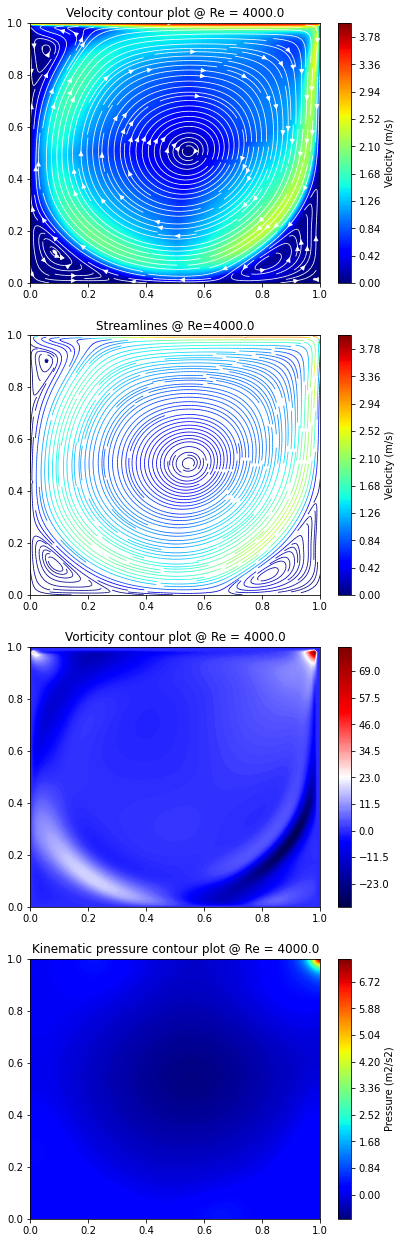

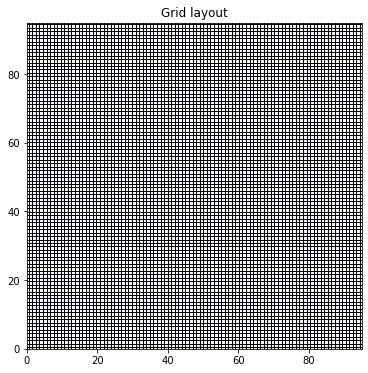

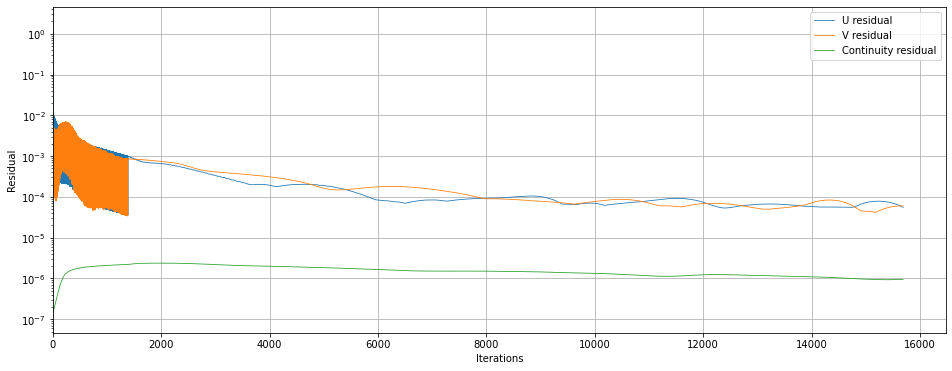

In [11]:
fig,ax=plt.subplots(4,1,figsize=(6.5,22))
ax[0].streamplot(xx,yy,U_final,V_final,density=2,color='white',linewidth=0.8)
graph=ax[0].contourf(xx,yy,V_mag,cmap=cm.jet,levels=255,vmax=u_wall)
ax[0].set_title('Velocity contour plot @ Re = '+str(Re))
fig.colorbar(graph,ax=ax[0],label='Velocity (m/s)')
ax[0].set_xlim(0,L)
ax[0].set_ylim(0,H)

ax[1].streamplot(xx,yy,U_final,V_final,density=3,color=V_mag,cmap=cm.jet,linewidth=0.8,arrowsize=0)
ax[1].set_title('Streamlines @ Re='+str(Re))
fig.colorbar(graph,ax=ax[1],label='Velocity (m/s)')
# ax[1].plot([0.1,0.1],[0,1])
# ax[1].plot([0.3,0.3],[0,1])
# ax[1].plot([0.62,0.62],[0,1])
# ax[1].plot([0,1],[0.4,0.4])
# ax[1].plot([0,1],[0.25,0.25])
ax[1].set_xlim(0,L)
ax[1].set_ylim(0,H)

graph=ax[2].contourf(xx,yy,vort,cmap=cm.seismic,levels=255)
ax[2].set_title('Vorticity contour plot @ Re = '+str(Re))
fig.colorbar(graph,ax=ax[2])
ax[2].set_xlim(0,L)
ax[2].set_ylim(0,H)

graph=ax[3].contourf(xx,yy,-P_final,cmap=cm.jet,levels=255)
ax[3].set_title('Kinematic pressure contour plot @ Re = '+str(Re))
fig.colorbar(graph,ax=ax[3],label='Pressure (m2/s2)')
ax[3].set_xlim(0,L)
ax[3].set_ylim(0,H)


plt.xlim(0,L)
plt.ylim(0,H)
plt.show()

fig,ax=plt.subplots(1,1,figsize=(6,6))
plt.pcolormesh(xxe,yye,empty,cmap=cm.Blues,shading='auto',ec='k')
plt.title('Grid layout')
plt.xlim(0,Nx)
plt.ylim(0,Ny)
plt.show()

iterations=np.linspace(0,iter_total,iter_total)
fig,ax=plt.subplots(1,1,figsize=(16,6))
plt.plot(iterations,U_res_list,label='U residual',linewidth=0.8)
plt.plot(iterations,V_res_list,label='V residual',linewidth=0.8)
plt.plot(iterations,Cont_res_list,label='Continuity residual',linewidth=0.8)
plt.xlabel('Iterations')
plt.ylabel('Residual')
ax.set_yscale('log')
plt.grid()
plt.xlim(0)
plt.legend()

plt.show()


In [12]:
np.save('RE4000_U_4.8s.npy',U_final)
np.save('RE4000_V_4.8s.npy',V_final)
np.save('RE4000_V_mag_4.8s.npy',V_mag)

In [15]:
np.save('RE4000_U_time.npy',U_time_data)
np.save('RE4000_V_time.npy',V_time_data)
np.save('RE4000_V_mag_time.npy',V_mag_file)

In [32]:
def column(matrix, i):
    return [row[i] for row in matrix]

<IPython.core.display.Javascript object>


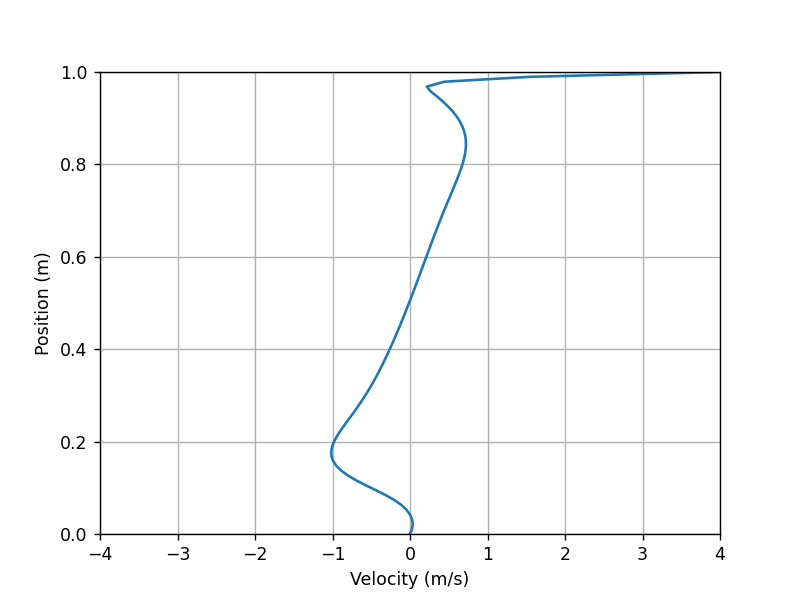

-1.0163798199883134


In [33]:
mid=column(U_final,20)
y=np.linspace(0,H,Ny+1)
plt.plot(mid,y)
plt.xlabel('Velocity (m/s)')
plt.ylabel('Position (m)')
plt.xlim(-u_wall,u_wall)
plt.ylim(0,H)
plt.grid()
plt.show()
print(np.min(mid))

# <font color='blue'>Animation</font>

In [14]:
U_anim=U_time_data[::1]
V_anim=V_time_data[::1]
count=int(time_steps/25)

U_file=[]
V_file=[]
V_mag_file=[]
Vort_file=[]

for k in range(count):
    U=U_anim[k]
    V=V_anim[k]

    U_final=np.zeros([Ny+1,Nx+1])
    for j in range(Ny+1):
        for i in range(Nx+1):
            U_final[j][i]=(U[j][i]+U[j+1][i])/2

    V_final=np.zeros([Ny+1,Nx+1])
    for j in range(Ny+1):
        for i in range(Nx+1):
            V_final[j][i]=(V[j][i]+V[j][i+1])/2
            
    V_mag=np.zeros([Ny+1,Nx+1])
    for j in range(Ny+1):
        for i in range(Nx+1):
            V_mag[j][i]=(np.sqrt(np.power(U_final[j][i],2))+np.sqrt(np.power(V_final[j][i],2)))
            
    vort=curl(U,V,dx,dy,Nx,Ny)
            
    U_file.append(U_final)
    V_file.append(V_final)
    V_mag_file.append(V_mag)
    Vort_file.append(vort)
    

In [28]:
def animate(k):
    ax.clear()
    
    U_final=U_file[k]
    V_final=V_file[k]
    #V_mag=V_mag_file[k]
    #vort=Vort_file[k]
    plt.title('Flow time: '+str(round(k*dt*25,3))+' seconds \n' 'Streamlines')
    
    plt.xlim(0,L)
    plt.ylim(0,H)
    #contour=plt.contourf(xx,yy,V_mag,cmap=cm.jet,vmax=u_wall,levels=255)
    #contour=plt.contourf(xx,yy,vort,cmap=cm.seismic,levels=30,vmax=80)
    stream=plt.streamplot(xx,yy,U_final,V_final,linewidth=0.75,density=3,color='k',arrowsize=0)
    return stream


<IPython.core.display.Javascript object>


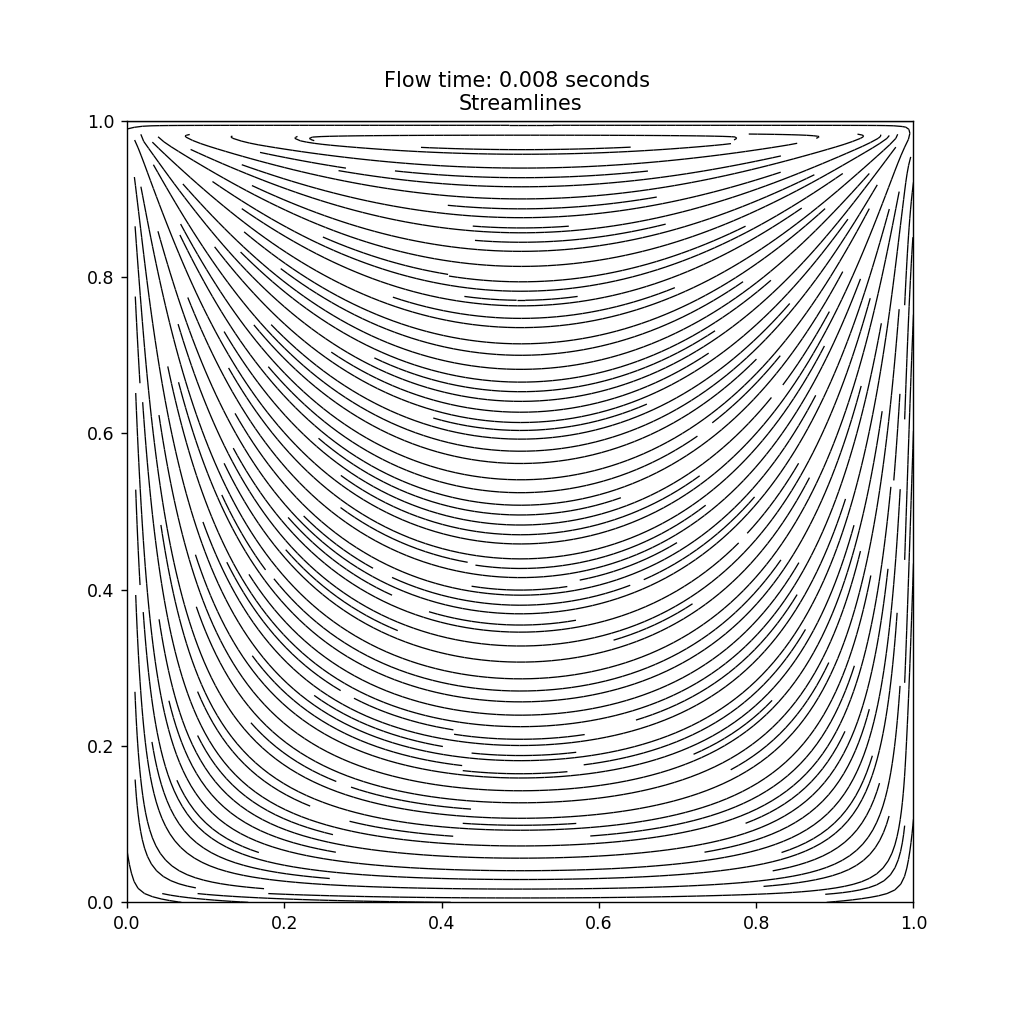

In [31]:
fig,ax=plt.subplots(1,1,figsize=(6.5,6.5))
plt.xlim(0,L)
plt.ylim(0,H)
x=np.linspace(0,L,Nx+1)
y=np.linspace(0,H,Ny+1)
xx,yy=np.meshgrid(x,y)

ani=FuncAnimation(fig,animate,count,interval=1000, blit=True)
plt.show()